In [1]:
import tensorflow as tf
import os
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Num GPUs Available:", len(
    tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

Num GPUs Available: 1


In [2]:
!pip install tensorflow_probability==0.8.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

In [4]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=3, scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution

tf.Tensor([1.5212469 1.7402602], shape=(2,), dtype=float32)
tf.Tensor([0.1635986  0.18692313], shape=(2,), dtype=float32)


In [5]:
dist = tfd.Normal(loc=1.0, scale=0.1)
print('sample   :', dist.sample(3).numpy()) #Samples 3 numbers
print('prob     :',dist.prob((0,1,2)).numpy()) #Calculates the probabilities for positions 0,1,2
print('log_prob :',dist.log_prob((0,1,2)).numpy()) #Same as above just log
print('cdf      :',dist.cdf((0,1,2)).numpy()) #Calculates the cummulative distributions
print('mean     :',dist.mean().numpy()) #Returns the mean of the distribution
print('stddev   :',dist.stddev().numpy())

sample   : [0.87277186 1.0461823  0.9748441 ]
prob     : [7.6946093e-22 3.9894230e+00 7.6946093e-22]
log_prob : [-48.616352    1.3836466 -48.616352 ]
cdf      : [7.619853e-24 5.000000e-01 1.000000e+00]
mean     : 1.0
stddev   : 0.1


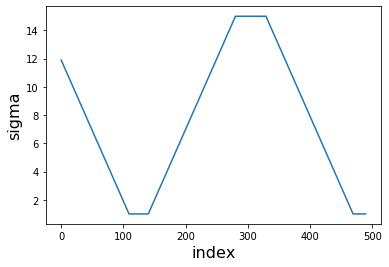

In [6]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()

In [7]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)


In [8]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [9]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

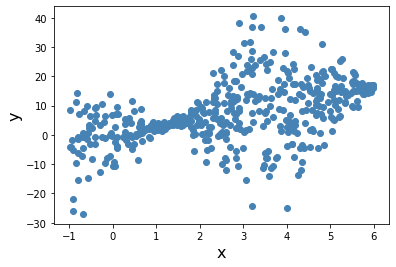

In [10]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))

nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [12]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]

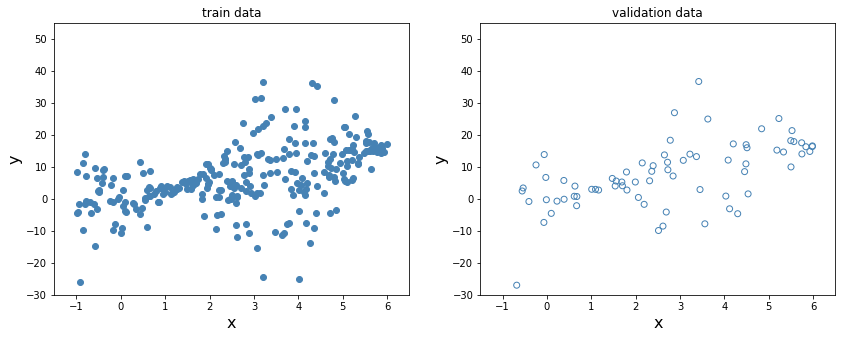

In [13]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.savefig("5.fish.split.pdf")

In [14]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)# set the sd to the fixed value 1

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_1 = Model(inputs=inputs, outputs=dist) #E
model_sd_1.compile(Adam(), loss=NLL) #F




#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Connecting the output of the neural network with a distribution
#F Compiling the model with NLL as loss function

model_sd_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
def my_dist2(params):
    return tfd.Normal(loc=params[0],scale=1e-3 + tf.math.softplus(0.05 * params[1]))

inputs = Input(shape=(1,))
mean = Dense(1)(inputs)
std = Dense(50,activation="relu")(inputs)
std = Dense(50,activation="relu")(std)
std = Dense(50,activation="relu")(std)
std = Dense(1)(std)
mean = Dense(1)(mean)
distLayer = tfp.layers.DistributionLambda(my_dist2)([mean,std])
model_sd_2 = Model(inputs=inputs,outputs=distLayer)
model_sd_2.compile(Adam(),loss=NLL)

model_sd_2.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           100         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           2550        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model_sd_2.fit(x_train, y_train, epochs=60000,verbose=1, validation_data=(x_val,y_val))

Train on 293 samples, validate on 74 samples
Epoch 1/60000
293/293 [==============================] - 1s 3ms/sample - loss: 162.2320 - val_loss: 166.2158
Epoch 2/60000
293/293 [==============================] - 0s 116us/sample - loss: 147.0910 - val_loss: 150.1596
Epoch 3/60000
293/293 [==============================] - 0s 117us/sample - loss: 130.6000 - val_loss: 130.8779
Epoch 4/60000
293/293 [==============================] - 0s 111us/sample - loss: 111.2921 - val_loss: 109.6102
Epoch 5/60000
293/293 [==============================] - 0s 132us/sample - loss: 90.6263 - val_loss: 86.8353
Epoch 6/60000
293/293 [==============================] - 0s 136us/sample - loss: 69.3101 - val_loss: 66.3372
Epoch 7/60000
293/293 [==============================] - 0s 111us/sample - loss: 51.2583 - val_loss: 49.7610
Epoch 8/60000
293/293 [==============================] - 0s 126us/sample - loss: 37.4708 - val_loss: 37.7344
Epoch 9/60000
293/293 [==============================] - 0s 124us/sample - lo

293/293 [==============================] - 0s 115us/sample - loss: 3.7928 - val_loss: 3.8959
Epoch 77/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.7918 - val_loss: 3.8926
Epoch 78/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.7908 - val_loss: 3.8867
Epoch 79/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.7890 - val_loss: 3.8836
Epoch 80/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.7880 - val_loss: 3.8813
Epoch 81/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.7872 - val_loss: 3.8784
Epoch 82/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.7864 - val_loss: 3.8758
Epoch 83/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.7857 - val_loss: 3.8742
Epoch 84/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7851 - val_loss: 3.8729
Epoch 85/60000
293/293 [===================

293/293 [==============================] - 0s 112us/sample - loss: 3.7696 - val_loss: 3.8206
Epoch 152/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.7695 - val_loss: 3.8202
Epoch 153/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.7694 - val_loss: 3.8198
Epoch 154/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.7692 - val_loss: 3.8195
Epoch 155/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.7692 - val_loss: 3.8189
Epoch 156/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.7690 - val_loss: 3.8185
Epoch 157/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.7690 - val_loss: 3.8183
Epoch 158/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7688 - val_loss: 3.8177
Epoch 159/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.7686 - val_loss: 3.8164
Epoch 160/60000
293/293 [==========

293/293 [==============================] - 0s 101us/sample - loss: 3.7621 - val_loss: 3.8025
Epoch 227/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.7620 - val_loss: 3.8026
Epoch 228/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.7619 - val_loss: 3.8025
Epoch 229/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.7618 - val_loss: 3.8026
Epoch 230/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.7618 - val_loss: 3.8025
Epoch 231/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.7617 - val_loss: 3.8023
Epoch 232/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.7614 - val_loss: 3.8018
Epoch 233/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.7613 - val_loss: 3.8015
Epoch 234/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7612 - val_loss: 3.8009
Epoch 235/60000
293/293 [==========

293/293 [==============================] - 0s 115us/sample - loss: 3.7531 - val_loss: 3.7916
Epoch 302/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.7531 - val_loss: 3.7916
Epoch 303/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.7529 - val_loss: 3.7916
Epoch 304/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.7528 - val_loss: 3.7913
Epoch 305/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.7524 - val_loss: 3.7904
Epoch 306/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7523 - val_loss: 3.7900
Epoch 307/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.7522 - val_loss: 3.7897
Epoch 308/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.7520 - val_loss: 3.7887
Epoch 309/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.7519 - val_loss: 3.7884
Epoch 310/60000
293/293 [==========

293/293 [==============================] - 0s 130us/sample - loss: 3.7405 - val_loss: 3.7733
Epoch 377/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.7403 - val_loss: 3.7727
Epoch 378/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.7404 - val_loss: 3.7729
Epoch 379/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.7402 - val_loss: 3.7729
Epoch 380/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.7399 - val_loss: 3.7728
Epoch 381/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.7395 - val_loss: 3.7729
Epoch 382/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.7393 - val_loss: 3.7729
Epoch 383/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.7391 - val_loss: 3.7730
Epoch 384/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.7391 - val_loss: 3.7718
Epoch 385/60000
293/293 [==========

293/293 [==============================] - 0s 112us/sample - loss: 3.7230 - val_loss: 3.7502
Epoch 452/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.7225 - val_loss: 3.7501
Epoch 453/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.7223 - val_loss: 3.7500
Epoch 454/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.7220 - val_loss: 3.7503
Epoch 455/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.7213 - val_loss: 3.7511
Epoch 456/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.7207 - val_loss: 3.7514
Epoch 457/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.7216 - val_loss: 3.7526
Epoch 458/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.7206 - val_loss: 3.7523
Epoch 459/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.7203 - val_loss: 3.7520
Epoch 460/60000
293/293 [==========

293/293 [==============================] - 0s 115us/sample - loss: 3.6932 - val_loss: 3.7216
Epoch 527/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.6928 - val_loss: 3.7205
Epoch 528/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.6927 - val_loss: 3.7180
Epoch 529/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.6923 - val_loss: 3.7174
Epoch 530/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.6915 - val_loss: 3.7163
Epoch 531/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.6909 - val_loss: 3.7159
Epoch 532/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.6903 - val_loss: 3.7160
Epoch 533/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.6898 - val_loss: 3.7147
Epoch 534/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.6894 - val_loss: 3.7135
Epoch 535/60000
293/293 [==========

293/293 [==============================] - 0s 120us/sample - loss: 3.6378 - val_loss: 3.6546
Epoch 602/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.6373 - val_loss: 3.6534
Epoch 603/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.6372 - val_loss: 3.6513
Epoch 604/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.6355 - val_loss: 3.6511
Epoch 605/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.6341 - val_loss: 3.6510
Epoch 606/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.6327 - val_loss: 3.6496
Epoch 607/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.6318 - val_loss: 3.6483
Epoch 608/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.6306 - val_loss: 3.6468
Epoch 609/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.6305 - val_loss: 3.6445
Epoch 610/60000
293/293 [==========

293/293 [==============================] - 0s 115us/sample - loss: 3.5429 - val_loss: 3.5306
Epoch 677/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.5426 - val_loss: 3.5293
Epoch 678/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.5411 - val_loss: 3.5274
Epoch 679/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.5398 - val_loss: 3.5259
Epoch 680/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.5385 - val_loss: 3.5245
Epoch 681/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.5379 - val_loss: 3.5232
Epoch 682/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.5368 - val_loss: 3.5204
Epoch 683/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.5362 - val_loss: 3.5182
Epoch 684/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.5343 - val_loss: 3.5161
Epoch 685/60000
293/293 [==========

293/293 [==============================] - 0s 126us/sample - loss: 3.4880 - val_loss: 3.4447
Epoch 752/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.4879 - val_loss: 3.4452
Epoch 753/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.4875 - val_loss: 3.4458
Epoch 754/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.4882 - val_loss: 3.4459
Epoch 755/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.4872 - val_loss: 3.4445
Epoch 756/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.4860 - val_loss: 3.4430
Epoch 757/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.4862 - val_loss: 3.4428
Epoch 758/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.4875 - val_loss: 3.4433
Epoch 759/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.4875 - val_loss: 3.4421
Epoch 760/60000
293/293 [==========

293/293 [==============================] - 0s 109us/sample - loss: 3.4609 - val_loss: 3.4130
Epoch 827/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.4636 - val_loss: 3.4130
Epoch 828/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.4626 - val_loss: 3.4144
Epoch 829/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.4647 - val_loss: 3.4087
Epoch 830/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4644 - val_loss: 3.4059
Epoch 831/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.4618 - val_loss: 3.4063
Epoch 832/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4613 - val_loss: 3.4089
Epoch 833/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.4607 - val_loss: 3.4166
Epoch 834/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.4635 - val_loss: 3.4098
Epoch 835/60000
293/293 [==========

293/293 [==============================] - 0s 135us/sample - loss: 3.4487 - val_loss: 3.3992
Epoch 902/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.4470 - val_loss: 3.3931
Epoch 903/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.4434 - val_loss: 3.3949
Epoch 904/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.4435 - val_loss: 3.3923
Epoch 905/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4428 - val_loss: 3.3899
Epoch 906/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.4434 - val_loss: 3.3875
Epoch 907/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.4422 - val_loss: 3.3893
Epoch 908/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4424 - val_loss: 3.3874
Epoch 909/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.4415 - val_loss: 3.3873
Epoch 910/60000
293/293 [==========

293/293 [==============================] - 0s 107us/sample - loss: 3.4304 - val_loss: 3.3779
Epoch 977/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.4288 - val_loss: 3.3743
Epoch 978/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.4287 - val_loss: 3.3721
Epoch 979/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.4287 - val_loss: 3.3719
Epoch 980/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.4285 - val_loss: 3.3735
Epoch 981/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.4278 - val_loss: 3.3805
Epoch 982/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.4304 - val_loss: 3.3753
Epoch 983/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.4297 - val_loss: 3.3834
Epoch 984/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.4299 - val_loss: 3.3788
Epoch 985/60000
293/293 [==========

Epoch 1051/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4160 - val_loss: 3.3584
Epoch 1052/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.4150 - val_loss: 3.3513
Epoch 1053/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.4130 - val_loss: 3.3519
Epoch 1054/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.4138 - val_loss: 3.3546
Epoch 1055/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.4129 - val_loss: 3.3545
Epoch 1056/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.4129 - val_loss: 3.3514
Epoch 1057/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.4110 - val_loss: 3.3537
Epoch 1058/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.4105 - val_loss: 3.3582
Epoch 1059/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.4112 - val_loss: 3.3539
Epoch 1060

293/293 [==============================] - 0s 116us/sample - loss: 3.3869 - val_loss: 3.3223
Epoch 1126/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.3883 - val_loss: 3.3307
Epoch 1127/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.3871 - val_loss: 3.3209
Epoch 1128/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.3857 - val_loss: 3.3189
Epoch 1129/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.3853 - val_loss: 3.3204
Epoch 1130/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.3846 - val_loss: 3.3187
Epoch 1131/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.3838 - val_loss: 3.3214
Epoch 1132/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.3862 - val_loss: 3.3239
Epoch 1133/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.3876 - val_loss: 3.3302
Epoch 1134/60000
293/293 [=

293/293 [==============================] - 0s 108us/sample - loss: 3.3369 - val_loss: 3.2377
Epoch 1200/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.3357 - val_loss: 3.2326
Epoch 1201/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.3345 - val_loss: 3.2328
Epoch 1202/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.3316 - val_loss: 3.2334
Epoch 1203/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.3305 - val_loss: 3.2301
Epoch 1204/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.3301 - val_loss: 3.2372
Epoch 1205/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.3255 - val_loss: 3.2234
Epoch 1206/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.3274 - val_loss: 3.2219
Epoch 1207/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.3229 - val_loss: 3.2280
Epoch 1208/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.2229 - val_loss: 3.1110
Epoch 1274/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2325 - val_loss: 3.1196
Epoch 1275/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2318 - val_loss: 3.1150
Epoch 1276/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2372 - val_loss: 3.1104
Epoch 1277/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2136 - val_loss: 3.1004
Epoch 1278/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2168 - val_loss: 3.0979
Epoch 1279/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2312 - val_loss: 3.0964
Epoch 1280/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2176 - val_loss: 3.0888
Epoch 1281/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2184 - val_loss: 3.1082
Epoch 1282/60000
293/293 [=

293/293 [==============================] - 0s 110us/sample - loss: 3.2045 - val_loss: 3.1018
Epoch 1348/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2013 - val_loss: 3.0997
Epoch 1349/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1988 - val_loss: 3.1031
Epoch 1350/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2080 - val_loss: 3.1052
Epoch 1351/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2043 - val_loss: 3.1030
Epoch 1352/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2063 - val_loss: 3.0991
Epoch 1353/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2094 - val_loss: 3.1471
Epoch 1354/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2172 - val_loss: 3.1230
Epoch 1355/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2034 - val_loss: 3.1060
Epoch 1356/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.2002 - val_loss: 3.1031
Epoch 1422/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1910 - val_loss: 3.1160
Epoch 1423/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1974 - val_loss: 3.1111
Epoch 1424/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1894 - val_loss: 3.0988
Epoch 1425/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1927 - val_loss: 3.1042
Epoch 1426/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1900 - val_loss: 3.1142
Epoch 1427/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1987 - val_loss: 3.1085
Epoch 1428/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1871 - val_loss: 3.1080
Epoch 1429/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2262 - val_loss: 3.1074
Epoch 1430/60000
293/293 [=

293/293 [==============================] - 0s 123us/sample - loss: 3.2010 - val_loss: 3.1001
Epoch 1496/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1900 - val_loss: 3.1251
Epoch 1497/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1976 - val_loss: 3.1080
Epoch 1498/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1969 - val_loss: 3.0980
Epoch 1499/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1963 - val_loss: 3.0978
Epoch 1500/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2499 - val_loss: 3.2300
Epoch 1501/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2957 - val_loss: 3.1925
Epoch 1502/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2549 - val_loss: 3.1141
Epoch 1503/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2060 - val_loss: 3.1249
Epoch 1504/60000
293/293 [=

293/293 [==============================] - 0s 139us/sample - loss: 3.1854 - val_loss: 3.1078
Epoch 1570/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1952 - val_loss: 3.1093
Epoch 1571/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1846 - val_loss: 3.1103
Epoch 1572/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1863 - val_loss: 3.1118
Epoch 1573/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1923 - val_loss: 3.1097
Epoch 1574/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1860 - val_loss: 3.1138
Epoch 1575/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1854 - val_loss: 3.1091
Epoch 1576/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1859 - val_loss: 3.1101
Epoch 1577/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1852 - val_loss: 3.1033
Epoch 1578/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1871 - val_loss: 3.1093
Epoch 1644/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1868 - val_loss: 3.1070
Epoch 1645/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1948 - val_loss: 3.1020
Epoch 1646/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2010 - val_loss: 3.1145
Epoch 1647/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1910 - val_loss: 3.1110
Epoch 1648/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1946 - val_loss: 3.1034
Epoch 1649/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1867 - val_loss: 3.0995
Epoch 1650/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1959 - val_loss: 3.1051
Epoch 1651/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1846 - val_loss: 3.1106
Epoch 1652/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.3298 - val_loss: 3.2215
Epoch 1718/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2872 - val_loss: 3.1751
Epoch 1719/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2136 - val_loss: 3.1212
Epoch 1720/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2090 - val_loss: 3.1174
Epoch 1721/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1947 - val_loss: 3.1298
Epoch 1722/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1919 - val_loss: 3.1198
Epoch 1723/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1871 - val_loss: 3.1136
Epoch 1724/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1874 - val_loss: 3.1077
Epoch 1725/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1857 - val_loss: 3.1106
Epoch 1726/60000
293/293 [=

293/293 [==============================] - 0s 130us/sample - loss: 3.1896 - val_loss: 3.1106
Epoch 1792/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1844 - val_loss: 3.1102
Epoch 1793/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1902 - val_loss: 3.1085
Epoch 1794/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1968 - val_loss: 3.1229
Epoch 1795/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1971 - val_loss: 3.1019
Epoch 1796/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1873 - val_loss: 3.1088
Epoch 1797/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1879 - val_loss: 3.1136
Epoch 1798/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1851 - val_loss: 3.1059
Epoch 1799/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1897 - val_loss: 3.1042
Epoch 1800/60000
293/293 [=

293/293 [==============================] - 0s 122us/sample - loss: 3.2025 - val_loss: 3.1193
Epoch 1866/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1984 - val_loss: 3.1157
Epoch 1867/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1951 - val_loss: 3.1099
Epoch 1868/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1958 - val_loss: 3.1052
Epoch 1869/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1857 - val_loss: 3.1078
Epoch 1870/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1877 - val_loss: 3.1108
Epoch 1871/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1894 - val_loss: 3.1081
Epoch 1872/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1916 - val_loss: 3.1094
Epoch 1873/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1876 - val_loss: 3.1099
Epoch 1874/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1909 - val_loss: 3.1072
Epoch 1940/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1848 - val_loss: 3.1044
Epoch 1941/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1936 - val_loss: 3.1053
Epoch 1942/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1859 - val_loss: 3.1129
Epoch 1943/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1909 - val_loss: 3.1180
Epoch 1944/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1894 - val_loss: 3.1115
Epoch 1945/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1847 - val_loss: 3.1074
Epoch 1946/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1858 - val_loss: 3.1093
Epoch 1947/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1869 - val_loss: 3.1075
Epoch 1948/60000
293/293 [=

293/293 [==============================] - 0s 111us/sample - loss: 3.1914 - val_loss: 3.1049
Epoch 2014/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1862 - val_loss: 3.1080
Epoch 2015/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2336 - val_loss: 3.1375
Epoch 2016/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2575 - val_loss: 3.1873
Epoch 2017/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2569 - val_loss: 3.1285
Epoch 2018/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2050 - val_loss: 3.1095
Epoch 2019/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1866 - val_loss: 3.1169
Epoch 2020/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1919 - val_loss: 3.1117
Epoch 2021/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1854 - val_loss: 3.1109
Epoch 2022/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1852 - val_loss: 3.1033
Epoch 2088/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1867 - val_loss: 3.1061
Epoch 2089/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1883 - val_loss: 3.1107
Epoch 2090/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1883 - val_loss: 3.1088
Epoch 2091/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1882 - val_loss: 3.1097
Epoch 2092/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1883 - val_loss: 3.1036
Epoch 2093/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1927 - val_loss: 3.1385
Epoch 2094/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2013 - val_loss: 3.1366
Epoch 2095/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1846 - val_loss: 3.1110
Epoch 2096/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1916 - val_loss: 3.1031
Epoch 2162/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1887 - val_loss: 3.1060
Epoch 2163/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1929 - val_loss: 3.1029
Epoch 2164/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2528 - val_loss: 3.2344
Epoch 2165/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.3101 - val_loss: 3.2189
Epoch 2166/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2853 - val_loss: 3.1794
Epoch 2167/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2384 - val_loss: 3.1110
Epoch 2168/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2026 - val_loss: 3.1125
Epoch 2169/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1855 - val_loss: 3.1153
Epoch 2170/60000
293/293 [=

293/293 [==============================] - 0s 121us/sample - loss: 3.2231 - val_loss: 3.1043
Epoch 2236/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1932 - val_loss: 3.1127
Epoch 2237/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1873 - val_loss: 3.1154
Epoch 2238/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1935 - val_loss: 3.1139
Epoch 2239/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1967 - val_loss: 3.1087
Epoch 2240/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1906 - val_loss: 3.1110
Epoch 2241/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1873 - val_loss: 3.1079
Epoch 2242/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1832 - val_loss: 3.1115
Epoch 2243/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1931 - val_loss: 3.1047
Epoch 2244/60000
293/293 [=

293/293 [==============================] - 0s 127us/sample - loss: 3.1834 - val_loss: 3.1146
Epoch 2310/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1855 - val_loss: 3.1168
Epoch 2311/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1920 - val_loss: 3.1101
Epoch 2312/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1851 - val_loss: 3.1183
Epoch 2313/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1899 - val_loss: 3.1215
Epoch 2314/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1945 - val_loss: 3.1090
Epoch 2315/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2177 - val_loss: 3.1302
Epoch 2316/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2131 - val_loss: 3.1033
Epoch 2317/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2106 - val_loss: 3.1055
Epoch 2318/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1867 - val_loss: 3.1110
Epoch 2384/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1873 - val_loss: 3.1063
Epoch 2385/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1856 - val_loss: 3.1069
Epoch 2386/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1841 - val_loss: 3.1052
Epoch 2387/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1879 - val_loss: 3.1049
Epoch 2388/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1874 - val_loss: 3.1045
Epoch 2389/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1875 - val_loss: 3.1052
Epoch 2390/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1869 - val_loss: 3.1072
Epoch 2391/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1933 - val_loss: 3.1311
Epoch 2392/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1920 - val_loss: 3.1068
Epoch 2458/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1893 - val_loss: 3.1165
Epoch 2459/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1941 - val_loss: 3.1164
Epoch 2460/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1904 - val_loss: 3.1229
Epoch 2461/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1886 - val_loss: 3.1010
Epoch 2462/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1870 - val_loss: 3.1002
Epoch 2463/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1823 - val_loss: 3.1091
Epoch 2464/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1980 - val_loss: 3.1250
Epoch 2465/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1892 - val_loss: 3.1102
Epoch 2466/60000
293/293 [=

293/293 [==============================] - 0s 136us/sample - loss: 3.1995 - val_loss: 3.1000
Epoch 2532/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2917 - val_loss: 3.2993
Epoch 2533/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.3682 - val_loss: 3.2962
Epoch 2534/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.3655 - val_loss: 3.2777
Epoch 2535/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.3441 - val_loss: 3.2451
Epoch 2536/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.3082 - val_loss: 3.2041
Epoch 2537/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2644 - val_loss: 3.1478
Epoch 2538/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2089 - val_loss: 3.1135
Epoch 2539/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.2037 - val_loss: 3.1194
Epoch 2540/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1969 - val_loss: 3.1059
Epoch 2606/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1924 - val_loss: 3.1131
Epoch 2607/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1871 - val_loss: 3.1052
Epoch 2608/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1843 - val_loss: 3.1153
Epoch 2609/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1880 - val_loss: 3.1100
Epoch 2610/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1871 - val_loss: 3.1181
Epoch 2611/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1828 - val_loss: 3.1055
Epoch 2612/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1885 - val_loss: 3.1045
Epoch 2613/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1884 - val_loss: 3.1121
Epoch 2614/60000
293/293 [=

293/293 [==============================] - 0s 105us/sample - loss: 3.1966 - val_loss: 3.1208
Epoch 2680/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1902 - val_loss: 3.1080
Epoch 2681/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1925 - val_loss: 3.1250
Epoch 2682/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1951 - val_loss: 3.1111
Epoch 2683/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1891 - val_loss: 3.1118
Epoch 2684/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2126 - val_loss: 3.1128
Epoch 2685/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2000 - val_loss: 3.1162
Epoch 2686/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1949 - val_loss: 3.1025
Epoch 2687/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1894 - val_loss: 3.1034
Epoch 2688/60000
293/293 [=

293/293 [==============================] - 0s 130us/sample - loss: 3.2452 - val_loss: 3.2045
Epoch 2754/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2700 - val_loss: 3.1663
Epoch 2755/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.2289 - val_loss: 3.1067
Epoch 2756/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1937 - val_loss: 3.1360
Epoch 2757/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1908 - val_loss: 3.1092
Epoch 2758/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1909 - val_loss: 3.1054
Epoch 2759/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1823 - val_loss: 3.1130
Epoch 2760/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1871 - val_loss: 3.1029
Epoch 2761/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1849 - val_loss: 3.0967
Epoch 2762/60000
293/293 [=

293/293 [==============================] - 0s 123us/sample - loss: 3.1906 - val_loss: 3.1065
Epoch 2828/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1934 - val_loss: 3.1109
Epoch 2829/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1858 - val_loss: 3.1085
Epoch 2830/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1867 - val_loss: 3.1043
Epoch 2831/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1852 - val_loss: 3.1032
Epoch 2832/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1897 - val_loss: 3.1082
Epoch 2833/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1892 - val_loss: 3.1122
Epoch 2834/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2052 - val_loss: 3.1080
Epoch 2835/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.2887 - val_loss: 3.3146
Epoch 2836/60000
293/293 [=

293/293 [==============================] - 0s 111us/sample - loss: 3.1861 - val_loss: 3.1098
Epoch 2902/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1818 - val_loss: 3.1150
Epoch 2903/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1899 - val_loss: 3.1240
Epoch 2904/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1889 - val_loss: 3.1096
Epoch 2905/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1846 - val_loss: 3.1036
Epoch 2906/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1834 - val_loss: 3.1041
Epoch 2907/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1850 - val_loss: 3.1202
Epoch 2908/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1866 - val_loss: 3.1082
Epoch 2909/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1842 - val_loss: 3.0949
Epoch 2910/60000
293/293 [=

293/293 [==============================] - 0s 97us/sample - loss: 3.1851 - val_loss: 3.1025
Epoch 2976/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1916 - val_loss: 3.1004
Epoch 2977/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1981 - val_loss: 3.1102
Epoch 2978/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1884 - val_loss: 3.1075
Epoch 2979/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1897 - val_loss: 3.1099
Epoch 2980/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1827 - val_loss: 3.1112
Epoch 2981/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2274 - val_loss: 3.1721
Epoch 2982/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.2371 - val_loss: 3.1141
Epoch 2983/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1891 - val_loss: 3.1292
Epoch 2984/60000
293/293 [==

293/293 [==============================] - 0s 121us/sample - loss: 3.1844 - val_loss: 3.1075
Epoch 3050/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1842 - val_loss: 3.1091
Epoch 3051/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1945 - val_loss: 3.1255
Epoch 3052/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1861 - val_loss: 3.1133
Epoch 3053/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1896 - val_loss: 3.1193
Epoch 3054/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1880 - val_loss: 3.1339
Epoch 3055/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1918 - val_loss: 3.1067
Epoch 3056/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1855 - val_loss: 3.1078
Epoch 3057/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1847 - val_loss: 3.1098
Epoch 3058/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1838 - val_loss: 3.1062
Epoch 3124/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1883 - val_loss: 3.1063
Epoch 3125/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1882 - val_loss: 3.1012
Epoch 3126/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1874 - val_loss: 3.1084
Epoch 3127/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1967 - val_loss: 3.1060
Epoch 3128/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1840 - val_loss: 3.1002
Epoch 3129/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2029 - val_loss: 3.1183
Epoch 3130/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1952 - val_loss: 3.1049
Epoch 3131/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1858 - val_loss: 3.1064
Epoch 3132/60000
293/293 [=

293/293 [==============================] - 0s 102us/sample - loss: 3.1848 - val_loss: 3.1149
Epoch 3198/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1840 - val_loss: 3.1088
Epoch 3199/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1817 - val_loss: 3.1086
Epoch 3200/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1822 - val_loss: 3.1129
Epoch 3201/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1870 - val_loss: 3.1122
Epoch 3202/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1916 - val_loss: 3.1128
Epoch 3203/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1817 - val_loss: 3.1077
Epoch 3204/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1806 - val_loss: 3.1040
Epoch 3205/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1864 - val_loss: 3.1083
Epoch 3206/60000
293/293 [=

293/293 [==============================] - 0s 112us/sample - loss: 3.1835 - val_loss: 3.1015
Epoch 3272/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1856 - val_loss: 3.1078
Epoch 3273/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1840 - val_loss: 3.1099
Epoch 3274/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1866 - val_loss: 3.1237
Epoch 3275/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1893 - val_loss: 3.1105
Epoch 3276/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1880 - val_loss: 3.1063
Epoch 3277/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1841 - val_loss: 3.1048
Epoch 3278/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1813 - val_loss: 3.1053
Epoch 3279/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1824 - val_loss: 3.1050
Epoch 3280/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1877 - val_loss: 3.1075
Epoch 3346/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.2007 - val_loss: 3.1140
Epoch 3347/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1946 - val_loss: 3.1103
Epoch 3348/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1910 - val_loss: 3.1088
Epoch 3349/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1900 - val_loss: 3.1003
Epoch 3350/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1851 - val_loss: 3.1061
Epoch 3351/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1903 - val_loss: 3.1205
Epoch 3352/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1859 - val_loss: 3.1050
Epoch 3353/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1818 - val_loss: 3.1051
Epoch 3354/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1839 - val_loss: 3.1076
Epoch 3420/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1919 - val_loss: 3.1024
Epoch 3421/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1840 - val_loss: 3.1118
Epoch 3422/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1932 - val_loss: 3.1053
Epoch 3423/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1887 - val_loss: 3.1052
Epoch 3424/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1815 - val_loss: 3.1115
Epoch 3425/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1886 - val_loss: 3.1107
Epoch 3426/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1980 - val_loss: 3.1041
Epoch 3427/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1836 - val_loss: 3.1084
Epoch 3428/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1853 - val_loss: 3.1101
Epoch 3494/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2038 - val_loss: 3.1093
Epoch 3495/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1950 - val_loss: 3.1008
Epoch 3496/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2303 - val_loss: 3.1822
Epoch 3497/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2575 - val_loss: 3.1402
Epoch 3498/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2231 - val_loss: 3.1015
Epoch 3499/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1998 - val_loss: 3.1185
Epoch 3500/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1994 - val_loss: 3.1219
Epoch 3501/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1868 - val_loss: 3.1167
Epoch 3502/60000
293/293 [=

293/293 [==============================] - 0s 128us/sample - loss: 3.1869 - val_loss: 3.1061
Epoch 3568/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1864 - val_loss: 3.1077
Epoch 3569/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1829 - val_loss: 3.1103
Epoch 3570/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1865 - val_loss: 3.1092
Epoch 3571/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1851 - val_loss: 3.1082
Epoch 3572/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1822 - val_loss: 3.1056
Epoch 3573/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1889 - val_loss: 3.1011
Epoch 3574/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2635 - val_loss: 3.2496
Epoch 3575/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.3166 - val_loss: 3.2231
Epoch 3576/60000
293/293 [=

293/293 [==============================] - 0s 106us/sample - loss: 3.1867 - val_loss: 3.1069
Epoch 3642/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1947 - val_loss: 3.1285
Epoch 3643/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2066 - val_loss: 3.1167
Epoch 3644/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1937 - val_loss: 3.1126
Epoch 3645/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1848 - val_loss: 3.1073
Epoch 3646/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1815 - val_loss: 3.1096
Epoch 3647/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1830 - val_loss: 3.1071
Epoch 3648/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1831 - val_loss: 3.1152
Epoch 3649/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1917 - val_loss: 3.1222
Epoch 3650/60000
293/293 [=

293/293 [==============================] - 0s 109us/sample - loss: 3.1818 - val_loss: 3.1075
Epoch 3716/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1816 - val_loss: 3.1072
Epoch 3717/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1866 - val_loss: 3.1049
Epoch 3718/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1858 - val_loss: 3.1068
Epoch 3719/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1785 - val_loss: 3.1120
Epoch 3720/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1871 - val_loss: 3.1046
Epoch 3721/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1873 - val_loss: 3.1081
Epoch 3722/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1905 - val_loss: 3.1124
Epoch 3723/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1867 - val_loss: 3.1046
Epoch 3724/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.1948 - val_loss: 3.1186
Epoch 3790/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1929 - val_loss: 3.1122
Epoch 3791/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1879 - val_loss: 3.1063
Epoch 3792/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1999 - val_loss: 3.1177
Epoch 3793/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1841 - val_loss: 3.1190
Epoch 3794/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1829 - val_loss: 3.1092
Epoch 3795/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1863 - val_loss: 3.1059
Epoch 3796/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1835 - val_loss: 3.1211
Epoch 3797/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1909 - val_loss: 3.1077
Epoch 3798/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1894 - val_loss: 3.1260
Epoch 3864/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1846 - val_loss: 3.1081
Epoch 3865/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1880 - val_loss: 3.1072
Epoch 3866/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1835 - val_loss: 3.1023
Epoch 3867/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1846 - val_loss: 3.1053
Epoch 3868/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1870 - val_loss: 3.1145
Epoch 3869/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1826 - val_loss: 3.1062
Epoch 3870/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1835 - val_loss: 3.1045
Epoch 3871/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1846 - val_loss: 3.1074
Epoch 3872/60000
293/293 [=

293/293 [==============================] - 0s 127us/sample - loss: 3.1955 - val_loss: 3.1252
Epoch 3938/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1845 - val_loss: 3.1006
Epoch 3939/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1845 - val_loss: 3.0982
Epoch 3940/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1828 - val_loss: 3.1045
Epoch 3941/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1821 - val_loss: 3.1101
Epoch 3942/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1823 - val_loss: 3.1080
Epoch 3943/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1847 - val_loss: 3.1094
Epoch 3944/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1824 - val_loss: 3.1083
Epoch 3945/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1828 - val_loss: 3.1104
Epoch 3946/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1839 - val_loss: 3.1085
Epoch 4012/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1857 - val_loss: 3.1112
Epoch 4013/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1844 - val_loss: 3.1187
Epoch 4014/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1843 - val_loss: 3.1217
Epoch 4015/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1942 - val_loss: 3.1066
Epoch 4016/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1898 - val_loss: 3.1166
Epoch 4017/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1907 - val_loss: 3.1197
Epoch 4018/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1882 - val_loss: 3.1083
Epoch 4019/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1829 - val_loss: 3.1171
Epoch 4020/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1805 - val_loss: 3.1087
Epoch 4086/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1822 - val_loss: 3.1178
Epoch 4087/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1842 - val_loss: 3.1098
Epoch 4088/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1979 - val_loss: 3.1170
Epoch 4089/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1895 - val_loss: 3.1187
Epoch 4090/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1851 - val_loss: 3.1164
Epoch 4091/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1852 - val_loss: 3.1117
Epoch 4092/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1871 - val_loss: 3.1251
Epoch 4093/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1805 - val_loss: 3.1096
Epoch 4094/60000
293/293 [=

293/293 [==============================] - 0s 122us/sample - loss: 3.1835 - val_loss: 3.1040
Epoch 4160/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1832 - val_loss: 3.1072
Epoch 4161/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1846 - val_loss: 3.1154
Epoch 4162/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1850 - val_loss: 3.1129
Epoch 4163/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1848 - val_loss: 3.1126
Epoch 4164/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1818 - val_loss: 3.1067
Epoch 4165/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1812 - val_loss: 3.1120
Epoch 4166/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1888 - val_loss: 3.1131
Epoch 4167/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1851 - val_loss: 3.1118
Epoch 4168/60000
293/293 [=

293/293 [==============================] - 0s 137us/sample - loss: 3.1852 - val_loss: 3.1088
Epoch 4234/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1815 - val_loss: 3.1085
Epoch 4235/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1855 - val_loss: 3.1141
Epoch 4236/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1843 - val_loss: 3.1118
Epoch 4237/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1813 - val_loss: 3.1093
Epoch 4238/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1953 - val_loss: 3.1099
Epoch 4239/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1792 - val_loss: 3.1079
Epoch 4240/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1890 - val_loss: 3.1113
Epoch 4241/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1876 - val_loss: 3.1040
Epoch 4242/60000
293/293 [=

293/293 [==============================] - 0s 127us/sample - loss: 3.1826 - val_loss: 3.1089
Epoch 4308/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1829 - val_loss: 3.1137
Epoch 4309/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1866 - val_loss: 3.1061
Epoch 4310/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1853 - val_loss: 3.1143
Epoch 4311/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1808 - val_loss: 3.1151
Epoch 4312/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1820 - val_loss: 3.1173
Epoch 4313/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1837 - val_loss: 3.1163
Epoch 4314/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1835 - val_loss: 3.1161
Epoch 4315/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1870 - val_loss: 3.1071
Epoch 4316/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.1821 - val_loss: 3.1059
Epoch 4382/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1896 - val_loss: 3.1054
Epoch 4383/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1805 - val_loss: 3.1014
Epoch 4384/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1811 - val_loss: 3.1057
Epoch 4385/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1844 - val_loss: 3.1051
Epoch 4386/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1808 - val_loss: 3.1105
Epoch 4387/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1907 - val_loss: 3.1101
Epoch 4388/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1815 - val_loss: 3.1073
Epoch 4389/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1932 - val_loss: 3.1081
Epoch 4390/60000
293/293 [=

293/293 [==============================] - 0s 129us/sample - loss: 3.1941 - val_loss: 3.1027
Epoch 4456/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2076 - val_loss: 3.1136
Epoch 4457/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1888 - val_loss: 3.1120
Epoch 4458/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1856 - val_loss: 3.1139
Epoch 4459/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1826 - val_loss: 3.1064
Epoch 4460/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1860 - val_loss: 3.1014
Epoch 4461/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1822 - val_loss: 3.1063
Epoch 4462/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1834 - val_loss: 3.1079
Epoch 4463/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1843 - val_loss: 3.1015
Epoch 4464/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1881 - val_loss: 3.1089
Epoch 4530/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1859 - val_loss: 3.1073
Epoch 4531/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1829 - val_loss: 3.1083
Epoch 4532/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1801 - val_loss: 3.1034
Epoch 4533/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1853 - val_loss: 3.1041
Epoch 4534/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1807 - val_loss: 3.1062
Epoch 4535/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1836 - val_loss: 3.0991
Epoch 4536/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2219 - val_loss: 3.1838
Epoch 4537/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2613 - val_loss: 3.1642
Epoch 4538/60000
293/293 [=

293/293 [==============================] - 0s 133us/sample - loss: 3.1999 - val_loss: 3.1091
Epoch 4604/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1869 - val_loss: 3.1063
Epoch 4605/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1807 - val_loss: 3.1344
Epoch 4606/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1862 - val_loss: 3.1064
Epoch 4607/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1822 - val_loss: 3.1070
Epoch 4608/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1831 - val_loss: 3.1121
Epoch 4609/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1880 - val_loss: 3.1077
Epoch 4610/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1802 - val_loss: 3.1043
Epoch 4611/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1834 - val_loss: 3.1113
Epoch 4612/60000
293/293 [=

293/293 [==============================] - 0s 109us/sample - loss: 3.1862 - val_loss: 3.1038
Epoch 4678/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1807 - val_loss: 3.1029
Epoch 4679/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1825 - val_loss: 3.1077
Epoch 4680/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1829 - val_loss: 3.1086
Epoch 4681/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1798 - val_loss: 3.1119
Epoch 4682/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1835 - val_loss: 3.1093
Epoch 4683/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1838 - val_loss: 3.1053
Epoch 4684/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1853 - val_loss: 3.1094
Epoch 4685/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1863 - val_loss: 3.1054
Epoch 4686/60000
293/293 [=

293/293 [==============================] - 0s 122us/sample - loss: 3.1852 - val_loss: 3.1068
Epoch 4752/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1909 - val_loss: 3.1162
Epoch 4753/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1828 - val_loss: 3.1108
Epoch 4754/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1814 - val_loss: 3.1075
Epoch 4755/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1830 - val_loss: 3.1093
Epoch 4756/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1849 - val_loss: 3.1071
Epoch 4757/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1822 - val_loss: 3.1146
Epoch 4758/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1839 - val_loss: 3.1133
Epoch 4759/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1859 - val_loss: 3.1106
Epoch 4760/60000
293/293 [=

293/293 [==============================] - 0s 132us/sample - loss: 3.1807 - val_loss: 3.1091
Epoch 4826/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1844 - val_loss: 3.1046
Epoch 4827/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1833 - val_loss: 3.1155
Epoch 4828/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1838 - val_loss: 3.1084
Epoch 4829/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1842 - val_loss: 3.1068
Epoch 4830/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2317 - val_loss: 3.2085
Epoch 4831/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2798 - val_loss: 3.1897
Epoch 4832/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2565 - val_loss: 3.1399
Epoch 4833/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2061 - val_loss: 3.1194
Epoch 4834/60000
293/293 [=

293/293 [==============================] - 0s 106us/sample - loss: 3.1802 - val_loss: 3.1066
Epoch 4900/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1844 - val_loss: 3.1130
Epoch 4901/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1826 - val_loss: 3.1084
Epoch 4902/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1877 - val_loss: 3.1042
Epoch 4903/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1929 - val_loss: 3.1115
Epoch 4904/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1776 - val_loss: 3.1070
Epoch 4905/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1844 - val_loss: 3.1108
Epoch 4906/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1870 - val_loss: 3.1131
Epoch 4907/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1866 - val_loss: 3.1126
Epoch 4908/60000
293/293 [=

293/293 [==============================] - 0s 104us/sample - loss: 3.1842 - val_loss: 3.1008
Epoch 4974/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1788 - val_loss: 3.1079
Epoch 4975/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1844 - val_loss: 3.1040
Epoch 4976/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1802 - val_loss: 3.1064
Epoch 4977/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1856 - val_loss: 3.1121
Epoch 4978/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1789 - val_loss: 3.1084
Epoch 4979/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1828 - val_loss: 3.1135
Epoch 4980/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1790 - val_loss: 3.1203
Epoch 4981/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1907 - val_loss: 3.1042
Epoch 4982/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.2972 - val_loss: 3.1958
Epoch 5048/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2698 - val_loss: 3.1489
Epoch 5049/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2144 - val_loss: 3.1155
Epoch 5050/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1861 - val_loss: 3.1363
Epoch 5051/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1843 - val_loss: 3.1097
Epoch 5052/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1826 - val_loss: 3.1049
Epoch 5053/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1786 - val_loss: 3.1168
Epoch 5054/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1873 - val_loss: 3.1165
Epoch 5055/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1861 - val_loss: 3.1057
Epoch 5056/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1846 - val_loss: 3.1190
Epoch 5122/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1906 - val_loss: 3.1324
Epoch 5123/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1870 - val_loss: 3.1232
Epoch 5124/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1837 - val_loss: 3.1129
Epoch 5125/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1850 - val_loss: 3.1108
Epoch 5126/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1812 - val_loss: 3.1075
Epoch 5127/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1828 - val_loss: 3.1045
Epoch 5128/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1815 - val_loss: 3.1073
Epoch 5129/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1867 - val_loss: 3.1104
Epoch 5130/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1866 - val_loss: 3.1081
Epoch 5196/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1857 - val_loss: 3.1158
Epoch 5197/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1871 - val_loss: 3.1078
Epoch 5198/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1817 - val_loss: 3.1155
Epoch 5199/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1888 - val_loss: 3.1032
Epoch 5200/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1805 - val_loss: 3.1029
Epoch 5201/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1801 - val_loss: 3.1071
Epoch 5202/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1806 - val_loss: 3.1200
Epoch 5203/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1835 - val_loss: 3.1173
Epoch 5204/60000
293/293 [==

293/293 [==============================] - 0s 105us/sample - loss: 3.1807 - val_loss: 3.1116
Epoch 5270/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1829 - val_loss: 3.1175
Epoch 5271/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1825 - val_loss: 3.1159
Epoch 5272/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1850 - val_loss: 3.1052
Epoch 5273/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1829 - val_loss: 3.1068
Epoch 5274/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1799 - val_loss: 3.1009
Epoch 5275/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1867 - val_loss: 3.0992
Epoch 5276/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1814 - val_loss: 3.1071
Epoch 5277/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1842 - val_loss: 3.1035
Epoch 5278/60000
293/293 [=

293/293 [==============================] - 0s 104us/sample - loss: 3.1813 - val_loss: 3.1112
Epoch 5344/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.2090 - val_loss: 3.1070
Epoch 5345/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2009 - val_loss: 3.1276
Epoch 5346/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1845 - val_loss: 3.1311
Epoch 5347/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1849 - val_loss: 3.1094
Epoch 5348/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1883 - val_loss: 3.1091
Epoch 5349/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1804 - val_loss: 3.1095
Epoch 5350/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1794 - val_loss: 3.1135
Epoch 5351/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1795 - val_loss: 3.1070
Epoch 5352/60000
293/293 [=

293/293 [==============================] - 0s 112us/sample - loss: 3.1844 - val_loss: 3.1060
Epoch 5418/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1842 - val_loss: 3.1209
Epoch 5419/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1824 - val_loss: 3.1037
Epoch 5420/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1811 - val_loss: 3.1036
Epoch 5421/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1790 - val_loss: 3.1151
Epoch 5422/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2007 - val_loss: 3.1507
Epoch 5423/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2044 - val_loss: 3.1297
Epoch 5424/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1850 - val_loss: 3.1147
Epoch 5425/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1879 - val_loss: 3.0997
Epoch 5426/60000
293/293 [=

293/293 [==============================] - 0s 128us/sample - loss: 3.1814 - val_loss: 3.1097
Epoch 5492/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1793 - val_loss: 3.1130
Epoch 5493/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1859 - val_loss: 3.1084
Epoch 5494/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1876 - val_loss: 3.1134
Epoch 5495/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1830 - val_loss: 3.1060
Epoch 5496/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1806 - val_loss: 3.1049
Epoch 5497/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1830 - val_loss: 3.1172
Epoch 5498/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1797 - val_loss: 3.1123
Epoch 5499/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1799 - val_loss: 3.1071
Epoch 5500/60000
293/293 [=

293/293 [==============================] - 0s 111us/sample - loss: 3.1812 - val_loss: 3.1130
Epoch 5566/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1858 - val_loss: 3.1091
Epoch 5567/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1790 - val_loss: 3.1135
Epoch 5568/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1829 - val_loss: 3.1131
Epoch 5569/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1832 - val_loss: 3.1089
Epoch 5570/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1825 - val_loss: 3.1129
Epoch 5571/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1820 - val_loss: 3.1119
Epoch 5572/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1839 - val_loss: 3.1117
Epoch 5573/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1842 - val_loss: 3.1140
Epoch 5574/60000
293/293 [=

293/293 [==============================] - 0s 121us/sample - loss: 3.1967 - val_loss: 3.1116
Epoch 5640/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1802 - val_loss: 3.1318
Epoch 5641/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1986 - val_loss: 3.1062
Epoch 5642/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1833 - val_loss: 3.1243
Epoch 5643/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1845 - val_loss: 3.1251
Epoch 5644/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1900 - val_loss: 3.1070
Epoch 5645/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.2909 - val_loss: 3.2893
Epoch 5646/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.3624 - val_loss: 3.3021
Epoch 5647/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.3641 - val_loss: 3.2825
Epoch 5648/60000
293/293 [=

293/293 [==============================] - 0s 137us/sample - loss: 3.1822 - val_loss: 3.1018
Epoch 5714/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1791 - val_loss: 3.1048
Epoch 5715/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1800 - val_loss: 3.1076
Epoch 5716/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1856 - val_loss: 3.1095
Epoch 5717/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1844 - val_loss: 3.1040
Epoch 5718/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1924 - val_loss: 3.1142
Epoch 5719/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1809 - val_loss: 3.1134
Epoch 5720/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1860 - val_loss: 3.1070
Epoch 5721/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1806 - val_loss: 3.1158
Epoch 5722/60000
293/293 [===

293/293 [==============================] - 0s 112us/sample - loss: 3.1820 - val_loss: 3.1084
Epoch 5788/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2257 - val_loss: 3.1846
Epoch 5789/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2532 - val_loss: 3.1529
Epoch 5790/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2172 - val_loss: 3.1067
Epoch 5791/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1999 - val_loss: 3.1170
Epoch 5792/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1885 - val_loss: 3.1138
Epoch 5793/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2004 - val_loss: 3.1008
Epoch 5794/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1832 - val_loss: 3.1075
Epoch 5795/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1808 - val_loss: 3.1082
Epoch 5796/60000
293/293 [=

293/293 [==============================] - 0s 117us/sample - loss: 3.1946 - val_loss: 3.1167
Epoch 5862/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1983 - val_loss: 3.1235
Epoch 5863/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1934 - val_loss: 3.1200
Epoch 5864/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1832 - val_loss: 3.1202
Epoch 5865/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1800 - val_loss: 3.1196
Epoch 5866/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1800 - val_loss: 3.1208
Epoch 5867/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1790 - val_loss: 3.1127
Epoch 5868/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1811 - val_loss: 3.1102
Epoch 5869/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1809 - val_loss: 3.1125
Epoch 5870/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1786 - val_loss: 3.1135
Epoch 5936/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1849 - val_loss: 3.1200
Epoch 5937/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1862 - val_loss: 3.1101
Epoch 5938/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1834 - val_loss: 3.1062
Epoch 5939/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1779 - val_loss: 3.1019
Epoch 5940/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1786 - val_loss: 3.1147
Epoch 5941/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1883 - val_loss: 3.1067
Epoch 5942/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1825 - val_loss: 3.1056
Epoch 5943/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1761 - val_loss: 3.1252
Epoch 5944/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1867 - val_loss: 3.1258
Epoch 6010/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1965 - val_loss: 3.1072
Epoch 6011/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1806 - val_loss: 3.1191
Epoch 6012/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1803 - val_loss: 3.1108
Epoch 6013/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1805 - val_loss: 3.1091
Epoch 6014/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1810 - val_loss: 3.1124
Epoch 6015/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1784 - val_loss: 3.1087
Epoch 6016/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1782 - val_loss: 3.1144
Epoch 6017/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1962 - val_loss: 3.1169
Epoch 6018/60000
293/293 [=

293/293 [==============================] - 0s 109us/sample - loss: 3.1792 - val_loss: 3.1126
Epoch 6084/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1864 - val_loss: 3.1099
Epoch 6085/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1790 - val_loss: 3.1117
Epoch 6086/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1801 - val_loss: 3.1100
Epoch 6087/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1839 - val_loss: 3.1103
Epoch 6088/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1815 - val_loss: 3.1086
Epoch 6089/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1805 - val_loss: 3.1098
Epoch 6090/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1914 - val_loss: 3.1109
Epoch 6091/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1845 - val_loss: 3.1096
Epoch 6092/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1867 - val_loss: 3.1173
Epoch 6158/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1790 - val_loss: 3.1155
Epoch 6159/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1827 - val_loss: 3.1247
Epoch 6160/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1820 - val_loss: 3.1233
Epoch 6161/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1872 - val_loss: 3.1340
Epoch 6162/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1856 - val_loss: 3.1146
Epoch 6163/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1847 - val_loss: 3.1156
Epoch 6164/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1841 - val_loss: 3.1082
Epoch 6165/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1796 - val_loss: 3.1122
Epoch 6166/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1886 - val_loss: 3.1260
Epoch 6232/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1891 - val_loss: 3.1183
Epoch 6233/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1833 - val_loss: 3.1114
Epoch 6234/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1876 - val_loss: 3.1058
Epoch 6235/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1742 - val_loss: 3.1491
Epoch 6236/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1893 - val_loss: 3.1108
Epoch 6237/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1836 - val_loss: 3.1059
Epoch 6238/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1804 - val_loss: 3.1057
Epoch 6239/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1801 - val_loss: 3.1098
Epoch 6240/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1759 - val_loss: 3.1258
Epoch 6306/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1833 - val_loss: 3.1113
Epoch 6307/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1853 - val_loss: 3.1061
Epoch 6308/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1772 - val_loss: 3.1215
Epoch 6309/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1825 - val_loss: 3.1256
Epoch 6310/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1819 - val_loss: 3.1150
Epoch 6311/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1791 - val_loss: 3.1130
Epoch 6312/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1810 - val_loss: 3.1105
Epoch 6313/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1814 - val_loss: 3.1172
Epoch 6314/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1807 - val_loss: 3.1089
Epoch 6380/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1786 - val_loss: 3.1162
Epoch 6381/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1823 - val_loss: 3.1129
Epoch 6382/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1815 - val_loss: 3.1157
Epoch 6383/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1800 - val_loss: 3.1083
Epoch 6384/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1910 - val_loss: 3.1127
Epoch 6385/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1805 - val_loss: 3.1076
Epoch 6386/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1826 - val_loss: 3.1179
Epoch 6387/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1832 - val_loss: 3.1153
Epoch 6388/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1790 - val_loss: 3.1172
Epoch 6454/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1837 - val_loss: 3.1115
Epoch 6455/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1786 - val_loss: 3.1128
Epoch 6456/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1767 - val_loss: 3.1089
Epoch 6457/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1801 - val_loss: 3.1082
Epoch 6458/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1810 - val_loss: 3.1074
Epoch 6459/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1784 - val_loss: 3.1052
Epoch 6460/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1874 - val_loss: 3.0973
Epoch 6461/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2053 - val_loss: 3.1074
Epoch 6462/60000
293/293 [=

293/293 [==============================] - 0s 105us/sample - loss: 3.1788 - val_loss: 3.1105
Epoch 6528/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2422 - val_loss: 3.2081
Epoch 6529/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2679 - val_loss: 3.1783
Epoch 6530/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2392 - val_loss: 3.1250
Epoch 6531/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1853 - val_loss: 3.1431
Epoch 6532/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1944 - val_loss: 3.1162
Epoch 6533/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1868 - val_loss: 3.1118
Epoch 6534/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1789 - val_loss: 3.1213
Epoch 6535/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1758 - val_loss: 3.1167
Epoch 6536/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1946 - val_loss: 3.1088
Epoch 6602/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1865 - val_loss: 3.1089
Epoch 6603/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1763 - val_loss: 3.1047
Epoch 6604/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1742 - val_loss: 3.1129
Epoch 6605/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1784 - val_loss: 3.1118
Epoch 6606/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1765 - val_loss: 3.1115
Epoch 6607/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1795 - val_loss: 3.1123
Epoch 6608/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1766 - val_loss: 3.1100
Epoch 6609/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1807 - val_loss: 3.1079
Epoch 6610/60000
293/293 [=

293/293 [==============================] - 0s 117us/sample - loss: 3.1756 - val_loss: 3.1074
Epoch 6676/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1752 - val_loss: 3.1106
Epoch 6677/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2021 - val_loss: 3.1079
Epoch 6678/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1945 - val_loss: 3.1166
Epoch 6679/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1894 - val_loss: 3.1099
Epoch 6680/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1808 - val_loss: 3.1164
Epoch 6681/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1751 - val_loss: 3.1096
Epoch 6682/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1750 - val_loss: 3.1125
Epoch 6683/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1828 - val_loss: 3.1077
Epoch 6684/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1742 - val_loss: 3.1046
Epoch 6750/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1728 - val_loss: 3.1076
Epoch 6751/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1721 - val_loss: 3.1066
Epoch 6752/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1737 - val_loss: 3.1094
Epoch 6753/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1752 - val_loss: 3.1142
Epoch 6754/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1740 - val_loss: 3.1122
Epoch 6755/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1768 - val_loss: 3.1126
Epoch 6756/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1748 - val_loss: 3.1193
Epoch 6757/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1759 - val_loss: 3.1081
Epoch 6758/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1776 - val_loss: 3.1130
Epoch 6824/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1733 - val_loss: 3.1098
Epoch 6825/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1851 - val_loss: 3.1146
Epoch 6826/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1724 - val_loss: 3.1215
Epoch 6827/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1771 - val_loss: 3.1186
Epoch 6828/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1781 - val_loss: 3.1099
Epoch 6829/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1777 - val_loss: 3.1223
Epoch 6830/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1795 - val_loss: 3.1090
Epoch 6831/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1722 - val_loss: 3.1136
Epoch 6832/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1723 - val_loss: 3.1056
Epoch 6898/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1724 - val_loss: 3.1062
Epoch 6899/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1722 - val_loss: 3.1082
Epoch 6900/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1725 - val_loss: 3.1107
Epoch 6901/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2169 - val_loss: 3.1637
Epoch 6902/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2283 - val_loss: 3.1427
Epoch 6903/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1994 - val_loss: 3.1161
Epoch 6904/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1719 - val_loss: 3.1421
Epoch 6905/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1813 - val_loss: 3.1218
Epoch 6906/60000
293/293 [=

293/293 [==============================] - 0s 126us/sample - loss: 3.1749 - val_loss: 3.1191
Epoch 6972/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1750 - val_loss: 3.1291
Epoch 6973/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1777 - val_loss: 3.1065
Epoch 6974/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1732 - val_loss: 3.1102
Epoch 6975/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1784 - val_loss: 3.1137
Epoch 6976/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1711 - val_loss: 3.1131
Epoch 6977/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1763 - val_loss: 3.1140
Epoch 6978/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1735 - val_loss: 3.1081
Epoch 6979/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1767 - val_loss: 3.1135
Epoch 6980/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1806 - val_loss: 3.1092
Epoch 7046/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1713 - val_loss: 3.1210
Epoch 7047/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1729 - val_loss: 3.1189
Epoch 7048/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1730 - val_loss: 3.1134
Epoch 7049/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1762 - val_loss: 3.1126
Epoch 7050/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1841 - val_loss: 3.1340
Epoch 7051/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1813 - val_loss: 3.1197
Epoch 7052/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1754 - val_loss: 3.1128
Epoch 7053/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1750 - val_loss: 3.1236
Epoch 7054/60000
293/293 [=

293/293 [==============================] - 0s 117us/sample - loss: 3.1728 - val_loss: 3.1035
Epoch 7120/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1746 - val_loss: 3.1042
Epoch 7121/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1700 - val_loss: 3.1057
Epoch 7122/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1880 - val_loss: 3.1082
Epoch 7123/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1793 - val_loss: 3.1164
Epoch 7124/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1743 - val_loss: 3.1259
Epoch 7125/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1725 - val_loss: 3.1328
Epoch 7126/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1739 - val_loss: 3.1151
Epoch 7127/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1717 - val_loss: 3.1165
Epoch 7128/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1855 - val_loss: 3.1110
Epoch 7194/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1929 - val_loss: 3.1203
Epoch 7195/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1868 - val_loss: 3.1101
Epoch 7196/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1875 - val_loss: 3.1207
Epoch 7197/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1724 - val_loss: 3.1078
Epoch 7198/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1743 - val_loss: 3.1103
Epoch 7199/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1763 - val_loss: 3.1149
Epoch 7200/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1699 - val_loss: 3.1060
Epoch 7201/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1719 - val_loss: 3.1031
Epoch 7202/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1770 - val_loss: 3.1068
Epoch 7268/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1707 - val_loss: 3.1144
Epoch 7269/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1710 - val_loss: 3.1132
Epoch 7270/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1840 - val_loss: 3.1136
Epoch 7271/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1802 - val_loss: 3.1182
Epoch 7272/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1775 - val_loss: 3.1112
Epoch 7273/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1761 - val_loss: 3.1065
Epoch 7274/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1686 - val_loss: 3.1162
Epoch 7275/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1731 - val_loss: 3.1105
Epoch 7276/60000
293/293 [=

293/293 [==============================] - 0s 108us/sample - loss: 3.1770 - val_loss: 3.1232
Epoch 7342/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1765 - val_loss: 3.1128
Epoch 7343/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1904 - val_loss: 3.1346
Epoch 7344/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2045 - val_loss: 3.1202
Epoch 7345/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1917 - val_loss: 3.1055
Epoch 7346/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1813 - val_loss: 3.1092
Epoch 7347/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1745 - val_loss: 3.1049
Epoch 7348/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1779 - val_loss: 3.1089
Epoch 7349/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1757 - val_loss: 3.1188
Epoch 7350/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.1738 - val_loss: 3.1069
Epoch 7416/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1739 - val_loss: 3.1111
Epoch 7417/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1706 - val_loss: 3.1051
Epoch 7418/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1703 - val_loss: 3.1139
Epoch 7419/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1723 - val_loss: 3.1179
Epoch 7420/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1735 - val_loss: 3.1107
Epoch 7421/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1699 - val_loss: 3.1152
Epoch 7422/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1687 - val_loss: 3.1143
Epoch 7423/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1715 - val_loss: 3.1103
Epoch 7424/60000
293/293 [=

293/293 [==============================] - 0s 101us/sample - loss: 3.1696 - val_loss: 3.1093
Epoch 7490/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1703 - val_loss: 3.1127
Epoch 7491/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1702 - val_loss: 3.1147
Epoch 7492/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1679 - val_loss: 3.1054
Epoch 7493/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1746 - val_loss: 3.1114
Epoch 7494/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1720 - val_loss: 3.1018
Epoch 7495/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1729 - val_loss: 3.1023
Epoch 7496/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2128 - val_loss: 3.1746
Epoch 7497/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.2426 - val_loss: 3.1489
Epoch 7498/60000
293/293 [=

293/293 [==============================] - 0s 107us/sample - loss: 3.1693 - val_loss: 3.1157
Epoch 7564/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1690 - val_loss: 3.1182
Epoch 7565/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1702 - val_loss: 3.1106
Epoch 7566/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1723 - val_loss: 3.1125
Epoch 7567/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1690 - val_loss: 3.1102
Epoch 7568/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1705 - val_loss: 3.1135
Epoch 7569/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1689 - val_loss: 3.1151
Epoch 7570/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1681 - val_loss: 3.1130
Epoch 7571/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1756 - val_loss: 3.1089
Epoch 7572/60000
293/293 [=

293/293 [==============================] - 0s 108us/sample - loss: 3.1760 - val_loss: 3.1224
Epoch 7638/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1688 - val_loss: 3.1123
Epoch 7639/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1706 - val_loss: 3.1193
Epoch 7640/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1683 - val_loss: 3.1121
Epoch 7641/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1716 - val_loss: 3.1120
Epoch 7642/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1847 - val_loss: 3.1076
Epoch 7643/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1981 - val_loss: 3.1431
Epoch 7644/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2045 - val_loss: 3.1084
Epoch 7645/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1683 - val_loss: 3.1245
Epoch 7646/60000
293/293 [=

293/293 [==============================] - 0s 120us/sample - loss: 3.1737 - val_loss: 3.1100
Epoch 7712/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1742 - val_loss: 3.1102
Epoch 7713/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1805 - val_loss: 3.1174
Epoch 7714/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1790 - val_loss: 3.1087
Epoch 7715/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1870 - val_loss: 3.1157
Epoch 7716/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1877 - val_loss: 3.1194
Epoch 7717/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1748 - val_loss: 3.1382
Epoch 7718/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1764 - val_loss: 3.1197
Epoch 7719/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1742 - val_loss: 3.1132
Epoch 7720/60000
293/293 [=

293/293 [==============================] - 0s 125us/sample - loss: 3.1749 - val_loss: 3.1095
Epoch 7786/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1747 - val_loss: 3.1084
Epoch 7787/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1667 - val_loss: 3.1149
Epoch 7788/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1690 - val_loss: 3.1063
Epoch 7789/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1703 - val_loss: 3.1090
Epoch 7790/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1708 - val_loss: 3.1310
Epoch 7791/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1682 - val_loss: 3.1097
Epoch 7792/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1691 - val_loss: 3.1099
Epoch 7793/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1709 - val_loss: 3.1063
Epoch 7794/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1731 - val_loss: 3.1128
Epoch 7860/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1720 - val_loss: 3.1096
Epoch 7861/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1714 - val_loss: 3.1117
Epoch 7862/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1683 - val_loss: 3.1079
Epoch 7863/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1729 - val_loss: 3.1138
Epoch 7864/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1861 - val_loss: 3.1201
Epoch 7865/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1824 - val_loss: 3.1125
Epoch 7866/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1866 - val_loss: 3.1117
Epoch 7867/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1772 - val_loss: 3.1185
Epoch 7868/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1715 - val_loss: 3.1061
Epoch 7934/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1657 - val_loss: 3.1150
Epoch 7935/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1764 - val_loss: 3.1102
Epoch 7936/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1754 - val_loss: 3.1050
Epoch 7937/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1740 - val_loss: 3.1191
Epoch 7938/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1716 - val_loss: 3.1117
Epoch 7939/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1687 - val_loss: 3.1055
Epoch 7940/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1709 - val_loss: 3.1078
Epoch 7941/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1699 - val_loss: 3.1115
Epoch 7942/60000
293/293 [=

293/293 [==============================] - 0s 123us/sample - loss: 3.1741 - val_loss: 3.1111
Epoch 8008/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1780 - val_loss: 3.1094
Epoch 8009/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1649 - val_loss: 3.1233
Epoch 8010/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1758 - val_loss: 3.1086
Epoch 8011/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2064 - val_loss: 3.1087
Epoch 8012/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1933 - val_loss: 3.1445
Epoch 8013/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2061 - val_loss: 3.1126
Epoch 8014/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1966 - val_loss: 3.1144
Epoch 8015/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1681 - val_loss: 3.1041
Epoch 8016/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.1728 - val_loss: 3.1073
Epoch 8082/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1665 - val_loss: 3.1296
Epoch 8083/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1848 - val_loss: 3.1112
Epoch 8084/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1658 - val_loss: 3.1122
Epoch 8085/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1683 - val_loss: 3.1094
Epoch 8086/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1742 - val_loss: 3.1097
Epoch 8087/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.2245 - val_loss: 3.2117
Epoch 8088/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2747 - val_loss: 3.2023
Epoch 8089/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2437 - val_loss: 3.1488
Epoch 8090/60000
293/293 [=

293/293 [==============================] - 0s 126us/sample - loss: 3.1849 - val_loss: 3.1289
Epoch 8156/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1864 - val_loss: 3.1040
Epoch 8157/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1717 - val_loss: 3.1164
Epoch 8158/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1722 - val_loss: 3.1027
Epoch 8159/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1705 - val_loss: 3.1031
Epoch 8160/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1704 - val_loss: 3.1052
Epoch 8161/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1697 - val_loss: 3.1077
Epoch 8162/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1690 - val_loss: 3.1049
Epoch 8163/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1678 - val_loss: 3.1084
Epoch 8164/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1713 - val_loss: 3.1046
Epoch 8230/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1682 - val_loss: 3.0993
Epoch 8231/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1669 - val_loss: 3.1069
Epoch 8232/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1675 - val_loss: 3.1136
Epoch 8233/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1742 - val_loss: 3.1240
Epoch 8234/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1713 - val_loss: 3.1121
Epoch 8235/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1629 - val_loss: 3.1606
Epoch 8236/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1876 - val_loss: 3.1142
Epoch 8237/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1808 - val_loss: 3.1074
Epoch 8238/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1677 - val_loss: 3.1057
Epoch 8304/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1675 - val_loss: 3.1165
Epoch 8305/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1768 - val_loss: 3.1120
Epoch 8306/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1705 - val_loss: 3.1103
Epoch 8307/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1675 - val_loss: 3.1075
Epoch 8308/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1740 - val_loss: 3.1050
Epoch 8309/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2163 - val_loss: 3.2086
Epoch 8310/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2694 - val_loss: 3.2041
Epoch 8311/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2513 - val_loss: 3.1606
Epoch 8312/60000
293/293 [=

293/293 [==============================] - 0s 131us/sample - loss: 3.1671 - val_loss: 3.1464
Epoch 8378/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1771 - val_loss: 3.1154
Epoch 8379/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1777 - val_loss: 3.1116
Epoch 8380/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1673 - val_loss: 3.1179
Epoch 8381/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1714 - val_loss: 3.1131
Epoch 8382/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1693 - val_loss: 3.1162
Epoch 8383/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1664 - val_loss: 3.1111
Epoch 8384/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1660 - val_loss: 3.1088
Epoch 8385/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1683 - val_loss: 3.1097
Epoch 8386/60000
293/293 [=

293/293 [==============================] - 0s 112us/sample - loss: 3.2404 - val_loss: 3.1682
Epoch 8452/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2129 - val_loss: 3.1119
Epoch 8453/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1784 - val_loss: 3.1306
Epoch 8454/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1729 - val_loss: 3.1057
Epoch 8455/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1726 - val_loss: 3.1060
Epoch 8456/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1673 - val_loss: 3.1151
Epoch 8457/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1684 - val_loss: 3.1142
Epoch 8458/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1654 - val_loss: 3.1162
Epoch 8459/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1672 - val_loss: 3.1128
Epoch 8460/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1677 - val_loss: 3.1156
Epoch 8526/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1685 - val_loss: 3.1124
Epoch 8527/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1670 - val_loss: 3.1196
Epoch 8528/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1666 - val_loss: 3.1249
Epoch 8529/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1687 - val_loss: 3.1229
Epoch 8530/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1703 - val_loss: 3.1196
Epoch 8531/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1740 - val_loss: 3.1258
Epoch 8532/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1659 - val_loss: 3.1115
Epoch 8533/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1691 - val_loss: 3.1100
Epoch 8534/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1660 - val_loss: 3.1127
Epoch 8600/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1653 - val_loss: 3.1094
Epoch 8601/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1720 - val_loss: 3.1147
Epoch 8602/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1638 - val_loss: 3.1083
Epoch 8603/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1963 - val_loss: 3.1442
Epoch 8604/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1962 - val_loss: 3.1109
Epoch 8605/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1711 - val_loss: 3.1311
Epoch 8606/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1774 - val_loss: 3.1266
Epoch 8607/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1720 - val_loss: 3.1134
Epoch 8608/60000
293/293 [=

293/293 [==============================] - 0s 134us/sample - loss: 3.1685 - val_loss: 3.1120
Epoch 8674/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1681 - val_loss: 3.1238
Epoch 8675/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1698 - val_loss: 3.1083
Epoch 8676/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2347 - val_loss: 3.2271
Epoch 8677/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2879 - val_loss: 3.2196
Epoch 8678/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2640 - val_loss: 3.1736
Epoch 8679/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2173 - val_loss: 3.1104
Epoch 8680/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1708 - val_loss: 3.1313
Epoch 8681/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1761 - val_loss: 3.1205
Epoch 8682/60000
293/293 [=

293/293 [==============================] - 0s 126us/sample - loss: 3.1681 - val_loss: 3.1206
Epoch 8748/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1702 - val_loss: 3.1283
Epoch 8749/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1748 - val_loss: 3.1179
Epoch 8750/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1707 - val_loss: 3.1141
Epoch 8751/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1719 - val_loss: 3.1161
Epoch 8752/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1664 - val_loss: 3.1051
Epoch 8753/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1657 - val_loss: 3.1069
Epoch 8754/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1641 - val_loss: 3.1079
Epoch 8755/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1645 - val_loss: 3.1069
Epoch 8756/60000
293/293 [=

293/293 [==============================] - 0s 109us/sample - loss: 3.1714 - val_loss: 3.1093
Epoch 8822/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1742 - val_loss: 3.1090
Epoch 8823/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1664 - val_loss: 3.1237
Epoch 8824/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1703 - val_loss: 3.1106
Epoch 8825/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1696 - val_loss: 3.1108
Epoch 8826/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1679 - val_loss: 3.1129
Epoch 8827/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1661 - val_loss: 3.1068
Epoch 8828/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1669 - val_loss: 3.1113
Epoch 8829/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1668 - val_loss: 3.1098
Epoch 8830/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1700 - val_loss: 3.1101
Epoch 8896/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1661 - val_loss: 3.1094
Epoch 8897/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1660 - val_loss: 3.1115
Epoch 8898/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1674 - val_loss: 3.1113
Epoch 8899/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1685 - val_loss: 3.1135
Epoch 8900/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1650 - val_loss: 3.1138
Epoch 8901/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1655 - val_loss: 3.1211
Epoch 8902/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1811 - val_loss: 3.1080
Epoch 8903/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1686 - val_loss: 3.0998
Epoch 8904/60000
293/293 [=

293/293 [==============================] - 0s 126us/sample - loss: 3.1660 - val_loss: 3.1273
Epoch 8970/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1706 - val_loss: 3.1226
Epoch 8971/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1664 - val_loss: 3.1139
Epoch 8972/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1673 - val_loss: 3.1123
Epoch 8973/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1678 - val_loss: 3.1155
Epoch 8974/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1664 - val_loss: 3.1088
Epoch 8975/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1679 - val_loss: 3.1123
Epoch 8976/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1624 - val_loss: 3.1243
Epoch 8977/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1711 - val_loss: 3.1092
Epoch 8978/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1661 - val_loss: 3.1100
Epoch 9044/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1649 - val_loss: 3.1078
Epoch 9045/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1634 - val_loss: 3.1123
Epoch 9046/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1668 - val_loss: 3.1131
Epoch 9047/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1693 - val_loss: 3.1148
Epoch 9048/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1658 - val_loss: 3.1193
Epoch 9049/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1635 - val_loss: 3.1175
Epoch 9050/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1677 - val_loss: 3.1200
Epoch 9051/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1680 - val_loss: 3.1170
Epoch 9052/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1734 - val_loss: 3.1096
Epoch 9118/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1708 - val_loss: 3.1105
Epoch 9119/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1668 - val_loss: 3.1145
Epoch 9120/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1655 - val_loss: 3.1119
Epoch 9121/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1646 - val_loss: 3.1114
Epoch 9122/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1718 - val_loss: 3.1134
Epoch 9123/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1681 - val_loss: 3.1084
Epoch 9124/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1640 - val_loss: 3.1154
Epoch 9125/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1643 - val_loss: 3.1130
Epoch 9126/60000
293/293 [=

293/293 [==============================] - 0s 128us/sample - loss: 3.1661 - val_loss: 3.1153
Epoch 9192/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1636 - val_loss: 3.1155
Epoch 9193/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1712 - val_loss: 3.1120
Epoch 9194/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1674 - val_loss: 3.1118
Epoch 9195/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1684 - val_loss: 3.1072
Epoch 9196/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1649 - val_loss: 3.1298
Epoch 9197/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1719 - val_loss: 3.1127
Epoch 9198/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1677 - val_loss: 3.1097
Epoch 9199/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1680 - val_loss: 3.1128
Epoch 9200/60000
293/293 [=

293/293 [==============================] - 0s 135us/sample - loss: 3.1664 - val_loss: 3.1103
Epoch 9266/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1632 - val_loss: 3.1126
Epoch 9267/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1651 - val_loss: 3.1160
Epoch 9268/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1630 - val_loss: 3.1150
Epoch 9269/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1620 - val_loss: 3.1098
Epoch 9270/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1655 - val_loss: 3.1051
Epoch 9271/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1785 - val_loss: 3.1112
Epoch 9272/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1812 - val_loss: 3.1032
Epoch 9273/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1637 - val_loss: 3.1127
Epoch 9274/60000
293/293 [=

293/293 [==============================] - 0s 113us/sample - loss: 3.1656 - val_loss: 3.1204
Epoch 9340/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1644 - val_loss: 3.1125
Epoch 9341/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1628 - val_loss: 3.1087
Epoch 9342/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1674 - val_loss: 3.1112
Epoch 9343/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1631 - val_loss: 3.1074
Epoch 9344/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1636 - val_loss: 3.1116
Epoch 9345/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1657 - val_loss: 3.1101
Epoch 9346/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1652 - val_loss: 3.1106
Epoch 9347/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1673 - val_loss: 3.1134
Epoch 9348/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1614 - val_loss: 3.1060
Epoch 9414/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1682 - val_loss: 3.1037
Epoch 9415/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1748 - val_loss: 3.1207
Epoch 9416/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1642 - val_loss: 3.1064
Epoch 9417/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1645 - val_loss: 3.1098
Epoch 9418/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1690 - val_loss: 3.1140
Epoch 9419/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1628 - val_loss: 3.1092
Epoch 9420/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1648 - val_loss: 3.1092
Epoch 9421/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1674 - val_loss: 3.1191
Epoch 9422/60000
293/293 [=

293/293 [==============================] - 0s 114us/sample - loss: 3.1688 - val_loss: 3.1065
Epoch 9488/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1632 - val_loss: 3.1188
Epoch 9489/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1663 - val_loss: 3.1180
Epoch 9490/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1645 - val_loss: 3.1129
Epoch 9491/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1722 - val_loss: 3.1121
Epoch 9492/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1667 - val_loss: 3.1135
Epoch 9493/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1644 - val_loss: 3.1157
Epoch 9494/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1691 - val_loss: 3.1075
Epoch 9495/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1661 - val_loss: 3.1074
Epoch 9496/60000
293/293 [=

293/293 [==============================] - 0s 117us/sample - loss: 3.1644 - val_loss: 3.1102
Epoch 9562/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1635 - val_loss: 3.1152
Epoch 9563/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1623 - val_loss: 3.1047
Epoch 9564/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1761 - val_loss: 3.1080
Epoch 9565/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1753 - val_loss: 3.1034
Epoch 9566/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1597 - val_loss: 3.1212
Epoch 9567/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1678 - val_loss: 3.1155
Epoch 9568/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1643 - val_loss: 3.1082
Epoch 9569/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1662 - val_loss: 3.1096
Epoch 9570/60000
293/293 [=

293/293 [==============================] - 0s 133us/sample - loss: 3.1679 - val_loss: 3.1126
Epoch 9636/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1702 - val_loss: 3.1169
Epoch 9637/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1615 - val_loss: 3.1134
Epoch 9638/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1622 - val_loss: 3.1148
Epoch 9639/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1708 - val_loss: 3.1140
Epoch 9640/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1726 - val_loss: 3.1111
Epoch 9641/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1647 - val_loss: 3.1223
Epoch 9642/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1626 - val_loss: 3.1093
Epoch 9643/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1707 - val_loss: 3.1074
Epoch 9644/60000
293/293 [=

293/293 [==============================] - 0s 110us/sample - loss: 3.1643 - val_loss: 3.1107
Epoch 9710/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1611 - val_loss: 3.1108
Epoch 9711/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1641 - val_loss: 3.1142
Epoch 9712/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1640 - val_loss: 3.1130
Epoch 9713/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1687 - val_loss: 3.1106
Epoch 9714/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1657 - val_loss: 3.1044
Epoch 9715/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1639 - val_loss: 3.1073
Epoch 9716/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1731 - val_loss: 3.1130
Epoch 9717/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1759 - val_loss: 3.1200
Epoch 9718/60000
293/293 [=

293/293 [==============================] - 0s 129us/sample - loss: 3.1635 - val_loss: 3.1114
Epoch 9784/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1640 - val_loss: 3.1087
Epoch 9785/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1700 - val_loss: 3.1154
Epoch 9786/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1640 - val_loss: 3.1081
Epoch 9787/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1648 - val_loss: 3.1074
Epoch 9788/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1643 - val_loss: 3.1199
Epoch 9789/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1647 - val_loss: 3.1095
Epoch 9790/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1626 - val_loss: 3.1089
Epoch 9791/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1623 - val_loss: 3.1060
Epoch 9792/60000
293/293 [=

293/293 [==============================] - 0s 107us/sample - loss: 3.1627 - val_loss: 3.1126
Epoch 9858/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1654 - val_loss: 3.1121
Epoch 9859/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1667 - val_loss: 3.1113
Epoch 9860/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1626 - val_loss: 3.1098
Epoch 9861/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1616 - val_loss: 3.1097
Epoch 9862/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1620 - val_loss: 3.1119
Epoch 9863/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1653 - val_loss: 3.1115
Epoch 9864/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1626 - val_loss: 3.1112
Epoch 9865/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1607 - val_loss: 3.1107
Epoch 9866/60000
293/293 [==

293/293 [==============================] - 0s 125us/sample - loss: 3.1772 - val_loss: 3.1125
Epoch 9932/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1683 - val_loss: 3.1145
Epoch 9933/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1697 - val_loss: 3.1184
Epoch 9934/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1626 - val_loss: 3.1120
Epoch 9935/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1616 - val_loss: 3.1080
Epoch 9936/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1659 - val_loss: 3.1090
Epoch 9937/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1639 - val_loss: 3.1067
Epoch 9938/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1674 - val_loss: 3.1040
Epoch 9939/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1772 - val_loss: 3.1080
Epoch 9940/60000
293/293 [=

293/293 [==============================] - 0s 112us/sample - loss: 3.1645 - val_loss: 3.1145
Epoch 10006/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1655 - val_loss: 3.1147
Epoch 10007/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1690 - val_loss: 3.1102
Epoch 10008/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1680 - val_loss: 3.1041
Epoch 10009/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1644 - val_loss: 3.1089
Epoch 10010/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1649 - val_loss: 3.1070
Epoch 10011/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1813 - val_loss: 3.1215
Epoch 10012/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1785 - val_loss: 3.1033
Epoch 10013/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1704 - val_loss: 3.1075
Epoch 10014/60000
2

Epoch 10079/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1600 - val_loss: 3.1066
Epoch 10080/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1679 - val_loss: 3.1065
Epoch 10081/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1685 - val_loss: 3.1107
Epoch 10082/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1637 - val_loss: 3.1075
Epoch 10083/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1611 - val_loss: 3.1130
Epoch 10084/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1636 - val_loss: 3.1132
Epoch 10085/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1610 - val_loss: 3.1128
Epoch 10086/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1633 - val_loss: 3.1150
Epoch 10087/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1632 - val_loss: 3.1131
Epo

Epoch 10153/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1650 - val_loss: 3.1026
Epoch 10154/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1620 - val_loss: 3.1095
Epoch 10155/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1639 - val_loss: 3.1047
Epoch 10156/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1630 - val_loss: 3.1039
Epoch 10157/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1598 - val_loss: 3.1072
Epoch 10158/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1630 - val_loss: 3.1125
Epoch 10159/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1629 - val_loss: 3.1025
Epoch 10160/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1631 - val_loss: 3.1008
Epoch 10161/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1616 - val_loss: 3.1059
E

Epoch 10227/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1661 - val_loss: 3.1127
Epoch 10228/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1601 - val_loss: 3.1123
Epoch 10229/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1654 - val_loss: 3.1155
Epoch 10230/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1630 - val_loss: 3.1105
Epoch 10231/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1614 - val_loss: 3.1146
Epoch 10232/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1681 - val_loss: 3.1127
Epoch 10233/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1627 - val_loss: 3.1141
Epoch 10234/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1672 - val_loss: 3.1171
Epoch 10235/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1619 - val_loss: 3.1193
E

Epoch 10301/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1617 - val_loss: 3.1106
Epoch 10302/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1613 - val_loss: 3.1088
Epoch 10303/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1606 - val_loss: 3.1077
Epoch 10304/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1594 - val_loss: 3.1085
Epoch 10305/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1613 - val_loss: 3.1106
Epoch 10306/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1657 - val_loss: 3.1148
Epoch 10307/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1652 - val_loss: 3.1084
Epoch 10308/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1608 - val_loss: 3.1104
Epoch 10309/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1588 - val_loss: 3.1140
E

Epoch 10375/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1681 - val_loss: 3.1051
Epoch 10376/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1623 - val_loss: 3.1208
Epoch 10377/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1719 - val_loss: 3.1122
Epoch 10378/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1597 - val_loss: 3.1151
Epoch 10379/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1674 - val_loss: 3.1106
Epoch 10380/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1626 - val_loss: 3.1128
Epoch 10381/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1653 - val_loss: 3.1053
Epoch 10382/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1611 - val_loss: 3.1115
Epoch 10383/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1605 - val_loss: 3.1042
E

Epoch 10449/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1623 - val_loss: 3.1053
Epoch 10450/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1635 - val_loss: 3.1089
Epoch 10451/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1592 - val_loss: 3.1039
Epoch 10452/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1613 - val_loss: 3.1047
Epoch 10453/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1610 - val_loss: 3.1109
Epoch 10454/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1610 - val_loss: 3.1191
Epoch 10455/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1690 - val_loss: 3.1097
Epoch 10456/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1644 - val_loss: 3.1033
Epoch 10457/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1680 - val_loss: 3.1199
E

Epoch 10523/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1676 - val_loss: 3.1120
Epoch 10524/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1630 - val_loss: 3.1147
Epoch 10525/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1653 - val_loss: 3.1095
Epoch 10526/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1594 - val_loss: 3.1105
Epoch 10527/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1604 - val_loss: 3.1087
Epoch 10528/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1615 - val_loss: 3.1069
Epoch 10529/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1585 - val_loss: 3.1057
Epoch 10530/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1653 - val_loss: 3.1109
Epoch 10531/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1594 - val_loss: 3.1224
E

Epoch 10597/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1776 - val_loss: 3.1071
Epoch 10598/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1631 - val_loss: 3.1281
Epoch 10599/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1635 - val_loss: 3.1063
Epoch 10600/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2118 - val_loss: 3.2131
Epoch 10601/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2612 - val_loss: 3.2039
Epoch 10602/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.2439 - val_loss: 3.1641
Epoch 10603/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2005 - val_loss: 3.1075
Epoch 10604/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1606 - val_loss: 3.1275
Epoch 10605/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1633 - val_loss: 3.1095
E

Epoch 10671/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1618 - val_loss: 3.1047
Epoch 10672/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1626 - val_loss: 3.1064
Epoch 10673/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2119 - val_loss: 3.1861
Epoch 10674/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2327 - val_loss: 3.1618
Epoch 10675/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1982 - val_loss: 3.1091
Epoch 10676/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1643 - val_loss: 3.1300
Epoch 10677/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1646 - val_loss: 3.1078
Epoch 10678/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1621 - val_loss: 3.1037
Epoch 10679/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1685 - val_loss: 3.1140
E

Epoch 10745/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1668 - val_loss: 3.1183
Epoch 10746/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1691 - val_loss: 3.1237
Epoch 10747/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1706 - val_loss: 3.1226
Epoch 10748/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1672 - val_loss: 3.1247
Epoch 10749/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1600 - val_loss: 3.1164
Epoch 10750/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1742 - val_loss: 3.1178
Epoch 10751/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1725 - val_loss: 3.1117
Epoch 10752/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1597 - val_loss: 3.1208
Epoch 10753/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1608 - val_loss: 3.1152
E

Epoch 10819/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1605 - val_loss: 3.1134
Epoch 10820/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1614 - val_loss: 3.1125
Epoch 10821/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1598 - val_loss: 3.1129
Epoch 10822/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1770 - val_loss: 3.1232
Epoch 10823/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1750 - val_loss: 3.1128
Epoch 10824/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1607 - val_loss: 3.1163
Epoch 10825/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1600 - val_loss: 3.1041
Epoch 10826/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1604 - val_loss: 3.1070
Epoch 10827/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1627 - val_loss: 3.1050
E

Epoch 10893/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1625 - val_loss: 3.1066
Epoch 10894/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1597 - val_loss: 3.1079
Epoch 10895/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1695 - val_loss: 3.1126
Epoch 10896/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1598 - val_loss: 3.1092
Epoch 10897/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1609 - val_loss: 3.1117
Epoch 10898/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1593 - val_loss: 3.1138
Epoch 10899/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1589 - val_loss: 3.1099
Epoch 10900/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1618 - val_loss: 3.1083
Epoch 10901/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1594 - val_loss: 3.1065
E

Epoch 10967/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2043 - val_loss: 3.1738
Epoch 10968/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2223 - val_loss: 3.1544
Epoch 10969/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1903 - val_loss: 3.1099
Epoch 10970/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1611 - val_loss: 3.1226
Epoch 10971/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1689 - val_loss: 3.1212
Epoch 10972/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1627 - val_loss: 3.1130
Epoch 10973/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1711 - val_loss: 3.1117
Epoch 10974/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1645 - val_loss: 3.1227
Epoch 10975/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1722 - val_loss: 3.1182
E

Epoch 11041/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2211 - val_loss: 3.1582
Epoch 11042/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1972 - val_loss: 3.1145
Epoch 11043/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1642 - val_loss: 3.1171
Epoch 11044/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1749 - val_loss: 3.1208
Epoch 11045/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1563 - val_loss: 3.1083
Epoch 11046/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1646 - val_loss: 3.1095
Epoch 11047/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1579 - val_loss: 3.1236
Epoch 11048/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1705 - val_loss: 3.1188
Epoch 11049/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1648 - val_loss: 3.1119
E

Epoch 11115/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1584 - val_loss: 3.1131
Epoch 11116/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1615 - val_loss: 3.1148
Epoch 11117/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1598 - val_loss: 3.1066
Epoch 11118/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1708 - val_loss: 3.1252
Epoch 11119/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1724 - val_loss: 3.1182
Epoch 11120/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1640 - val_loss: 3.1185
Epoch 11121/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1587 - val_loss: 3.1095
Epoch 11122/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1602 - val_loss: 3.1096
Epoch 11123/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1596 - val_loss: 3.1189
E

Epoch 11189/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1667 - val_loss: 3.1173
Epoch 11190/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1604 - val_loss: 3.1216
Epoch 11191/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1616 - val_loss: 3.1142
Epoch 11192/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1697 - val_loss: 3.1182
Epoch 11193/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1740 - val_loss: 3.1070
Epoch 11194/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1632 - val_loss: 3.1141
Epoch 11195/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1579 - val_loss: 3.1088
Epoch 11196/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1605 - val_loss: 3.1127
Epoch 11197/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1575 - val_loss: 3.1163
E

Epoch 11263/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1824 - val_loss: 3.1080
Epoch 11264/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1569 - val_loss: 3.1324
Epoch 11265/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1689 - val_loss: 3.1104
Epoch 11266/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1582 - val_loss: 3.1022
Epoch 11267/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1649 - val_loss: 3.1011
Epoch 11268/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1596 - val_loss: 3.1066
Epoch 11269/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1681 - val_loss: 3.1075
Epoch 11270/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1600 - val_loss: 3.1066
Epoch 11271/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1625 - val_loss: 3.1118
E

Epoch 11337/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1644 - val_loss: 3.1264
Epoch 11338/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1633 - val_loss: 3.1149
Epoch 11339/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1667 - val_loss: 3.1138
Epoch 11340/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1583 - val_loss: 3.1073
Epoch 11341/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1866 - val_loss: 3.1363
Epoch 11342/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1809 - val_loss: 3.1044
Epoch 11343/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1850 - val_loss: 3.1105
Epoch 11344/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1925 - val_loss: 3.1379
Epoch 11345/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1921 - val_loss: 3.1117
E

Epoch 11411/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1589 - val_loss: 3.1065
Epoch 11412/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1568 - val_loss: 3.1052
Epoch 11413/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1607 - val_loss: 3.1055
Epoch 11414/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1568 - val_loss: 3.1040
Epoch 11415/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1625 - val_loss: 3.1015
Epoch 11416/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1614 - val_loss: 3.1124
Epoch 11417/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1603 - val_loss: 3.1058
Epoch 11418/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1611 - val_loss: 3.1209
Epoch 11419/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1606 - val_loss: 3.1150
E

Epoch 11485/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1608 - val_loss: 3.1152
Epoch 11486/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1590 - val_loss: 3.1060
Epoch 11487/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1606 - val_loss: 3.1046
Epoch 11488/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1580 - val_loss: 3.1041
Epoch 11489/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1629 - val_loss: 3.1032
Epoch 11490/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1584 - val_loss: 3.1089
Epoch 11491/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1666 - val_loss: 3.1102
Epoch 11492/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1581 - val_loss: 3.1078
Epoch 11493/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1618 - val_loss: 3.1141
E

Epoch 11559/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1637 - val_loss: 3.1083
Epoch 11560/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1603 - val_loss: 3.1194
Epoch 11561/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1669 - val_loss: 3.1052
Epoch 11562/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1627 - val_loss: 3.1106
Epoch 11563/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1619 - val_loss: 3.1144
Epoch 11564/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1617 - val_loss: 3.1134
Epoch 11565/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1614 - val_loss: 3.1105
Epoch 11566/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1583 - val_loss: 3.1131
Epoch 11567/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1613 - val_loss: 3.1052
E

Epoch 11633/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1592 - val_loss: 3.1119
Epoch 11634/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1679 - val_loss: 3.1158
Epoch 11635/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1616 - val_loss: 3.1135
Epoch 11636/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1630 - val_loss: 3.1211
Epoch 11637/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1576 - val_loss: 3.1076
Epoch 11638/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1606 - val_loss: 3.1080
Epoch 11639/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1682 - val_loss: 3.1082
Epoch 11640/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1662 - val_loss: 3.1149
Epoch 11641/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1756 - val_loss: 3.1064
E

Epoch 11707/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1541 - val_loss: 3.1135
Epoch 11708/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1691 - val_loss: 3.1083
Epoch 11709/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1586 - val_loss: 3.1072
Epoch 11710/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1567 - val_loss: 3.1042
Epoch 11711/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1575 - val_loss: 3.1041
Epoch 11712/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1631 - val_loss: 3.1057
Epoch 11713/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1679 - val_loss: 3.1048
Epoch 11714/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1574 - val_loss: 3.1101
Epoch 11715/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1631 - val_loss: 3.1112
E

Epoch 11781/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1599 - val_loss: 3.1026
Epoch 11782/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1566 - val_loss: 3.1149
Epoch 11783/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1669 - val_loss: 3.1095
Epoch 11784/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1548 - val_loss: 3.1073
Epoch 11785/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1575 - val_loss: 3.1060
Epoch 11786/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1621 - val_loss: 3.1093
Epoch 11787/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1789 - val_loss: 3.1234
Epoch 11788/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1754 - val_loss: 3.1033
Epoch 11789/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1585 - val_loss: 3.1044
E

Epoch 11855/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1569 - val_loss: 3.1119
Epoch 11856/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1551 - val_loss: 3.1121
Epoch 11857/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1579 - val_loss: 3.1070
Epoch 11858/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1570 - val_loss: 3.1055
Epoch 11859/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1594 - val_loss: 3.1111
Epoch 11860/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1575 - val_loss: 3.1074
Epoch 11861/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1594 - val_loss: 3.1245
Epoch 11862/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1607 - val_loss: 3.1087
Epoch 11863/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1661 - val_loss: 3.1096
E

Epoch 11929/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1632 - val_loss: 3.1127
Epoch 11930/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1623 - val_loss: 3.1103
Epoch 11931/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1573 - val_loss: 3.1205
Epoch 11932/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1584 - val_loss: 3.1100
Epoch 11933/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1550 - val_loss: 3.1115
Epoch 11934/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1548 - val_loss: 3.1126
Epoch 11935/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1571 - val_loss: 3.1168
Epoch 11936/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1553 - val_loss: 3.1127
Epoch 11937/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1557 - val_loss: 3.1072
E

Epoch 12003/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1607 - val_loss: 3.1041
Epoch 12004/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2012 - val_loss: 3.1801
Epoch 12005/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2353 - val_loss: 3.1705
Epoch 12006/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2119 - val_loss: 3.1280
Epoch 12007/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1684 - val_loss: 3.1285
Epoch 12008/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1707 - val_loss: 3.1236
Epoch 12009/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1575 - val_loss: 3.1065
Epoch 12010/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1568 - val_loss: 3.1081
Epoch 12011/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1569 - val_loss: 3.1084
E

Epoch 12077/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1587 - val_loss: 3.1134
Epoch 12078/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1563 - val_loss: 3.1195
Epoch 12079/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1604 - val_loss: 3.1144
Epoch 12080/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1552 - val_loss: 3.1108
Epoch 12081/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1579 - val_loss: 3.1152
Epoch 12082/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1581 - val_loss: 3.1110
Epoch 12083/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1620 - val_loss: 3.1201
Epoch 12084/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1609 - val_loss: 3.1162
Epoch 12085/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1592 - val_loss: 3.1346
E

Epoch 12151/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1573 - val_loss: 3.1105
Epoch 12152/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1558 - val_loss: 3.1066
Epoch 12153/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1548 - val_loss: 3.1082
Epoch 12154/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1555 - val_loss: 3.1070
Epoch 12155/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1553 - val_loss: 3.1091
Epoch 12156/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1547 - val_loss: 3.1086
Epoch 12157/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1560 - val_loss: 3.1147
Epoch 12158/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1579 - val_loss: 3.1110
Epoch 12159/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1549 - val_loss: 3.1060
E

Epoch 12225/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1570 - val_loss: 3.0998
Epoch 12226/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1841 - val_loss: 3.1463
Epoch 12227/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1904 - val_loss: 3.1073
Epoch 12228/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1566 - val_loss: 3.1184
Epoch 12229/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1579 - val_loss: 3.1032
Epoch 12230/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1550 - val_loss: 3.1017
Epoch 12231/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1548 - val_loss: 3.1093
Epoch 12232/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1587 - val_loss: 3.1069
Epoch 12233/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1562 - val_loss: 3.0991
E

Epoch 12299/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1572 - val_loss: 3.1155
Epoch 12300/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1547 - val_loss: 3.1106
Epoch 12301/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1598 - val_loss: 3.1084
Epoch 12302/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1568 - val_loss: 3.1172
Epoch 12303/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1625 - val_loss: 3.1208
Epoch 12304/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1614 - val_loss: 3.1157
Epoch 12305/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1600 - val_loss: 3.1185
Epoch 12306/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1584 - val_loss: 3.1175
Epoch 12307/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1570 - val_loss: 3.1155
Ep

Epoch 12373/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1612 - val_loss: 3.1075
Epoch 12374/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1661 - val_loss: 3.1077
Epoch 12375/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1647 - val_loss: 3.1060
Epoch 12376/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1624 - val_loss: 3.1187
Epoch 12377/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1604 - val_loss: 3.1046
Epoch 12378/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1556 - val_loss: 3.1062
Epoch 12379/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1529 - val_loss: 3.1114
Epoch 12380/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1545 - val_loss: 3.1050
Epoch 12381/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1550 - val_loss: 3.1013
E

Epoch 12447/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1582 - val_loss: 3.1118
Epoch 12448/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1577 - val_loss: 3.1111
Epoch 12449/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1584 - val_loss: 3.1124
Epoch 12450/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1535 - val_loss: 3.1058
Epoch 12451/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1606 - val_loss: 3.1055
Epoch 12452/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1556 - val_loss: 3.1077
Epoch 12453/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1597 - val_loss: 3.1089
Epoch 12454/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1599 - val_loss: 3.1129
Epoch 12455/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1580 - val_loss: 3.1122
E

Epoch 12521/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1546 - val_loss: 3.1089
Epoch 12522/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1549 - val_loss: 3.1182
Epoch 12523/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1595 - val_loss: 3.1292
Epoch 12524/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1597 - val_loss: 3.1083
Epoch 12525/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1562 - val_loss: 3.1057
Epoch 12526/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1549 - val_loss: 3.1171
Epoch 12527/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1555 - val_loss: 3.1092
Epoch 12528/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1548 - val_loss: 3.1109
Epoch 12529/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1531 - val_loss: 3.1072
E

Epoch 12595/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1535 - val_loss: 3.1140
Epoch 12596/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1564 - val_loss: 3.1079
Epoch 12597/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1594 - val_loss: 3.1108
Epoch 12598/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1552 - val_loss: 3.1100
Epoch 12599/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1544 - val_loss: 3.1136
Epoch 12600/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1603 - val_loss: 3.1098
Epoch 12601/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1543 - val_loss: 3.1044
Epoch 12602/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1595 - val_loss: 3.1105
Epoch 12603/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1542 - val_loss: 3.1039
E

Epoch 12669/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1576 - val_loss: 3.1041
Epoch 12670/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1559 - val_loss: 3.1069
Epoch 12671/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1557 - val_loss: 3.1073
Epoch 12672/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1552 - val_loss: 3.1031
Epoch 12673/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1550 - val_loss: 3.1171
Epoch 12674/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1599 - val_loss: 3.1064
Epoch 12675/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1560 - val_loss: 3.1067
Epoch 12676/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1527 - val_loss: 3.1070
Epoch 12677/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1542 - val_loss: 3.1020
E

Epoch 12743/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1535 - val_loss: 3.1118
Epoch 12744/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1530 - val_loss: 3.1108
Epoch 12745/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1566 - val_loss: 3.1064
Epoch 12746/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1553 - val_loss: 3.1004
Epoch 12747/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1527 - val_loss: 3.1112
Epoch 12748/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1644 - val_loss: 3.1071
Epoch 12749/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1508 - val_loss: 3.1013
Epoch 12750/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1552 - val_loss: 3.1013
Epoch 12751/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1532 - val_loss: 3.1048
E

Epoch 12817/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1622 - val_loss: 3.1055
Epoch 12818/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1590 - val_loss: 3.1039
Epoch 12819/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1609 - val_loss: 3.1113
Epoch 12820/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1567 - val_loss: 3.1032
Epoch 12821/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1551 - val_loss: 3.1105
Epoch 12822/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1540 - val_loss: 3.1022
Epoch 12823/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1534 - val_loss: 3.1065
Epoch 12824/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1526 - val_loss: 3.1098
Epoch 12825/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1534 - val_loss: 3.1164
E

Epoch 12891/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1596 - val_loss: 3.1141
Epoch 12892/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1701 - val_loss: 3.1094
Epoch 12893/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1548 - val_loss: 3.1184
Epoch 12894/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1580 - val_loss: 3.1112
Epoch 12895/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1554 - val_loss: 3.1047
Epoch 12896/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1574 - val_loss: 3.1019
Epoch 12897/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1584 - val_loss: 3.0983
Epoch 12898/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1587 - val_loss: 3.1171
Epoch 12899/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1536 - val_loss: 3.0981
E

Epoch 12965/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1512 - val_loss: 3.1092
Epoch 12966/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1602 - val_loss: 3.1091
Epoch 12967/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1624 - val_loss: 3.1130
Epoch 12968/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1696 - val_loss: 3.1007
Epoch 12969/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1542 - val_loss: 3.1134
Epoch 12970/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1570 - val_loss: 3.1031
Epoch 12971/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1541 - val_loss: 3.1008
Epoch 12972/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1566 - val_loss: 3.1066
Epoch 12973/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1517 - val_loss: 3.0998
E

Epoch 13039/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1543 - val_loss: 3.1076
Epoch 13040/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1529 - val_loss: 3.1095
Epoch 13041/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1592 - val_loss: 3.1058
Epoch 13042/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1635 - val_loss: 3.1077
Epoch 13043/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1550 - val_loss: 3.1072
Epoch 13044/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1555 - val_loss: 3.1022
Epoch 13045/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1547 - val_loss: 3.1077
Epoch 13046/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1609 - val_loss: 3.1181
Epoch 13047/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1530 - val_loss: 3.1081
E

Epoch 13113/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1555 - val_loss: 3.1053
Epoch 13114/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1532 - val_loss: 3.1073
Epoch 13115/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1535 - val_loss: 3.1075
Epoch 13116/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1517 - val_loss: 3.1064
Epoch 13117/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1518 - val_loss: 3.1073
Epoch 13118/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1554 - val_loss: 3.1067
Epoch 13119/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1546 - val_loss: 3.1092
Epoch 13120/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1591 - val_loss: 3.1076
Epoch 13121/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1585 - val_loss: 3.1087
E

Epoch 13187/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1617 - val_loss: 3.1071
Epoch 13188/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1715 - val_loss: 3.1232
Epoch 13189/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1790 - val_loss: 3.1017
Epoch 13190/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1537 - val_loss: 3.1216
Epoch 13191/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1646 - val_loss: 3.1051
Epoch 13192/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1528 - val_loss: 3.1032
Epoch 13193/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1641 - val_loss: 3.1062
Epoch 13194/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1591 - val_loss: 3.1015
Epoch 13195/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1508 - val_loss: 3.1112
E

Epoch 13261/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1629 - val_loss: 3.1059
Epoch 13262/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1689 - val_loss: 3.1159
Epoch 13263/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1624 - val_loss: 3.1035
Epoch 13264/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1577 - val_loss: 3.0990
Epoch 13265/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1662 - val_loss: 3.1024
Epoch 13266/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1560 - val_loss: 3.0951
Epoch 13267/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1576 - val_loss: 3.0973
Epoch 13268/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1537 - val_loss: 3.1098
Epoch 13269/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1541 - val_loss: 3.0989
E

Epoch 13335/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1624 - val_loss: 3.1165
Epoch 13336/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1593 - val_loss: 3.1288
Epoch 13337/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1577 - val_loss: 3.1043
Epoch 13338/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1527 - val_loss: 3.1038
Epoch 13339/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1517 - val_loss: 3.1000
Epoch 13340/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1582 - val_loss: 3.1099
Epoch 13341/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1596 - val_loss: 3.1135
Epoch 13342/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1537 - val_loss: 3.1013
Epoch 13343/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1562 - val_loss: 3.1054
E

Epoch 13409/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1570 - val_loss: 3.1022
Epoch 13410/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1517 - val_loss: 3.1090
Epoch 13411/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1639 - val_loss: 3.1121
Epoch 13412/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1593 - val_loss: 3.1048
Epoch 13413/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1582 - val_loss: 3.1125
Epoch 13414/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1567 - val_loss: 3.1080
Epoch 13415/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1531 - val_loss: 3.1020
Epoch 13416/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1530 - val_loss: 3.1083
Epoch 13417/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1550 - val_loss: 3.1094
E

Epoch 13483/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1538 - val_loss: 3.0973
Epoch 13484/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1524 - val_loss: 3.1106
Epoch 13485/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1584 - val_loss: 3.1122
Epoch 13486/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1621 - val_loss: 3.1086
Epoch 13487/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1548 - val_loss: 3.0978
Epoch 13488/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1541 - val_loss: 3.1012
Epoch 13489/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1520 - val_loss: 3.1059
Epoch 13490/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1555 - val_loss: 3.1055
Epoch 13491/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1533 - val_loss: 3.1124
E

Epoch 13557/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1584 - val_loss: 3.1035
Epoch 13558/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1567 - val_loss: 3.1033
Epoch 13559/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1636 - val_loss: 3.1142
Epoch 13560/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1545 - val_loss: 3.1205
Epoch 13561/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1603 - val_loss: 3.1111
Epoch 13562/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1620 - val_loss: 3.1161
Epoch 13563/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1530 - val_loss: 3.1059
Epoch 13564/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1548 - val_loss: 3.1057
Epoch 13565/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1517 - val_loss: 3.1231
E

Epoch 13631/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1498 - val_loss: 3.1033
Epoch 13632/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1527 - val_loss: 3.1014
Epoch 13633/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1534 - val_loss: 3.1044
Epoch 13634/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1546 - val_loss: 3.0997
Epoch 13635/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1534 - val_loss: 3.0981
Epoch 13636/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1559 - val_loss: 3.1035
Epoch 13637/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1610 - val_loss: 3.1068
Epoch 13638/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1563 - val_loss: 3.1150
Epoch 13639/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1588 - val_loss: 3.1112
E

Epoch 13705/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1525 - val_loss: 3.1092
Epoch 13706/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1523 - val_loss: 3.1063
Epoch 13707/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1501 - val_loss: 3.1133
Epoch 13708/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1557 - val_loss: 3.1076
Epoch 13709/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1507 - val_loss: 3.1070
Epoch 13710/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1523 - val_loss: 3.1050
Epoch 13711/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1511 - val_loss: 3.1093
Epoch 13712/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1528 - val_loss: 3.1148
Epoch 13713/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1555 - val_loss: 3.1056
E

Epoch 13779/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1507 - val_loss: 3.1013
Epoch 13780/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1536 - val_loss: 3.1031
Epoch 13781/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1599 - val_loss: 3.1212
Epoch 13782/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1607 - val_loss: 3.1110
Epoch 13783/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1569 - val_loss: 3.1076
Epoch 13784/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1552 - val_loss: 3.1076
Epoch 13785/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1535 - val_loss: 3.1047
Epoch 13786/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1542 - val_loss: 3.1088
Epoch 13787/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1554 - val_loss: 3.1050
E

Epoch 13853/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1536 - val_loss: 3.0995
Epoch 13854/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1568 - val_loss: 3.1121
Epoch 13855/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1552 - val_loss: 3.1128
Epoch 13856/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1551 - val_loss: 3.1017
Epoch 13857/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1523 - val_loss: 3.0983
Epoch 13858/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1548 - val_loss: 3.0994
Epoch 13859/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1558 - val_loss: 3.1007
Epoch 13860/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1563 - val_loss: 3.1061
Epoch 13861/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1542 - val_loss: 3.1014
E

Epoch 13927/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1524 - val_loss: 3.1018
Epoch 13928/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1523 - val_loss: 3.1013
Epoch 13929/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1507 - val_loss: 3.1081
Epoch 13930/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1530 - val_loss: 3.1014
Epoch 13931/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1502 - val_loss: 3.0995
Epoch 13932/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1524 - val_loss: 3.1021
Epoch 13933/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1536 - val_loss: 3.1110
Epoch 13934/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1635 - val_loss: 3.1031
Epoch 13935/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1582 - val_loss: 3.1031
E

Epoch 14001/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1592 - val_loss: 3.1061
Epoch 14002/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1568 - val_loss: 3.1047
Epoch 14003/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1508 - val_loss: 3.1092
Epoch 14004/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1552 - val_loss: 3.1077
Epoch 14005/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1564 - val_loss: 3.0991
Epoch 14006/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1546 - val_loss: 3.1048
Epoch 14007/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1520 - val_loss: 3.1053
Epoch 14008/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1512 - val_loss: 3.1023
Epoch 14009/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1575 - val_loss: 3.1039
E

Epoch 14075/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1504 - val_loss: 3.1033
Epoch 14076/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1523 - val_loss: 3.1006
Epoch 14077/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1522 - val_loss: 3.1125
Epoch 14078/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1540 - val_loss: 3.1029
Epoch 14079/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1525 - val_loss: 3.1008
Epoch 14080/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1571 - val_loss: 3.1021
Epoch 14081/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1515 - val_loss: 3.1048
Epoch 14082/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1596 - val_loss: 3.1053
Epoch 14083/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1492 - val_loss: 3.1017
E

Epoch 14149/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1520 - val_loss: 3.1039
Epoch 14150/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1504 - val_loss: 3.1043
Epoch 14151/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1511 - val_loss: 3.0999
Epoch 14152/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1530 - val_loss: 3.0970
Epoch 14153/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1514 - val_loss: 3.1065
Epoch 14154/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1540 - val_loss: 3.1071
Epoch 14155/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1675 - val_loss: 3.1235
Epoch 14156/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1817 - val_loss: 3.1058
Epoch 14157/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1761 - val_loss: 3.1249
E

Epoch 14223/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1522 - val_loss: 3.1034
Epoch 14224/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1532 - val_loss: 3.1088
Epoch 14225/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1650 - val_loss: 3.1028
Epoch 14226/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1690 - val_loss: 3.1073
Epoch 14227/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1639 - val_loss: 3.0959
Epoch 14228/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1590 - val_loss: 3.1093
Epoch 14229/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1538 - val_loss: 3.1065
Epoch 14230/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1600 - val_loss: 3.0953
Epoch 14231/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1517 - val_loss: 3.0994
E

Epoch 14297/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1536 - val_loss: 3.1100
Epoch 14298/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1570 - val_loss: 3.1144
Epoch 14299/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1573 - val_loss: 3.1040
Epoch 14300/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1619 - val_loss: 3.1099
Epoch 14301/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1583 - val_loss: 3.0954
Epoch 14302/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1527 - val_loss: 3.1012
Epoch 14303/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1578 - val_loss: 3.0990
Epoch 14304/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1555 - val_loss: 3.1007
Epoch 14305/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1570 - val_loss: 3.1038
E

Epoch 14371/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1517 - val_loss: 3.1028
Epoch 14372/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1515 - val_loss: 3.1025
Epoch 14373/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1511 - val_loss: 3.1072
Epoch 14374/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1565 - val_loss: 3.1033
Epoch 14375/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1545 - val_loss: 3.0970
Epoch 14376/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1525 - val_loss: 3.1000
Epoch 14377/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1549 - val_loss: 3.1142
Epoch 14378/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1542 - val_loss: 3.0971
Epoch 14379/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1959 - val_loss: 3.1883
E

Epoch 14445/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1538 - val_loss: 3.1126
Epoch 14446/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1550 - val_loss: 3.1062
Epoch 14447/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1531 - val_loss: 3.1005
Epoch 14448/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1578 - val_loss: 3.1008
Epoch 14449/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1597 - val_loss: 3.0993
Epoch 14450/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1520 - val_loss: 3.1155
Epoch 14451/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1577 - val_loss: 3.1027
Epoch 14452/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1503 - val_loss: 3.0998
Epoch 14453/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1604 - val_loss: 3.0972
E

Epoch 14519/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1508 - val_loss: 3.0980
Epoch 14520/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1522 - val_loss: 3.1036
Epoch 14521/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1547 - val_loss: 3.0974
Epoch 14522/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1513 - val_loss: 3.1021
Epoch 14523/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1541 - val_loss: 3.0971
Epoch 14524/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1978 - val_loss: 3.1808
Epoch 14525/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2257 - val_loss: 3.1527
Epoch 14526/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1920 - val_loss: 3.1088
Epoch 14527/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1624 - val_loss: 3.1195
E

Epoch 14593/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1525 - val_loss: 3.1002
Epoch 14594/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1531 - val_loss: 3.1037
Epoch 14595/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1583 - val_loss: 3.1047
Epoch 14596/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1519 - val_loss: 3.1037
Epoch 14597/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1509 - val_loss: 3.1041
Epoch 14598/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1508 - val_loss: 3.1023
Epoch 14599/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1755 - val_loss: 3.1412
Epoch 14600/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1889 - val_loss: 3.1094
Epoch 14601/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1569 - val_loss: 3.1129
E

Epoch 14667/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1593 - val_loss: 3.0998
Epoch 14668/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1599 - val_loss: 3.0996
Epoch 14669/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1543 - val_loss: 3.1092
Epoch 14670/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1508 - val_loss: 3.1205
Epoch 14671/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1603 - val_loss: 3.1051
Epoch 14672/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1502 - val_loss: 3.1035
Epoch 14673/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1504 - val_loss: 3.1054
Epoch 14674/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1518 - val_loss: 3.1021
Epoch 14675/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1519 - val_loss: 3.1024
E

Epoch 14741/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1502 - val_loss: 3.1053
Epoch 14742/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1537 - val_loss: 3.1119
Epoch 14743/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1540 - val_loss: 3.1046
Epoch 14744/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1508 - val_loss: 3.1054
Epoch 14745/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1517 - val_loss: 3.1080
Epoch 14746/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1533 - val_loss: 3.1081
Epoch 14747/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1506 - val_loss: 3.1037
Epoch 14748/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1490 - val_loss: 3.1059
Epoch 14749/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1514 - val_loss: 3.1017
E

Epoch 14815/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1580 - val_loss: 3.1132
Epoch 14816/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1521 - val_loss: 3.1055
Epoch 14817/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1522 - val_loss: 3.1119
Epoch 14818/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1512 - val_loss: 3.1106
Epoch 14819/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1547 - val_loss: 3.1113
Epoch 14820/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1512 - val_loss: 3.1067
Epoch 14821/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1497 - val_loss: 3.1048
Epoch 14822/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1528 - val_loss: 3.1064
Epoch 14823/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1562 - val_loss: 3.1012
E

Epoch 14889/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1509 - val_loss: 3.1081
Epoch 14890/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1542 - val_loss: 3.1142
Epoch 14891/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1538 - val_loss: 3.1058
Epoch 14892/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1571 - val_loss: 3.1074
Epoch 14893/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1592 - val_loss: 3.1049
Epoch 14894/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1544 - val_loss: 3.1137
Epoch 14895/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1636 - val_loss: 3.1154
Epoch 14896/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1559 - val_loss: 3.1058
Epoch 14897/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1532 - val_loss: 3.1089
E

Epoch 14963/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1565 - val_loss: 3.0972
Epoch 14964/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1549 - val_loss: 3.0998
Epoch 14965/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1525 - val_loss: 3.1100
Epoch 14966/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1564 - val_loss: 3.1013
Epoch 14967/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1511 - val_loss: 3.0969
Epoch 14968/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1504 - val_loss: 3.0943
Epoch 14969/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1508 - val_loss: 3.0932
Epoch 14970/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1527 - val_loss: 3.1019
Epoch 14971/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1510 - val_loss: 3.0966
E

Epoch 15037/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1766 - val_loss: 3.1059
Epoch 15038/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1658 - val_loss: 3.1071
Epoch 15039/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.2073 - val_loss: 3.1975
Epoch 15040/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2398 - val_loss: 3.1772
Epoch 15041/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2099 - val_loss: 3.1172
Epoch 15042/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1707 - val_loss: 3.1013
Epoch 15043/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1560 - val_loss: 3.1136
Epoch 15044/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1553 - val_loss: 3.1002
Epoch 15045/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1558 - val_loss: 3.1066
E

Epoch 15111/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1532 - val_loss: 3.0965
Epoch 15112/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1501 - val_loss: 3.1009
Epoch 15113/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1508 - val_loss: 3.1024
Epoch 15114/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1517 - val_loss: 3.1008
Epoch 15115/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1515 - val_loss: 3.1020
Epoch 15116/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1563 - val_loss: 3.1007
Epoch 15117/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1491 - val_loss: 3.1000
Epoch 15118/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1525 - val_loss: 3.1001
Epoch 15119/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1524 - val_loss: 3.1067
E

Epoch 15185/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2398 - val_loss: 3.1544
Epoch 15186/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2028 - val_loss: 3.1077
Epoch 15187/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1667 - val_loss: 3.1078
Epoch 15188/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1711 - val_loss: 3.1123
Epoch 15189/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1517 - val_loss: 3.0991
Epoch 15190/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1546 - val_loss: 3.1014
Epoch 15191/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1630 - val_loss: 3.1103
Epoch 15192/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1504 - val_loss: 3.1006
Epoch 15193/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1564 - val_loss: 3.1045
E

Epoch 15259/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1516 - val_loss: 3.0979
Epoch 15260/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1507 - val_loss: 3.1008
Epoch 15261/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1560 - val_loss: 3.1068
Epoch 15262/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1593 - val_loss: 3.1040
Epoch 15263/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1619 - val_loss: 3.1040
Epoch 15264/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1640 - val_loss: 3.0973
Epoch 15265/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1529 - val_loss: 3.0948
Epoch 15266/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1640 - val_loss: 3.0984
Epoch 15267/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1518 - val_loss: 3.0964
E

Epoch 15333/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1509 - val_loss: 3.1010
Epoch 15334/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1529 - val_loss: 3.1021
Epoch 15335/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1555 - val_loss: 3.0940
Epoch 15336/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1507 - val_loss: 3.0947
Epoch 15337/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1556 - val_loss: 3.1025
Epoch 15338/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1512 - val_loss: 3.0995
Epoch 15339/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1557 - val_loss: 3.1054
Epoch 15340/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1594 - val_loss: 3.1133
Epoch 15341/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1563 - val_loss: 3.1043
E

Epoch 15407/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1487 - val_loss: 3.0988
Epoch 15408/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1541 - val_loss: 3.1015
Epoch 15409/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1607 - val_loss: 3.1062
Epoch 15410/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1538 - val_loss: 3.0956
Epoch 15411/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1558 - val_loss: 3.0944
Epoch 15412/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1505 - val_loss: 3.1036
Epoch 15413/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1517 - val_loss: 3.1002
Epoch 15414/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1570 - val_loss: 3.1015
Epoch 15415/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1651 - val_loss: 3.1076
E

Epoch 15481/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1507 - val_loss: 3.1003
Epoch 15482/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1509 - val_loss: 3.1021
Epoch 15483/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1538 - val_loss: 3.1082
Epoch 15484/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1526 - val_loss: 3.1127
Epoch 15485/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1555 - val_loss: 3.1049
Epoch 15486/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1548 - val_loss: 3.0965
Epoch 15487/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1533 - val_loss: 3.0986
Epoch 15488/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1515 - val_loss: 3.1091
Epoch 15489/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1501 - val_loss: 3.0960
E

Epoch 15555/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1621 - val_loss: 3.1042
Epoch 15556/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1549 - val_loss: 3.0934
Epoch 15557/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1621 - val_loss: 3.1025
Epoch 15558/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1520 - val_loss: 3.0912
Epoch 15559/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1514 - val_loss: 3.0924
Epoch 15560/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1557 - val_loss: 3.1049
Epoch 15561/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1558 - val_loss: 3.0982
Epoch 15562/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1500 - val_loss: 3.0995
Epoch 15563/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1499 - val_loss: 3.1015
E

Epoch 15629/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1774 - val_loss: 3.0974
Epoch 15630/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1577 - val_loss: 3.1165
Epoch 15631/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1620 - val_loss: 3.1095
Epoch 15632/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1546 - val_loss: 3.0974
Epoch 15633/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1527 - val_loss: 3.1025
Epoch 15634/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1479 - val_loss: 3.1144
Epoch 15635/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1568 - val_loss: 3.1080
Epoch 15636/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1690 - val_loss: 3.1019
Epoch 15637/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1667 - val_loss: 3.0977
E

Epoch 15703/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1507 - val_loss: 3.1023
Epoch 15704/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1517 - val_loss: 3.0957
Epoch 15705/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1494 - val_loss: 3.1008
Epoch 15706/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1523 - val_loss: 3.0998
Epoch 15707/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1494 - val_loss: 3.0973
Epoch 15708/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1525 - val_loss: 3.1003
Epoch 15709/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1535 - val_loss: 3.0972
Epoch 15710/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1542 - val_loss: 3.0974
Epoch 15711/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1500 - val_loss: 3.0998
E

Epoch 15777/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1630 - val_loss: 3.1001
Epoch 15778/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1632 - val_loss: 3.1040
Epoch 15779/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1671 - val_loss: 3.1453
Epoch 15780/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1756 - val_loss: 3.1358
Epoch 15781/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1681 - val_loss: 3.1194
Epoch 15782/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1611 - val_loss: 3.1081
Epoch 15783/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1558 - val_loss: 3.1003
Epoch 15784/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1557 - val_loss: 3.0982
Epoch 15785/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1517 - val_loss: 3.1009
E

Epoch 15851/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1560 - val_loss: 3.0951
Epoch 15852/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1511 - val_loss: 3.0975
Epoch 15853/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1505 - val_loss: 3.0933
Epoch 15854/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1489 - val_loss: 3.0964
Epoch 15855/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1608 - val_loss: 3.1011
Epoch 15856/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1768 - val_loss: 3.1084
Epoch 15857/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1769 - val_loss: 3.1147
Epoch 15858/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1745 - val_loss: 3.1019
Epoch 15859/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1751 - val_loss: 3.0986
E

Epoch 15925/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1653 - val_loss: 3.0981
Epoch 15926/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1715 - val_loss: 3.0958
Epoch 15927/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1658 - val_loss: 3.0943
Epoch 15928/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1637 - val_loss: 3.0967
Epoch 15929/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1616 - val_loss: 3.0951
Epoch 15930/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1605 - val_loss: 3.0971
Epoch 15931/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1628 - val_loss: 3.0964
Epoch 15932/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1721 - val_loss: 3.1053
Epoch 15933/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1668 - val_loss: 3.0996
E

Epoch 15999/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1742 - val_loss: 3.1026
Epoch 16000/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1608 - val_loss: 3.1118
Epoch 16001/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1647 - val_loss: 3.0902
Epoch 16002/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1631 - val_loss: 3.0910
Epoch 16003/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1613 - val_loss: 3.0977
Epoch 16004/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1670 - val_loss: 3.1004
Epoch 16005/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1632 - val_loss: 3.0980
Epoch 16006/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1632 - val_loss: 3.1007
Epoch 16007/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1751 - val_loss: 3.1089
E

Epoch 16073/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1623 - val_loss: 3.1324
Epoch 16074/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1647 - val_loss: 3.1219
Epoch 16075/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1597 - val_loss: 3.1019
Epoch 16076/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1630 - val_loss: 3.1051
Epoch 16077/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1647 - val_loss: 3.1137
Epoch 16078/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1588 - val_loss: 3.1378
Epoch 16079/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1591 - val_loss: 3.1302
Epoch 16080/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1574 - val_loss: 3.1086
Epoch 16081/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1602 - val_loss: 3.1185
E

Epoch 16147/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1898 - val_loss: 3.1293
Epoch 16148/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1570 - val_loss: 3.1412
Epoch 16149/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1656 - val_loss: 3.1295
Epoch 16150/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1543 - val_loss: 3.1392
Epoch 16151/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1619 - val_loss: 3.1187
Epoch 16152/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1555 - val_loss: 3.1266
Epoch 16153/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1601 - val_loss: 3.1222
Epoch 16154/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1560 - val_loss: 3.1245
Epoch 16155/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1588 - val_loss: 3.1548
E

Epoch 16221/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1585 - val_loss: 3.1218
Epoch 16222/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1554 - val_loss: 3.1178
Epoch 16223/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1569 - val_loss: 3.1245
Epoch 16224/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1664 - val_loss: 3.1246
Epoch 16225/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1616 - val_loss: 3.1173
Epoch 16226/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1615 - val_loss: 3.1281
Epoch 16227/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1621 - val_loss: 3.1358
Epoch 16228/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1575 - val_loss: 3.1200
Epoch 16229/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1567 - val_loss: 3.1363
E

Epoch 16295/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1678 - val_loss: 3.0957
Epoch 16296/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1609 - val_loss: 3.1040
Epoch 16297/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1743 - val_loss: 3.1027
Epoch 16298/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1686 - val_loss: 3.1065
Epoch 16299/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1651 - val_loss: 3.0964
Epoch 16300/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1635 - val_loss: 3.1019
Epoch 16301/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1620 - val_loss: 3.0980
Epoch 16302/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1692 - val_loss: 3.0937
Epoch 16303/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1704 - val_loss: 3.1392
E

Epoch 16369/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1612 - val_loss: 3.1030
Epoch 16370/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1583 - val_loss: 3.0985
Epoch 16371/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1571 - val_loss: 3.0981
Epoch 16372/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1620 - val_loss: 3.0915
Epoch 16373/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1595 - val_loss: 3.0897
Epoch 16374/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1650 - val_loss: 3.0989
Epoch 16375/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1597 - val_loss: 3.0965
Epoch 16376/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1605 - val_loss: 3.0939
Epoch 16377/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1598 - val_loss: 3.0993
E

Epoch 16443/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1641 - val_loss: 3.1000
Epoch 16444/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1598 - val_loss: 3.0928
Epoch 16445/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1582 - val_loss: 3.0926
Epoch 16446/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1569 - val_loss: 3.0947
Epoch 16447/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1566 - val_loss: 3.0993
Epoch 16448/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1592 - val_loss: 3.0966
Epoch 16449/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1554 - val_loss: 3.0970
Epoch 16450/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1595 - val_loss: 3.1049
Epoch 16451/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1717 - val_loss: 3.1334
E

Epoch 16517/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1562 - val_loss: 3.1011
Epoch 16518/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1636 - val_loss: 3.1007
Epoch 16519/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1625 - val_loss: 3.0997
Epoch 16520/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1551 - val_loss: 3.1088
Epoch 16521/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1587 - val_loss: 3.1089
Epoch 16522/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1636 - val_loss: 3.0986
Epoch 16523/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1556 - val_loss: 3.0965
Epoch 16524/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1594 - val_loss: 3.1023
Epoch 16525/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1587 - val_loss: 3.1070
E

Epoch 16591/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1645 - val_loss: 3.0977
Epoch 16592/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1570 - val_loss: 3.0996
Epoch 16593/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1568 - val_loss: 3.1010
Epoch 16594/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1669 - val_loss: 3.0990
Epoch 16595/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1651 - val_loss: 3.1188
Epoch 16596/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1851 - val_loss: 3.0870
Epoch 16597/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1627 - val_loss: 3.0995
Epoch 16598/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1618 - val_loss: 3.1010
Epoch 16599/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1602 - val_loss: 3.0949
E

Epoch 16665/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1565 - val_loss: 3.0997
Epoch 16666/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1550 - val_loss: 3.1068
Epoch 16667/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1542 - val_loss: 3.1025
Epoch 16668/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1551 - val_loss: 3.1018
Epoch 16669/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1545 - val_loss: 3.1024
Epoch 16670/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1607 - val_loss: 3.1023
Epoch 16671/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1550 - val_loss: 3.1044
Epoch 16672/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1588 - val_loss: 3.1071
Epoch 16673/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1541 - val_loss: 3.0972
E

Epoch 16739/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1550 - val_loss: 3.0920
Epoch 16740/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1578 - val_loss: 3.1017
Epoch 16741/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1601 - val_loss: 3.0948
Epoch 16742/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1568 - val_loss: 3.0971
Epoch 16743/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1602 - val_loss: 3.1157
Epoch 16744/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1578 - val_loss: 3.1096
Epoch 16745/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1585 - val_loss: 3.1002
Epoch 16746/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1623 - val_loss: 3.1048
Epoch 16747/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1539 - val_loss: 3.1010
E

Epoch 16813/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1544 - val_loss: 3.0949
Epoch 16814/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1557 - val_loss: 3.0933
Epoch 16815/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1534 - val_loss: 3.1019
Epoch 16816/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1556 - val_loss: 3.1017
Epoch 16817/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1582 - val_loss: 3.1070
Epoch 16818/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1550 - val_loss: 3.1043
Epoch 16819/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1587 - val_loss: 3.1119
Epoch 16820/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1560 - val_loss: 3.0990
Epoch 16821/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1594 - val_loss: 3.0883
E

Epoch 16887/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1542 - val_loss: 3.0965
Epoch 16888/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1589 - val_loss: 3.0954
Epoch 16889/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1569 - val_loss: 3.1045
Epoch 16890/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1708 - val_loss: 3.1095
Epoch 16891/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1622 - val_loss: 3.0974
Epoch 16892/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1585 - val_loss: 3.0982
Epoch 16893/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1546 - val_loss: 3.1021
Epoch 16894/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1555 - val_loss: 3.1055
Epoch 16895/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1528 - val_loss: 3.1038
E

Epoch 16961/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1626 - val_loss: 3.1035
Epoch 16962/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1535 - val_loss: 3.1007
Epoch 16963/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1585 - val_loss: 3.0996
Epoch 16964/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1601 - val_loss: 3.0991
Epoch 16965/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1948 - val_loss: 3.1729
Epoch 16966/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.2122 - val_loss: 3.1462
Epoch 16967/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1780 - val_loss: 3.1342
Epoch 16968/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1661 - val_loss: 3.1155
Epoch 16969/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1551 - val_loss: 3.1037
E

Epoch 17035/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1560 - val_loss: 3.1008
Epoch 17036/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1527 - val_loss: 3.1058
Epoch 17037/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1545 - val_loss: 3.1008
Epoch 17038/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1539 - val_loss: 3.0976
Epoch 17039/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1550 - val_loss: 3.0964
Epoch 17040/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1524 - val_loss: 3.0987
Epoch 17041/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1607 - val_loss: 3.1098
Epoch 17042/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1558 - val_loss: 3.0975
Epoch 17043/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1520 - val_loss: 3.1015
E

Epoch 17109/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1558 - val_loss: 3.0976
Epoch 17110/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1578 - val_loss: 3.0957
Epoch 17111/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1543 - val_loss: 3.0966
Epoch 17112/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1542 - val_loss: 3.0985
Epoch 17113/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1600 - val_loss: 3.1085
Epoch 17114/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1540 - val_loss: 3.1078
Epoch 17115/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1520 - val_loss: 3.1026
Epoch 17116/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1521 - val_loss: 3.1007
Epoch 17117/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1580 - val_loss: 3.1086
E

Epoch 17183/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1554 - val_loss: 3.1041
Epoch 17184/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1569 - val_loss: 3.1094
Epoch 17185/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1532 - val_loss: 3.1011
Epoch 17186/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1562 - val_loss: 3.0939
Epoch 17187/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1595 - val_loss: 3.1134
Epoch 17188/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1570 - val_loss: 3.1067
Epoch 17189/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1569 - val_loss: 3.0990
Epoch 17190/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1532 - val_loss: 3.0977
Epoch 17191/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1536 - val_loss: 3.0977
E

Epoch 17257/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1584 - val_loss: 3.1152
Epoch 17258/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1586 - val_loss: 3.1109
Epoch 17259/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1561 - val_loss: 3.1026
Epoch 17260/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1548 - val_loss: 3.1066
Epoch 17261/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1516 - val_loss: 3.1021
Epoch 17262/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1546 - val_loss: 3.1033
Epoch 17263/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1556 - val_loss: 3.1101
Epoch 17264/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1555 - val_loss: 3.1002
Epoch 17265/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1573 - val_loss: 3.0999
E

Epoch 17331/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1556 - val_loss: 3.1007
Epoch 17332/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1575 - val_loss: 3.0998
Epoch 17333/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1543 - val_loss: 3.0994
Epoch 17334/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1527 - val_loss: 3.1006
Epoch 17335/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1517 - val_loss: 3.0986
Epoch 17336/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1518 - val_loss: 3.1024
Epoch 17337/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1576 - val_loss: 3.0985
Epoch 17338/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1503 - val_loss: 3.1019
Epoch 17339/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1529 - val_loss: 3.0997
E

Epoch 17405/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1534 - val_loss: 3.1011
Epoch 17406/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1572 - val_loss: 3.1029
Epoch 17407/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1537 - val_loss: 3.0984
Epoch 17408/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1545 - val_loss: 3.1082
Epoch 17409/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1527 - val_loss: 3.1043
Epoch 17410/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1589 - val_loss: 3.0973
Epoch 17411/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1569 - val_loss: 3.1110
Epoch 17412/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1540 - val_loss: 3.1029
Epoch 17413/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1560 - val_loss: 3.1026
E

Epoch 17479/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1539 - val_loss: 3.1056
Epoch 17480/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1519 - val_loss: 3.1032
Epoch 17481/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1570 - val_loss: 3.1044
Epoch 17482/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1704 - val_loss: 3.1231
Epoch 17483/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1641 - val_loss: 3.1074
Epoch 17484/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1582 - val_loss: 3.0990
Epoch 17485/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1541 - val_loss: 3.1082
Epoch 17486/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1554 - val_loss: 3.1176
Epoch 17487/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1543 - val_loss: 3.1030
E

Epoch 17553/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1563 - val_loss: 3.0955
Epoch 17554/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1545 - val_loss: 3.0996
Epoch 17555/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1535 - val_loss: 3.0892
Epoch 17556/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1559 - val_loss: 3.0901
Epoch 17557/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1910 - val_loss: 3.1615
Epoch 17558/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2158 - val_loss: 3.1159
Epoch 17559/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1903 - val_loss: 3.1017
Epoch 17560/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1637 - val_loss: 3.1156
Epoch 17561/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1552 - val_loss: 3.0969
E

Epoch 17627/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1571 - val_loss: 3.1004
Epoch 17628/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1546 - val_loss: 3.1108
Epoch 17629/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1591 - val_loss: 3.1037
Epoch 17630/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1503 - val_loss: 3.1020
Epoch 17631/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1503 - val_loss: 3.0987
Epoch 17632/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1551 - val_loss: 3.1012
Epoch 17633/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1548 - val_loss: 3.1168
Epoch 17634/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1540 - val_loss: 3.1122
Epoch 17635/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1601 - val_loss: 3.1034
E

Epoch 17701/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1650 - val_loss: 3.1094
Epoch 17702/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1647 - val_loss: 3.1071
Epoch 17703/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1553 - val_loss: 3.1121
Epoch 17704/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1575 - val_loss: 3.1107
Epoch 17705/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1535 - val_loss: 3.0948
Epoch 17706/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1636 - val_loss: 3.1019
Epoch 17707/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1524 - val_loss: 3.1089
Epoch 17708/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1507 - val_loss: 3.0997
Epoch 17709/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1570 - val_loss: 3.1043
E

Epoch 17775/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1657 - val_loss: 3.1146
Epoch 17776/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1622 - val_loss: 3.1033
Epoch 17777/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1554 - val_loss: 3.1040
Epoch 17778/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1575 - val_loss: 3.0950
Epoch 17779/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2137 - val_loss: 3.2063
Epoch 17780/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2511 - val_loss: 3.1677
Epoch 17781/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.2210 - val_loss: 3.1309
Epoch 17782/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1762 - val_loss: 3.1084
Epoch 17783/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1561 - val_loss: 3.1331
E

Epoch 17849/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1557 - val_loss: 3.1021
Epoch 17850/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1544 - val_loss: 3.0969
Epoch 17851/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1503 - val_loss: 3.1029
Epoch 17852/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1604 - val_loss: 3.1072
Epoch 17853/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1592 - val_loss: 3.1058
Epoch 17854/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1516 - val_loss: 3.1023
Epoch 17855/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1559 - val_loss: 3.1092
Epoch 17856/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1537 - val_loss: 3.1082
Epoch 17857/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1535 - val_loss: 3.1019
E

Epoch 17923/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1505 - val_loss: 3.1013
Epoch 17924/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1525 - val_loss: 3.0992
Epoch 17925/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1551 - val_loss: 3.1089
Epoch 17926/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1618 - val_loss: 3.1047
Epoch 17927/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1575 - val_loss: 3.1259
Epoch 17928/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1543 - val_loss: 3.1083
Epoch 17929/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1517 - val_loss: 3.1004
Epoch 17930/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1512 - val_loss: 3.1034
Epoch 17931/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1540 - val_loss: 3.0992
E

Epoch 17997/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1580 - val_loss: 3.1152
Epoch 17998/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1538 - val_loss: 3.1011
Epoch 17999/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1522 - val_loss: 3.1063
Epoch 18000/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1494 - val_loss: 3.1031
Epoch 18001/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1512 - val_loss: 3.1069
Epoch 18002/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1538 - val_loss: 3.0969
Epoch 18003/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1537 - val_loss: 3.0940
Epoch 18004/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1520 - val_loss: 3.1022
Epoch 18005/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1527 - val_loss: 3.0967
E

Epoch 18071/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1508 - val_loss: 3.1057
Epoch 18072/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1513 - val_loss: 3.1059
Epoch 18073/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1506 - val_loss: 3.0967
Epoch 18074/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1492 - val_loss: 3.0997
Epoch 18075/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1496 - val_loss: 3.1054
Epoch 18076/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1545 - val_loss: 3.1072
Epoch 18077/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1509 - val_loss: 3.1184
Epoch 18078/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1599 - val_loss: 3.1058
Epoch 18079/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1510 - val_loss: 3.1099
E

Epoch 18145/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1592 - val_loss: 3.1026
Epoch 18146/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1577 - val_loss: 3.1087
Epoch 18147/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1510 - val_loss: 3.0952
Epoch 18148/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1542 - val_loss: 3.0960
Epoch 18149/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1629 - val_loss: 3.1147
Epoch 18150/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1736 - val_loss: 3.0985
Epoch 18151/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1559 - val_loss: 3.1158
Epoch 18152/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1542 - val_loss: 3.1105
Epoch 18153/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1584 - val_loss: 3.0981
E

Epoch 18219/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1524 - val_loss: 3.1067
Epoch 18220/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1512 - val_loss: 3.0982
Epoch 18221/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1518 - val_loss: 3.0935
Epoch 18222/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1550 - val_loss: 3.0977
Epoch 18223/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1837 - val_loss: 3.1579
Epoch 18224/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2007 - val_loss: 3.1199
Epoch 18225/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1641 - val_loss: 3.1241
Epoch 18226/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1709 - val_loss: 3.1082
Epoch 18227/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1923 - val_loss: 3.1342
E

Epoch 18293/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1469 - val_loss: 3.1026
Epoch 18294/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1546 - val_loss: 3.1036
Epoch 18295/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1569 - val_loss: 3.1166
Epoch 18296/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1608 - val_loss: 3.0951
Epoch 18297/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1536 - val_loss: 3.1003
Epoch 18298/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1490 - val_loss: 3.1117
Epoch 18299/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1539 - val_loss: 3.1014
Epoch 18300/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1503 - val_loss: 3.0946
Epoch 18301/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1541 - val_loss: 3.1094
E

Epoch 18367/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1700 - val_loss: 3.1340
Epoch 18368/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1498 - val_loss: 3.0971
Epoch 18369/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1529 - val_loss: 3.0956
Epoch 18370/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1497 - val_loss: 3.0980
Epoch 18371/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1526 - val_loss: 3.0912
Epoch 18372/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1588 - val_loss: 3.1060
Epoch 18373/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1661 - val_loss: 3.0996
Epoch 18374/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1545 - val_loss: 3.1101
Epoch 18375/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1509 - val_loss: 3.1116
E

Epoch 18441/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1526 - val_loss: 3.0949
Epoch 18442/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1492 - val_loss: 3.1028
Epoch 18443/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1495 - val_loss: 3.0988
Epoch 18444/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1486 - val_loss: 3.1016
Epoch 18445/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1493 - val_loss: 3.1015
Epoch 18446/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1624 - val_loss: 3.1048
Epoch 18447/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1483 - val_loss: 3.0960
Epoch 18448/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1495 - val_loss: 3.0965
Epoch 18449/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1554 - val_loss: 3.1013
E

Epoch 18515/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1564 - val_loss: 3.0996
Epoch 18516/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1572 - val_loss: 3.1162
Epoch 18517/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1481 - val_loss: 3.1047
Epoch 18518/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1659 - val_loss: 3.1123
Epoch 18519/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1620 - val_loss: 3.0988
Epoch 18520/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1527 - val_loss: 3.0995
Epoch 18521/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1474 - val_loss: 3.0984
Epoch 18522/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1488 - val_loss: 3.0952
Epoch 18523/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1509 - val_loss: 3.0989
E

Epoch 18589/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1474 - val_loss: 3.0996
Epoch 18590/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1524 - val_loss: 3.1020
Epoch 18591/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1604 - val_loss: 3.1227
Epoch 18592/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1560 - val_loss: 3.0936
Epoch 18593/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1596 - val_loss: 3.0918
Epoch 18594/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1490 - val_loss: 3.1131
Epoch 18595/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1509 - val_loss: 3.1116
Epoch 18596/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1509 - val_loss: 3.1054
Epoch 18597/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1526 - val_loss: 3.1030
E

Epoch 18663/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1576 - val_loss: 3.0975
Epoch 18664/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1513 - val_loss: 3.0954
Epoch 18665/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1490 - val_loss: 3.0990
Epoch 18666/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1513 - val_loss: 3.0977
Epoch 18667/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1525 - val_loss: 3.1016
Epoch 18668/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1565 - val_loss: 3.1029
Epoch 18669/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1672 - val_loss: 3.1106
Epoch 18670/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1773 - val_loss: 3.1006
Epoch 18671/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1551 - val_loss: 3.1157
E

Epoch 18737/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1484 - val_loss: 3.1164
Epoch 18738/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1534 - val_loss: 3.1050
Epoch 18739/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1504 - val_loss: 3.1034
Epoch 18740/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1602 - val_loss: 3.1183
Epoch 18741/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1514 - val_loss: 3.0986
Epoch 18742/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1519 - val_loss: 3.1043
Epoch 18743/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1507 - val_loss: 3.1037
Epoch 18744/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1508 - val_loss: 3.1103
Epoch 18745/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1642 - val_loss: 3.1302
E

Epoch 18811/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1648 - val_loss: 3.1289
Epoch 18812/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1629 - val_loss: 3.1108
Epoch 18813/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1586 - val_loss: 3.1112
Epoch 18814/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1562 - val_loss: 3.0987
Epoch 18815/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1493 - val_loss: 3.0992
Epoch 18816/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1543 - val_loss: 3.1101
Epoch 18817/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1528 - val_loss: 3.1060
Epoch 18818/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1521 - val_loss: 3.0978
Epoch 18819/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1511 - val_loss: 3.1051
E

Epoch 18885/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1524 - val_loss: 3.1080
Epoch 18886/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1483 - val_loss: 3.0992
Epoch 18887/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1493 - val_loss: 3.0971
Epoch 18888/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1481 - val_loss: 3.1009
Epoch 18889/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1470 - val_loss: 3.0985
Epoch 18890/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1511 - val_loss: 3.1020
Epoch 18891/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1491 - val_loss: 3.0964
Epoch 18892/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1499 - val_loss: 3.1006
Epoch 18893/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1484 - val_loss: 3.0971
E

Epoch 18959/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1541 - val_loss: 3.1050
Epoch 18960/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1492 - val_loss: 3.1098
Epoch 18961/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1480 - val_loss: 3.0982
Epoch 18962/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1483 - val_loss: 3.1021
Epoch 18963/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1488 - val_loss: 3.1058
Epoch 18964/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1477 - val_loss: 3.1052
Epoch 18965/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1515 - val_loss: 3.1047
Epoch 18966/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1471 - val_loss: 3.1081
Epoch 18967/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1528 - val_loss: 3.0971
E

Epoch 19033/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1567 - val_loss: 3.1123
Epoch 19034/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1600 - val_loss: 3.0915
Epoch 19035/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1626 - val_loss: 3.1075
Epoch 19036/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1500 - val_loss: 3.0976
Epoch 19037/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1500 - val_loss: 3.1002
Epoch 19038/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1485 - val_loss: 3.1019
Epoch 19039/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1486 - val_loss: 3.1075
Epoch 19040/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1530 - val_loss: 3.0933
Epoch 19041/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1482 - val_loss: 3.0978
E

Epoch 19107/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1552 - val_loss: 3.1101
Epoch 19108/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1477 - val_loss: 3.1000
Epoch 19109/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1516 - val_loss: 3.1022
Epoch 19110/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1516 - val_loss: 3.1065
Epoch 19111/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1497 - val_loss: 3.1024
Epoch 19112/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1525 - val_loss: 3.1076
Epoch 19113/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1489 - val_loss: 3.1152
Epoch 19114/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1530 - val_loss: 3.1122
Epoch 19115/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1474 - val_loss: 3.1115
E

Epoch 19181/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1506 - val_loss: 3.0993
Epoch 19182/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1626 - val_loss: 3.1024
Epoch 19183/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1472 - val_loss: 3.1156
Epoch 19184/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1481 - val_loss: 3.1033
Epoch 19185/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1497 - val_loss: 3.1017
Epoch 19186/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1475 - val_loss: 3.1010
Epoch 19187/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1479 - val_loss: 3.0948
Epoch 19188/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1478 - val_loss: 3.1021
Epoch 19189/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1469 - val_loss: 3.1052
E

Epoch 19255/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1565 - val_loss: 3.1025
Epoch 19256/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1517 - val_loss: 3.0941
Epoch 19257/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1512 - val_loss: 3.1071
Epoch 19258/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1531 - val_loss: 3.1014
Epoch 19259/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1500 - val_loss: 3.0950
Epoch 19260/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1474 - val_loss: 3.0998
Epoch 19261/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1477 - val_loss: 3.1136
Epoch 19262/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1494 - val_loss: 3.1024
Epoch 19263/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1477 - val_loss: 3.0986
E

Epoch 19329/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1556 - val_loss: 3.1046
Epoch 19330/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1562 - val_loss: 3.0899
Epoch 19331/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1501 - val_loss: 3.1047
Epoch 19332/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1491 - val_loss: 3.0895
Epoch 19333/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1482 - val_loss: 3.0983
Epoch 19334/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1452 - val_loss: 3.1100
Epoch 19335/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1556 - val_loss: 3.1117
Epoch 19336/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1494 - val_loss: 3.0996
Epoch 19337/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1487 - val_loss: 3.1071
E

Epoch 19403/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1499 - val_loss: 3.1002
Epoch 19404/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1478 - val_loss: 3.1053
Epoch 19405/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1494 - val_loss: 3.1156
Epoch 19406/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1589 - val_loss: 3.1106
Epoch 19407/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1667 - val_loss: 3.1057
Epoch 19408/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1553 - val_loss: 3.1090
Epoch 19409/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1527 - val_loss: 3.1043
Epoch 19410/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1543 - val_loss: 3.0877
Epoch 19411/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1518 - val_loss: 3.1220
E

Epoch 19477/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1496 - val_loss: 3.0991
Epoch 19478/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1505 - val_loss: 3.1017
Epoch 19479/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1518 - val_loss: 3.1204
Epoch 19480/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1487 - val_loss: 3.0948
Epoch 19481/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1499 - val_loss: 3.0982
Epoch 19482/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1571 - val_loss: 3.1182
Epoch 19483/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1492 - val_loss: 3.1022
Epoch 19484/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1493 - val_loss: 3.1085
Epoch 19485/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1476 - val_loss: 3.1025
E

Epoch 19551/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1747 - val_loss: 3.1015
Epoch 19552/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1503 - val_loss: 3.1167
Epoch 19553/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1490 - val_loss: 3.1114
Epoch 19554/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1453 - val_loss: 3.1010
Epoch 19555/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1469 - val_loss: 3.0968
Epoch 19556/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1499 - val_loss: 3.1114
Epoch 19557/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1548 - val_loss: 3.1203
Epoch 19558/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1519 - val_loss: 3.1022
Epoch 19559/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1519 - val_loss: 3.1039
E

Epoch 19625/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1552 - val_loss: 3.1071
Epoch 19626/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1573 - val_loss: 3.0950
Epoch 19627/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1550 - val_loss: 3.0929
Epoch 19628/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1506 - val_loss: 3.1062
Epoch 19629/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1465 - val_loss: 3.1073
Epoch 19630/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1463 - val_loss: 3.0972
Epoch 19631/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1464 - val_loss: 3.1003
Epoch 19632/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1516 - val_loss: 3.0949
Epoch 19633/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1482 - val_loss: 3.0938
E

Epoch 19699/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1465 - val_loss: 3.0973
Epoch 19700/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1548 - val_loss: 3.1053
Epoch 19701/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1513 - val_loss: 3.1183
Epoch 19702/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1535 - val_loss: 3.0988
Epoch 19703/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1489 - val_loss: 3.1053
Epoch 19704/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1497 - val_loss: 3.1011
Epoch 19705/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1464 - val_loss: 3.0884
Epoch 19706/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1480 - val_loss: 3.0951
Epoch 19707/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1480 - val_loss: 3.0996
E

Epoch 19773/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1536 - val_loss: 3.1129
Epoch 19774/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1489 - val_loss: 3.1021
Epoch 19775/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1491 - val_loss: 3.1028
Epoch 19776/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1482 - val_loss: 3.1067
Epoch 19777/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1460 - val_loss: 3.1043
Epoch 19778/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1535 - val_loss: 3.1013
Epoch 19779/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1460 - val_loss: 3.1060
Epoch 19780/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1590 - val_loss: 3.1045
Epoch 19781/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1527 - val_loss: 3.0939
E

Epoch 19847/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1448 - val_loss: 3.1035
Epoch 19848/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1459 - val_loss: 3.1035
Epoch 19849/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1458 - val_loss: 3.1017
Epoch 19850/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1522 - val_loss: 3.1002
Epoch 19851/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1538 - val_loss: 3.0956
Epoch 19852/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1521 - val_loss: 3.1022
Epoch 19853/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1474 - val_loss: 3.1136
Epoch 19854/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1559 - val_loss: 3.1086
Epoch 19855/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1478 - val_loss: 3.1040
E

Epoch 19921/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1464 - val_loss: 3.0988
Epoch 19922/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1464 - val_loss: 3.0978
Epoch 19923/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1480 - val_loss: 3.1108
Epoch 19924/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1469 - val_loss: 3.1111
Epoch 19925/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1465 - val_loss: 3.0991
Epoch 19926/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1469 - val_loss: 3.0963
Epoch 19927/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1450 - val_loss: 3.1024
Epoch 19928/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1469 - val_loss: 3.0974
Epoch 19929/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1481 - val_loss: 3.0958
E

Epoch 19995/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1482 - val_loss: 3.0951
Epoch 19996/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1464 - val_loss: 3.0954
Epoch 19997/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1572 - val_loss: 3.0992
Epoch 19998/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1505 - val_loss: 3.1062
Epoch 19999/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1494 - val_loss: 3.0977
Epoch 20000/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1460 - val_loss: 3.1093
Epoch 20001/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1926 - val_loss: 3.1589
Epoch 20002/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2086 - val_loss: 3.1302
Epoch 20003/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1721 - val_loss: 3.1241
E

Epoch 20069/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1503 - val_loss: 3.0941
Epoch 20070/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1455 - val_loss: 3.1009
Epoch 20071/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1471 - val_loss: 3.1076
Epoch 20072/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1470 - val_loss: 3.0987
Epoch 20073/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1458 - val_loss: 3.0939
Epoch 20074/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1452 - val_loss: 3.0946
Epoch 20075/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1463 - val_loss: 3.1032
Epoch 20076/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1448 - val_loss: 3.1045
Epoch 20077/60000
293/293 [==============================] - 0s 90us/sample - loss: 3.1469 - val_loss: 3.0996
Epoch 20

293/293 [==============================] - 0s 104us/sample - loss: 3.1582 - val_loss: 3.1143
Epoch 20144/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1497 - val_loss: 3.0929
Epoch 20145/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1476 - val_loss: 3.1030
Epoch 20146/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1514 - val_loss: 3.1041
Epoch 20147/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1472 - val_loss: 3.0891
Epoch 20148/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1488 - val_loss: 3.0979
Epoch 20149/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1443 - val_loss: 3.1071
Epoch 20150/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1544 - val_loss: 3.0979
Epoch 20151/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1459 - val_loss: 3.0794
Epoch 20152/60000
2

293/293 [==============================] - 0s 139us/sample - loss: 3.1478 - val_loss: 3.1070
Epoch 20218/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1469 - val_loss: 3.1029
Epoch 20219/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1468 - val_loss: 3.0993
Epoch 20220/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1561 - val_loss: 3.1054
Epoch 20221/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1617 - val_loss: 3.0914
Epoch 20222/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1621 - val_loss: 3.1319
Epoch 20223/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1565 - val_loss: 3.0958
Epoch 20224/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1569 - val_loss: 3.1093
Epoch 20225/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1519 - val_loss: 3.1058
Epoch 20226/60000
2

Epoch 20291/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1515 - val_loss: 3.1175
Epoch 20292/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1513 - val_loss: 3.1069
Epoch 20293/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1475 - val_loss: 3.1148
Epoch 20294/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1562 - val_loss: 3.0987
Epoch 20295/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1523 - val_loss: 3.0957
Epoch 20296/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1448 - val_loss: 3.1057
Epoch 20297/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1475 - val_loss: 3.1014
Epoch 20298/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1461 - val_loss: 3.1041
Epoch 20299/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1647 - val_loss: 3.1185
E

Epoch 20365/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1457 - val_loss: 3.0956
Epoch 20366/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1441 - val_loss: 3.1019
Epoch 20367/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1514 - val_loss: 3.0942
Epoch 20368/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1474 - val_loss: 3.0971
Epoch 20369/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1500 - val_loss: 3.1129
Epoch 20370/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1528 - val_loss: 3.0916
Epoch 20371/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1488 - val_loss: 3.1032
Epoch 20372/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1441 - val_loss: 3.0990
Epoch 20373/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1472 - val_loss: 3.1017
E

Epoch 20439/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1531 - val_loss: 3.0935
Epoch 20440/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1452 - val_loss: 3.1002
Epoch 20441/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1468 - val_loss: 3.1006
Epoch 20442/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1539 - val_loss: 3.0915
Epoch 20443/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1487 - val_loss: 3.1020
Epoch 20444/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1484 - val_loss: 3.1172
Epoch 20445/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1522 - val_loss: 3.1146
Epoch 20446/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1461 - val_loss: 3.0978
Epoch 20447/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1494 - val_loss: 3.1047
E

Epoch 20513/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1448 - val_loss: 3.1020
Epoch 20514/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1471 - val_loss: 3.1021
Epoch 20515/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1453 - val_loss: 3.1000
Epoch 20516/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1455 - val_loss: 3.1004
Epoch 20517/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1460 - val_loss: 3.0975
Epoch 20518/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1448 - val_loss: 3.0915
Epoch 20519/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1479 - val_loss: 3.1000
Epoch 20520/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1788 - val_loss: 3.1505
Epoch 20521/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1948 - val_loss: 3.1148
E

Epoch 20587/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1593 - val_loss: 3.0928
Epoch 20588/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1479 - val_loss: 3.1094
Epoch 20589/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1451 - val_loss: 3.0986
Epoch 20590/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1474 - val_loss: 3.1045
Epoch 20591/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1791 - val_loss: 3.1327
Epoch 20592/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1701 - val_loss: 3.1202
Epoch 20593/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1621 - val_loss: 3.1476
Epoch 20594/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1617 - val_loss: 3.1105
Epoch 20595/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1497 - val_loss: 3.1123
E

Epoch 20661/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1746 - val_loss: 3.1461
Epoch 20662/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1586 - val_loss: 3.1306
Epoch 20663/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1531 - val_loss: 3.1241
Epoch 20664/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1461 - val_loss: 3.1042
Epoch 20665/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1448 - val_loss: 3.1044
Epoch 20666/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1495 - val_loss: 3.1183
Epoch 20667/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1514 - val_loss: 3.1190
Epoch 20668/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1475 - val_loss: 3.1045
Epoch 20669/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1460 - val_loss: 3.1056
E

Epoch 20735/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1457 - val_loss: 3.1050
Epoch 20736/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1553 - val_loss: 3.1002
Epoch 20737/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1448 - val_loss: 3.1005
Epoch 20738/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1447 - val_loss: 3.0947
Epoch 20739/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1487 - val_loss: 3.1023
Epoch 20740/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1441 - val_loss: 3.0959
Epoch 20741/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1537 - val_loss: 3.1008
Epoch 20742/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1750 - val_loss: 3.1350
Epoch 20743/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1803 - val_loss: 3.0984
E

Epoch 20809/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1448 - val_loss: 3.0959
Epoch 20810/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1468 - val_loss: 3.0973
Epoch 20811/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1452 - val_loss: 3.0972
Epoch 20812/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1434 - val_loss: 3.0948
Epoch 20813/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1436 - val_loss: 3.1036
Epoch 20814/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1445 - val_loss: 3.1022
Epoch 20815/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1447 - val_loss: 3.1065
Epoch 20816/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1443 - val_loss: 3.1013
Epoch 20817/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1473 - val_loss: 3.0966
E

293/293 [==============================] - 0s 103us/sample - loss: 3.1466 - val_loss: 3.1045
Epoch 20884/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1481 - val_loss: 3.0959
Epoch 20885/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1471 - val_loss: 3.0911
Epoch 20886/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1476 - val_loss: 3.0966
Epoch 20887/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1573 - val_loss: 3.0896
Epoch 20888/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1484 - val_loss: 3.0804
Epoch 20889/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1540 - val_loss: 3.1069
Epoch 20890/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1562 - val_loss: 3.1040
Epoch 20891/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1446 - val_loss: 3.0863
Epoch 20892/60000
293/29

293/293 [==============================] - 0s 97us/sample - loss: 3.1445 - val_loss: 3.1108
Epoch 20958/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1515 - val_loss: 3.0930
Epoch 20959/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1473 - val_loss: 3.0987
Epoch 20960/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1459 - val_loss: 3.0978
Epoch 20961/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1481 - val_loss: 3.0962
Epoch 20962/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1447 - val_loss: 3.0980
Epoch 20963/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1531 - val_loss: 3.1061
Epoch 20964/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1494 - val_loss: 3.1070
Epoch 20965/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1568 - val_loss: 3.1059
Epoch 20966/60000
29

293/293 [==============================] - 0s 95us/sample - loss: 3.1604 - val_loss: 3.1103
Epoch 21032/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1453 - val_loss: 3.1037
Epoch 21033/60000
293/293 [==============================] - 0s 91us/sample - loss: 3.1483 - val_loss: 3.0873
Epoch 21034/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1575 - val_loss: 3.0937
Epoch 21035/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1526 - val_loss: 3.0944
Epoch 21036/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1415 - val_loss: 3.1052
Epoch 21037/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1543 - val_loss: 3.1047
Epoch 21038/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1436 - val_loss: 3.1068
Epoch 21039/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1421 - val_loss: 3.0983
Epoch 21040/60000
293/293

293/293 [==============================] - 0s 107us/sample - loss: 3.1565 - val_loss: 3.1193
Epoch 21106/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1571 - val_loss: 3.1150
Epoch 21107/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1517 - val_loss: 3.1183
Epoch 21108/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1455 - val_loss: 3.1074
Epoch 21109/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1463 - val_loss: 3.1098
Epoch 21110/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1479 - val_loss: 3.1047
Epoch 21111/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1445 - val_loss: 3.0965
Epoch 21112/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1456 - val_loss: 3.1019
Epoch 21113/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1450 - val_loss: 3.0999
Epoch 21114/60000
293/

293/293 [==============================] - 0s 99us/sample - loss: 3.1537 - val_loss: 3.1087
Epoch 21180/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1438 - val_loss: 3.0864
Epoch 21181/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1510 - val_loss: 3.0885
Epoch 21182/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1475 - val_loss: 3.0953
Epoch 21183/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1664 - val_loss: 3.1299
Epoch 21184/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1870 - val_loss: 3.1078
Epoch 21185/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1619 - val_loss: 3.1078
Epoch 21186/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1495 - val_loss: 3.1239
Epoch 21187/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1466 - val_loss: 3.0968
Epoch 21188/60000
293/293

293/293 [==============================] - 0s 98us/sample - loss: 3.1461 - val_loss: 3.0944
Epoch 21254/60000
293/293 [==============================] - 0s 90us/sample - loss: 3.1461 - val_loss: 3.1074
Epoch 21255/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1454 - val_loss: 3.0984
Epoch 21256/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1549 - val_loss: 3.1082
Epoch 21257/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1555 - val_loss: 3.1262
Epoch 21258/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1453 - val_loss: 3.0913
Epoch 21259/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1552 - val_loss: 3.1238
Epoch 21260/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1599 - val_loss: 3.1164
Epoch 21261/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1439 - val_loss: 3.0993
Epoch 21262/60000
293/

293/293 [==============================] - 0s 108us/sample - loss: 3.1535 - val_loss: 3.1076
Epoch 21328/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1530 - val_loss: 3.1260
Epoch 21329/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1492 - val_loss: 3.1026
Epoch 21330/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1439 - val_loss: 3.1077
Epoch 21331/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1449 - val_loss: 3.1068
Epoch 21332/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1452 - val_loss: 3.0976
Epoch 21333/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1440 - val_loss: 3.1005
Epoch 21334/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1506 - val_loss: 3.1107
Epoch 21335/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1446 - val_loss: 3.1072
Epoch 21336/60000
2

Epoch 21401/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1418 - val_loss: 3.1006
Epoch 21402/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1502 - val_loss: 3.0989
Epoch 21403/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1404 - val_loss: 3.0953
Epoch 21404/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1424 - val_loss: 3.0975
Epoch 21405/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1458 - val_loss: 3.1068
Epoch 21406/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1431 - val_loss: 3.1043
Epoch 21407/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1421 - val_loss: 3.1088
Epoch 21408/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1436 - val_loss: 3.1096
Epoch 21409/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1443 - val_loss: 3.1146
E

Epoch 21475/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1430 - val_loss: 3.0868
Epoch 21476/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1490 - val_loss: 3.1044
Epoch 21477/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1504 - val_loss: 3.1051
Epoch 21478/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1502 - val_loss: 3.1027
Epoch 21479/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1518 - val_loss: 3.1020
Epoch 21480/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1486 - val_loss: 3.0887
Epoch 21481/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1514 - val_loss: 3.1085
Epoch 21482/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1450 - val_loss: 3.0912
Epoch 21483/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1485 - val_loss: 3.1032
E

Epoch 21549/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1477 - val_loss: 3.0866
Epoch 21550/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1420 - val_loss: 3.0938
Epoch 21551/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1433 - val_loss: 3.0968
Epoch 21552/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1548 - val_loss: 3.1027
Epoch 21553/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1432 - val_loss: 3.0968
Epoch 21554/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1704 - val_loss: 3.1265
Epoch 21555/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1844 - val_loss: 3.0970
Epoch 21556/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1589 - val_loss: 3.0929
Epoch 21557/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1476 - val_loss: 3.1135
E

Epoch 21623/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1444 - val_loss: 3.1139
Epoch 21624/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1438 - val_loss: 3.1024
Epoch 21625/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1445 - val_loss: 3.0990
Epoch 21626/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1424 - val_loss: 3.1022
Epoch 21627/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1444 - val_loss: 3.0967
Epoch 21628/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1443 - val_loss: 3.0994
Epoch 21629/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1431 - val_loss: 3.1061
Epoch 21630/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1425 - val_loss: 3.0978
Epoch 21631/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1413 - val_loss: 3.0988
E

Epoch 21697/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1429 - val_loss: 3.1034
Epoch 21698/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1429 - val_loss: 3.1003
Epoch 21699/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1437 - val_loss: 3.0952
Epoch 21700/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1467 - val_loss: 3.0988
Epoch 21701/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1484 - val_loss: 3.1066
Epoch 21702/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1610 - val_loss: 3.1094
Epoch 21703/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1485 - val_loss: 3.0857
Epoch 21704/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1683 - val_loss: 3.1386
Epoch 21705/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1797 - val_loss: 3.1044
E

Epoch 21771/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1424 - val_loss: 3.1020
Epoch 21772/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1562 - val_loss: 3.1003
Epoch 21773/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1469 - val_loss: 3.0897
Epoch 21774/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1546 - val_loss: 3.1115
Epoch 21775/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1504 - val_loss: 3.0970
Epoch 21776/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1405 - val_loss: 3.0900
Epoch 21777/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1430 - val_loss: 3.1087
Epoch 21778/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1450 - val_loss: 3.0887
Epoch 21779/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1433 - val_loss: 3.0970
E

Epoch 21845/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1564 - val_loss: 3.1160
Epoch 21846/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1544 - val_loss: 3.0875
Epoch 21847/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1501 - val_loss: 3.1025
Epoch 21848/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1450 - val_loss: 3.1063
Epoch 21849/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1465 - val_loss: 3.0947
Epoch 21850/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1441 - val_loss: 3.0847
Epoch 21851/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1426 - val_loss: 3.0882
Epoch 21852/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1466 - val_loss: 3.0921
Epoch 21853/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1455 - val_loss: 3.0883
E

Epoch 21919/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1388 - val_loss: 3.0994
Epoch 21920/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1403 - val_loss: 3.0980
Epoch 21921/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1448 - val_loss: 3.1043
Epoch 21922/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1470 - val_loss: 3.1047
Epoch 21923/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1443 - val_loss: 3.0952
Epoch 21924/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1409 - val_loss: 3.0997
Epoch 21925/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1687 - val_loss: 3.0987
Epoch 21926/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1642 - val_loss: 3.1207
Epoch 21927/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1829 - val_loss: 3.0980
E

Epoch 21993/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1468 - val_loss: 3.1264
Epoch 21994/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1453 - val_loss: 3.1036
Epoch 21995/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1442 - val_loss: 3.1038
Epoch 21996/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1423 - val_loss: 3.1035
Epoch 21997/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1473 - val_loss: 3.1115
Epoch 21998/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1455 - val_loss: 3.0994
Epoch 21999/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1410 - val_loss: 3.1039
Epoch 22000/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1433 - val_loss: 3.1056
Epoch 22001/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1467 - val_loss: 3.1067
E

Epoch 22067/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1473 - val_loss: 3.1056
Epoch 22068/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1587 - val_loss: 3.1046
Epoch 22069/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1456 - val_loss: 3.1098
Epoch 22070/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1497 - val_loss: 3.1259
Epoch 22071/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1532 - val_loss: 3.0978
Epoch 22072/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1466 - val_loss: 3.1131
Epoch 22073/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1429 - val_loss: 3.0966
Epoch 22074/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1441 - val_loss: 3.1024
Epoch 22075/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1522 - val_loss: 3.1029
E

Epoch 22141/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1401 - val_loss: 3.1000
Epoch 22142/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1468 - val_loss: 3.1191
Epoch 22143/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1461 - val_loss: 3.1089
Epoch 22144/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1496 - val_loss: 3.1093
Epoch 22145/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1437 - val_loss: 3.0984
Epoch 22146/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1417 - val_loss: 3.0855
Epoch 22147/60000
293/293 [==============================] - 0s 269us/sample - loss: 3.1410 - val_loss: 3.0827
Epoch 22148/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1430 - val_loss: 3.0862
Epoch 22149/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1412 - val_loss: 3.0957
E

Epoch 22215/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1451 - val_loss: 3.1002
Epoch 22216/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1434 - val_loss: 3.1059
Epoch 22217/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1418 - val_loss: 3.0951
Epoch 22218/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1414 - val_loss: 3.0937
Epoch 22219/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1490 - val_loss: 3.1048
Epoch 22220/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1436 - val_loss: 3.0924
Epoch 22221/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1458 - val_loss: 3.0914
Epoch 22222/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1405 - val_loss: 3.0856
Epoch 22223/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1430 - val_loss: 3.0904
E

Epoch 22289/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1430 - val_loss: 3.0879
Epoch 22290/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1420 - val_loss: 3.0876
Epoch 22291/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1433 - val_loss: 3.0885
Epoch 22292/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1415 - val_loss: 3.0888
Epoch 22293/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1454 - val_loss: 3.1021
Epoch 22294/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1639 - val_loss: 3.1050
Epoch 22295/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1579 - val_loss: 3.0940
Epoch 22296/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1444 - val_loss: 3.1004
Epoch 22297/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1440 - val_loss: 3.0808
E

Epoch 22363/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1495 - val_loss: 3.1054
Epoch 22364/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1434 - val_loss: 3.1029
Epoch 22365/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1397 - val_loss: 3.1065
Epoch 22366/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1428 - val_loss: 3.1051
Epoch 22367/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1407 - val_loss: 3.1024
Epoch 22368/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1413 - val_loss: 3.0976
Epoch 22369/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1400 - val_loss: 3.1081
Epoch 22370/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1424 - val_loss: 3.1032
Epoch 22371/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1463 - val_loss: 3.1013
E

Epoch 22437/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1422 - val_loss: 3.1013
Epoch 22438/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1498 - val_loss: 3.1023
Epoch 22439/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1467 - val_loss: 3.1010
Epoch 22440/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1467 - val_loss: 3.1024
Epoch 22441/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1446 - val_loss: 3.1141
Epoch 22442/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1442 - val_loss: 3.0892
Epoch 22443/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1448 - val_loss: 3.0994
Epoch 22444/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1475 - val_loss: 3.0956
Epoch 22445/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1494 - val_loss: 3.1080
E

Epoch 22511/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1467 - val_loss: 3.1139
Epoch 22512/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1452 - val_loss: 3.0963
Epoch 22513/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1492 - val_loss: 3.1126
Epoch 22514/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1507 - val_loss: 3.0872
Epoch 22515/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1424 - val_loss: 3.0898
Epoch 22516/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1467 - val_loss: 3.0894
Epoch 22517/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1415 - val_loss: 3.0847
Epoch 22518/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1499 - val_loss: 3.0905
Epoch 22519/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1580 - val_loss: 3.1097
E

Epoch 22585/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1411 - val_loss: 3.1041
Epoch 22586/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1419 - val_loss: 3.0893
Epoch 22587/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1418 - val_loss: 3.0964
Epoch 22588/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1417 - val_loss: 3.0962
Epoch 22589/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1425 - val_loss: 3.1013
Epoch 22590/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1407 - val_loss: 3.1000
Epoch 22591/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1402 - val_loss: 3.1002
Epoch 22592/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1408 - val_loss: 3.1020
Epoch 22593/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1447 - val_loss: 3.1018
E

Epoch 22659/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1422 - val_loss: 3.1166
Epoch 22660/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1449 - val_loss: 3.1024
Epoch 22661/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1432 - val_loss: 3.0995
Epoch 22662/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1412 - val_loss: 3.1088
Epoch 22663/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1456 - val_loss: 3.1037
Epoch 22664/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1418 - val_loss: 3.1078
Epoch 22665/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1430 - val_loss: 3.1018
Epoch 22666/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1403 - val_loss: 3.1047
Epoch 22667/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1405 - val_loss: 3.0975
E

Epoch 22733/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1627 - val_loss: 3.1234
Epoch 22734/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1620 - val_loss: 3.1215
Epoch 22735/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1681 - val_loss: 3.1163
Epoch 22736/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1532 - val_loss: 3.1304
Epoch 22737/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1725 - val_loss: 3.1471
Epoch 22738/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1565 - val_loss: 3.1174
Epoch 22739/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1598 - val_loss: 3.1189
Epoch 22740/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1613 - val_loss: 3.1248
Epoch 22741/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1569 - val_loss: 3.1259
E

Epoch 22807/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1543 - val_loss: 3.1112
Epoch 22808/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1522 - val_loss: 3.1053
Epoch 22809/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1545 - val_loss: 3.1081
Epoch 22810/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1513 - val_loss: 3.1110
Epoch 22811/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1525 - val_loss: 3.1084
Epoch 22812/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1609 - val_loss: 3.1106
Epoch 22813/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1631 - val_loss: 3.1117
Epoch 22814/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1703 - val_loss: 3.1106
Epoch 22815/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1571 - val_loss: 3.1227
E

Epoch 22881/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1534 - val_loss: 3.1110
Epoch 22882/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1482 - val_loss: 3.1157
Epoch 22883/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1501 - val_loss: 3.1073
Epoch 22884/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1489 - val_loss: 3.1115
Epoch 22885/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1573 - val_loss: 3.1154
Epoch 22886/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1590 - val_loss: 3.1106
Epoch 22887/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1627 - val_loss: 3.1062
Epoch 22888/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1537 - val_loss: 3.1231
Epoch 22889/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1517 - val_loss: 3.1154
E

Epoch 22955/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1524 - val_loss: 3.1162
Epoch 22956/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1613 - val_loss: 3.1201
Epoch 22957/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1579 - val_loss: 3.1307
Epoch 22958/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1561 - val_loss: 3.1092
Epoch 22959/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1549 - val_loss: 3.1108
Epoch 22960/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1529 - val_loss: 3.1112
Epoch 22961/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1618 - val_loss: 3.1248
Epoch 22962/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1552 - val_loss: 3.1082
Epoch 22963/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1479 - val_loss: 3.1071
E

Epoch 23029/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1451 - val_loss: 3.1126
Epoch 23030/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1482 - val_loss: 3.1089
Epoch 23031/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1481 - val_loss: 3.1048
Epoch 23032/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1495 - val_loss: 3.1030
Epoch 23033/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1457 - val_loss: 3.1070
Epoch 23034/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1493 - val_loss: 3.1143
Epoch 23035/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1475 - val_loss: 3.1119
Epoch 23036/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1459 - val_loss: 3.1050
Epoch 23037/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1446 - val_loss: 3.1157
E

Epoch 23103/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1606 - val_loss: 3.1028
Epoch 23104/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1568 - val_loss: 3.1026
Epoch 23105/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1506 - val_loss: 3.1111
Epoch 23106/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1485 - val_loss: 3.1031
Epoch 23107/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1474 - val_loss: 3.1033
Epoch 23108/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1481 - val_loss: 3.1079
Epoch 23109/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1481 - val_loss: 3.1021
Epoch 23110/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1482 - val_loss: 3.0977
Epoch 23111/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1476 - val_loss: 3.0986
E

Epoch 23177/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1532 - val_loss: 3.1018
Epoch 23178/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1461 - val_loss: 3.1131
Epoch 23179/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1466 - val_loss: 3.1082
Epoch 23180/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1457 - val_loss: 3.1132
Epoch 23181/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1508 - val_loss: 3.1149
Epoch 23182/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1428 - val_loss: 3.1108
Epoch 23183/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1466 - val_loss: 3.1037
Epoch 23184/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1433 - val_loss: 3.1083
Epoch 23185/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1466 - val_loss: 3.1117
E

Epoch 23251/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1442 - val_loss: 3.1169
Epoch 23252/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1448 - val_loss: 3.1197
Epoch 23253/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1443 - val_loss: 3.1136
Epoch 23254/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1438 - val_loss: 3.1048
Epoch 23255/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1447 - val_loss: 3.1080
Epoch 23256/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1455 - val_loss: 3.1071
Epoch 23257/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1429 - val_loss: 3.1041
Epoch 23258/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1410 - val_loss: 3.1136
Epoch 23259/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1471 - val_loss: 3.1139
E

Epoch 23325/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1460 - val_loss: 3.1109
Epoch 23326/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1533 - val_loss: 3.1116
Epoch 23327/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1538 - val_loss: 3.1030
Epoch 23328/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1428 - val_loss: 3.1114
Epoch 23329/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1486 - val_loss: 3.1166
Epoch 23330/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1436 - val_loss: 3.1020
Epoch 23331/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1458 - val_loss: 3.1066
Epoch 23332/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1516 - val_loss: 3.1067
Epoch 23333/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1476 - val_loss: 3.0997
E

Epoch 23399/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1425 - val_loss: 3.1022
Epoch 23400/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1419 - val_loss: 3.1030
Epoch 23401/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1498 - val_loss: 3.1079
Epoch 23402/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1467 - val_loss: 3.0902
Epoch 23403/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1466 - val_loss: 3.1002
Epoch 23404/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1475 - val_loss: 3.1132
Epoch 23405/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1474 - val_loss: 3.1065
Epoch 23406/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1415 - val_loss: 3.1040
Epoch 23407/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1460 - val_loss: 3.1095
E

Epoch 23473/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1427 - val_loss: 3.0965
Epoch 23474/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1465 - val_loss: 3.1064
Epoch 23475/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1417 - val_loss: 3.1289
Epoch 23476/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1477 - val_loss: 3.1146
Epoch 23477/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1692 - val_loss: 3.1449
Epoch 23478/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1627 - val_loss: 3.1200
Epoch 23479/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1541 - val_loss: 3.1118
Epoch 23480/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1814 - val_loss: 3.1498
Epoch 23481/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1632 - val_loss: 3.1043
E

Epoch 23547/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1432 - val_loss: 3.1054
Epoch 23548/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1407 - val_loss: 3.1004
Epoch 23549/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1461 - val_loss: 3.1086
Epoch 23550/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1421 - val_loss: 3.1045
Epoch 23551/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1428 - val_loss: 3.1043
Epoch 23552/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1425 - val_loss: 3.1189
Epoch 23553/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1555 - val_loss: 3.1279
Epoch 23554/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1501 - val_loss: 3.0949
Epoch 23555/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1548 - val_loss: 3.1223
E

Epoch 23621/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1397 - val_loss: 3.1137
Epoch 23622/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1453 - val_loss: 3.1085
Epoch 23623/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1490 - val_loss: 3.0884
Epoch 23624/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1435 - val_loss: 3.1083
Epoch 23625/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1446 - val_loss: 3.1073
Epoch 23626/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1412 - val_loss: 3.1002
Epoch 23627/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1417 - val_loss: 3.1115
Epoch 23628/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1435 - val_loss: 3.1045
Epoch 23629/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1416 - val_loss: 3.0983
E

Epoch 23695/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1505 - val_loss: 3.0986
Epoch 23696/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1546 - val_loss: 3.1081
Epoch 23697/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1501 - val_loss: 3.1005
Epoch 23698/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1502 - val_loss: 3.1024
Epoch 23699/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1998 - val_loss: 3.1872
Epoch 23700/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2462 - val_loss: 3.1970
Epoch 23701/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2293 - val_loss: 3.1614
Epoch 23702/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1973 - val_loss: 3.1222
Epoch 23703/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1632 - val_loss: 3.1048
E

Epoch 23769/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1411 - val_loss: 3.1059
Epoch 23770/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1489 - val_loss: 3.1204
Epoch 23771/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1412 - val_loss: 3.1045
Epoch 23772/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1432 - val_loss: 3.1027
Epoch 23773/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1416 - val_loss: 3.1247
Epoch 23774/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1440 - val_loss: 3.1095
Epoch 23775/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1420 - val_loss: 3.1035
Epoch 23776/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1412 - val_loss: 3.0965
Epoch 23777/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1418 - val_loss: 3.1063
E

Epoch 23843/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1410 - val_loss: 3.1069
Epoch 23844/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1452 - val_loss: 3.1042
Epoch 23845/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1465 - val_loss: 3.1136
Epoch 23846/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1567 - val_loss: 3.1089
Epoch 23847/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1420 - val_loss: 3.1067
Epoch 23848/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1436 - val_loss: 3.1027
Epoch 23849/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1484 - val_loss: 3.1120
Epoch 23850/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1402 - val_loss: 3.0908
Epoch 23851/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1423 - val_loss: 3.0951
E

Epoch 23917/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2518 - val_loss: 3.1909
Epoch 23918/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2492 - val_loss: 3.1772
Epoch 23919/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2093 - val_loss: 3.1379
Epoch 23920/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1731 - val_loss: 3.0977
Epoch 23921/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1515 - val_loss: 3.1059
Epoch 23922/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1542 - val_loss: 3.1070
Epoch 23923/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1516 - val_loss: 3.1010
Epoch 23924/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1520 - val_loss: 3.1071
Epoch 23925/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1501 - val_loss: 3.1002
E

Epoch 23991/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1473 - val_loss: 3.0996
Epoch 23992/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1472 - val_loss: 3.0975
Epoch 23993/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1481 - val_loss: 3.0957
Epoch 23994/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1466 - val_loss: 3.1140
Epoch 23995/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1490 - val_loss: 3.1039
Epoch 23996/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1501 - val_loss: 3.0966
Epoch 23997/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1476 - val_loss: 3.0910
Epoch 23998/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1463 - val_loss: 3.1064
Epoch 23999/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1489 - val_loss: 3.1016
E

Epoch 24065/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1421 - val_loss: 3.0989
Epoch 24066/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1456 - val_loss: 3.1048
Epoch 24067/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1438 - val_loss: 3.1077
Epoch 24068/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1480 - val_loss: 3.1211
Epoch 24069/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1488 - val_loss: 3.0951
Epoch 24070/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1452 - val_loss: 3.0973
Epoch 24071/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1465 - val_loss: 3.1089
Epoch 24072/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1505 - val_loss: 3.1005
Epoch 24073/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1451 - val_loss: 3.1073
E

Epoch 24139/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1414 - val_loss: 3.1135
Epoch 24140/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1496 - val_loss: 3.0978
Epoch 24141/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1451 - val_loss: 3.1064
Epoch 24142/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1455 - val_loss: 3.1019
Epoch 24143/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1519 - val_loss: 3.1171
Epoch 24144/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1523 - val_loss: 3.1096
Epoch 24145/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1503 - val_loss: 3.0948
Epoch 24146/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1492 - val_loss: 3.0983
Epoch 24147/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1390 - val_loss: 3.1205
E

Epoch 24213/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1445 - val_loss: 3.0970
Epoch 24214/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1519 - val_loss: 3.0992
Epoch 24215/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1476 - val_loss: 3.0937
Epoch 24216/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1479 - val_loss: 3.1037
Epoch 24217/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1518 - val_loss: 3.0977
Epoch 24218/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1536 - val_loss: 3.1041
Epoch 24219/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1457 - val_loss: 3.1066
Epoch 24220/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1687 - val_loss: 3.1053
Epoch 24221/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1529 - val_loss: 3.1186
E

Epoch 24287/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1435 - val_loss: 3.0943
Epoch 24288/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1452 - val_loss: 3.0934
Epoch 24289/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1484 - val_loss: 3.0961
Epoch 24290/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1494 - val_loss: 3.1046
Epoch 24291/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1423 - val_loss: 3.0985
Epoch 24292/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1446 - val_loss: 3.0958
Epoch 24293/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1439 - val_loss: 3.0998
Epoch 24294/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1434 - val_loss: 3.1009
Epoch 24295/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1454 - val_loss: 3.1035
E

Epoch 24361/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1549 - val_loss: 3.1064
Epoch 24362/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1669 - val_loss: 3.1079
Epoch 24363/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1731 - val_loss: 3.1493
Epoch 24364/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1647 - val_loss: 3.1011
Epoch 24365/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1450 - val_loss: 3.1145
Epoch 24366/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1452 - val_loss: 3.1094
Epoch 24367/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1440 - val_loss: 3.0973
Epoch 24368/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1449 - val_loss: 3.0923
Epoch 24369/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1498 - val_loss: 3.1110
E

Epoch 24435/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1487 - val_loss: 3.0946
Epoch 24436/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1563 - val_loss: 3.0874
Epoch 24437/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1758 - val_loss: 3.1024
Epoch 24438/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1507 - val_loss: 3.0848
Epoch 24439/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1461 - val_loss: 3.1172
Epoch 24440/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1483 - val_loss: 3.1001
Epoch 24441/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1436 - val_loss: 3.0881
Epoch 24442/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1585 - val_loss: 3.0935
Epoch 24443/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1412 - val_loss: 3.0935
E

Epoch 24509/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1450 - val_loss: 3.0928
Epoch 24510/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1406 - val_loss: 3.0988
Epoch 24511/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1494 - val_loss: 3.1024
Epoch 24512/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1431 - val_loss: 3.0953
Epoch 24513/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1417 - val_loss: 3.0974
Epoch 24514/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1539 - val_loss: 3.0989
Epoch 24515/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1456 - val_loss: 3.0942
Epoch 24516/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1394 - val_loss: 3.0964
Epoch 24517/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1463 - val_loss: 3.0992
E

Epoch 24583/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1568 - val_loss: 3.1155
Epoch 24584/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1483 - val_loss: 3.0872
Epoch 24585/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1445 - val_loss: 3.1106
Epoch 24586/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1512 - val_loss: 3.1029
Epoch 24587/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1426 - val_loss: 3.0838
Epoch 24588/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1412 - val_loss: 3.0927
Epoch 24589/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1424 - val_loss: 3.0999
Epoch 24590/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1508 - val_loss: 3.1004
Epoch 24591/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1454 - val_loss: 3.0799
E

Epoch 24657/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1404 - val_loss: 3.0887
Epoch 24658/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1409 - val_loss: 3.0887
Epoch 24659/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1452 - val_loss: 3.0996
Epoch 24660/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1392 - val_loss: 3.0918
Epoch 24661/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1437 - val_loss: 3.1022
Epoch 24662/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1413 - val_loss: 3.0909
Epoch 24663/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1448 - val_loss: 3.0982
Epoch 24664/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1425 - val_loss: 3.0901
Epoch 24665/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1428 - val_loss: 3.0922
E

Epoch 24731/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1441 - val_loss: 3.0951
Epoch 24732/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1437 - val_loss: 3.0970
Epoch 24733/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1440 - val_loss: 3.0899
Epoch 24734/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1480 - val_loss: 3.0926
Epoch 24735/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1397 - val_loss: 3.1056
Epoch 24736/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1422 - val_loss: 3.1010
Epoch 24737/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1422 - val_loss: 3.0985
Epoch 24738/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1420 - val_loss: 3.0875
Epoch 24739/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1393 - val_loss: 3.0852
E

Epoch 24805/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1704 - val_loss: 3.0907
Epoch 24806/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1451 - val_loss: 3.1088
Epoch 24807/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1672 - val_loss: 3.1382
Epoch 24808/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1659 - val_loss: 3.1011
Epoch 24809/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1590 - val_loss: 3.1009
Epoch 24810/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1437 - val_loss: 3.1002
Epoch 24811/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1512 - val_loss: 3.1030
Epoch 24812/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1551 - val_loss: 3.0958
Epoch 24813/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1420 - val_loss: 3.0915
E

Epoch 24879/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1388 - val_loss: 3.0892
Epoch 24880/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1391 - val_loss: 3.0999
Epoch 24881/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1447 - val_loss: 3.0958
Epoch 24882/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1384 - val_loss: 3.0955
Epoch 24883/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1418 - val_loss: 3.1070
Epoch 24884/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1425 - val_loss: 3.0944
Epoch 24885/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1585 - val_loss: 3.1154
Epoch 24886/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1581 - val_loss: 3.1032
Epoch 24887/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1407 - val_loss: 3.0850
E

Epoch 24953/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1465 - val_loss: 3.1002
Epoch 24954/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1445 - val_loss: 3.0947
Epoch 24955/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1503 - val_loss: 3.0906
Epoch 24956/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1474 - val_loss: 3.1119
Epoch 24957/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1434 - val_loss: 3.0926
Epoch 24958/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1420 - val_loss: 3.0877
Epoch 24959/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1487 - val_loss: 3.1054
Epoch 24960/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1436 - val_loss: 3.1098
Epoch 24961/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1394 - val_loss: 3.0998
E

Epoch 25027/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1507 - val_loss: 3.0984
Epoch 25028/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1416 - val_loss: 3.0995
Epoch 25029/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1472 - val_loss: 3.0940
Epoch 25030/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1591 - val_loss: 3.1224
Epoch 25031/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1715 - val_loss: 3.1054
Epoch 25032/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1411 - val_loss: 3.1201
Epoch 25033/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1490 - val_loss: 3.0932
Epoch 25034/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1385 - val_loss: 3.0862
Epoch 25035/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1400 - val_loss: 3.0953
E

Epoch 25101/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1398 - val_loss: 3.0850
Epoch 25102/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1390 - val_loss: 3.0813
Epoch 25103/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1402 - val_loss: 3.0889
Epoch 25104/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1403 - val_loss: 3.0933
Epoch 25105/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1433 - val_loss: 3.0965
Epoch 25106/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1563 - val_loss: 3.1332
Epoch 25107/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1542 - val_loss: 3.1011
Epoch 25108/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1439 - val_loss: 3.1053
Epoch 25109/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1447 - val_loss: 3.1067
E

Epoch 25175/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1473 - val_loss: 3.0943
Epoch 25176/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1429 - val_loss: 3.0883
Epoch 25177/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1417 - val_loss: 3.0925
Epoch 25178/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1424 - val_loss: 3.0891
Epoch 25179/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1425 - val_loss: 3.0880
Epoch 25180/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1486 - val_loss: 3.0817
Epoch 25181/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1408 - val_loss: 3.0956
Epoch 25182/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1401 - val_loss: 3.0976
Epoch 25183/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1402 - val_loss: 3.0917
E

Epoch 25249/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1426 - val_loss: 3.0888
Epoch 25250/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1441 - val_loss: 3.0885
Epoch 25251/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1412 - val_loss: 3.0945
Epoch 25252/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1400 - val_loss: 3.0904
Epoch 25253/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1397 - val_loss: 3.0925
Epoch 25254/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1454 - val_loss: 3.0992
Epoch 25255/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1494 - val_loss: 3.0882
Epoch 25256/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1426 - val_loss: 3.0944
Epoch 25257/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1388 - val_loss: 3.0891
E

Epoch 25323/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1575 - val_loss: 3.1057
Epoch 25324/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1439 - val_loss: 3.0902
Epoch 25325/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1471 - val_loss: 3.0761
Epoch 25326/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1436 - val_loss: 3.1015
Epoch 25327/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1537 - val_loss: 3.0930
Epoch 25328/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1375 - val_loss: 3.0849
Epoch 25329/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1621 - val_loss: 3.1187
Epoch 25330/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1466 - val_loss: 3.0761
Epoch 25331/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1587 - val_loss: 3.1076
E

Epoch 25397/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1468 - val_loss: 3.1098
Epoch 25398/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1453 - val_loss: 3.0877
Epoch 25399/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1444 - val_loss: 3.0877
Epoch 25400/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1473 - val_loss: 3.0829
Epoch 25401/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1422 - val_loss: 3.1000
Epoch 25402/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1427 - val_loss: 3.1034
Epoch 25403/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1416 - val_loss: 3.0987
Epoch 25404/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1451 - val_loss: 3.0847
Epoch 25405/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1462 - val_loss: 3.0889
E

Epoch 25471/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1408 - val_loss: 3.0829
Epoch 25472/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1393 - val_loss: 3.0757
Epoch 25473/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1385 - val_loss: 3.0798
Epoch 25474/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1409 - val_loss: 3.0943
Epoch 25475/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1429 - val_loss: 3.0884
Epoch 25476/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1517 - val_loss: 3.1026
Epoch 25477/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1357 - val_loss: 3.0851
Epoch 25478/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1471 - val_loss: 3.1090
Epoch 25479/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1575 - val_loss: 3.1047
E

Epoch 25545/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1380 - val_loss: 3.0953
Epoch 25546/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1445 - val_loss: 3.0953
Epoch 25547/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1420 - val_loss: 3.1006
Epoch 25548/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1542 - val_loss: 3.1239
Epoch 25549/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1495 - val_loss: 3.0985
Epoch 25550/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1446 - val_loss: 3.0929
Epoch 25551/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1487 - val_loss: 3.1111
Epoch 25552/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1492 - val_loss: 3.0945
Epoch 25553/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1465 - val_loss: 3.0985
E

Epoch 25619/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1473 - val_loss: 3.0765
Epoch 25620/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1395 - val_loss: 3.0947
Epoch 25621/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1393 - val_loss: 3.0894
Epoch 25622/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1424 - val_loss: 3.0867
Epoch 25623/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1426 - val_loss: 3.0894
Epoch 25624/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1388 - val_loss: 3.0896
Epoch 25625/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1397 - val_loss: 3.0861
Epoch 25626/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1398 - val_loss: 3.0881
Epoch 25627/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1368 - val_loss: 3.0895
E

Epoch 25693/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1485 - val_loss: 3.0949
Epoch 25694/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1484 - val_loss: 3.0917
Epoch 25695/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1366 - val_loss: 3.0959
Epoch 25696/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1551 - val_loss: 3.1139
Epoch 25697/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1430 - val_loss: 3.0892
Epoch 25698/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1406 - val_loss: 3.0864
Epoch 25699/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1361 - val_loss: 3.0948
Epoch 25700/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1423 - val_loss: 3.0876
Epoch 25701/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1390 - val_loss: 3.1016
E

Epoch 25767/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1465 - val_loss: 3.0813
Epoch 25768/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1437 - val_loss: 3.0840
Epoch 25769/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1420 - val_loss: 3.0961
Epoch 25770/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1432 - val_loss: 3.0852
Epoch 25771/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1464 - val_loss: 3.0974
Epoch 25772/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1371 - val_loss: 3.0909
Epoch 25773/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1452 - val_loss: 3.0936
Epoch 25774/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1387 - val_loss: 3.0857
Epoch 25775/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1459 - val_loss: 3.1007
E

Epoch 25841/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1362 - val_loss: 3.0897
Epoch 25842/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1364 - val_loss: 3.0869
Epoch 25843/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1389 - val_loss: 3.0974
Epoch 25844/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1382 - val_loss: 3.0917
Epoch 25845/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1379 - val_loss: 3.0897
Epoch 25846/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1399 - val_loss: 3.0869
Epoch 25847/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1382 - val_loss: 3.0940
Epoch 25848/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1420 - val_loss: 3.0890
Epoch 25849/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1411 - val_loss: 3.1033
E

Epoch 25915/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1786 - val_loss: 3.1634
Epoch 25916/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.2266 - val_loss: 3.1722
Epoch 25917/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1958 - val_loss: 3.1104
Epoch 25918/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1648 - val_loss: 3.0989
Epoch 25919/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1396 - val_loss: 3.1071
Epoch 25920/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1397 - val_loss: 3.0867
Epoch 25921/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1370 - val_loss: 3.0810
Epoch 25922/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1490 - val_loss: 3.1025
Epoch 25923/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1541 - val_loss: 3.1150
E

Epoch 25989/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1695 - val_loss: 3.1408
Epoch 25990/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1966 - val_loss: 3.1342
Epoch 25991/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.3714 - val_loss: 3.2860
Epoch 25992/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.3502 - val_loss: 3.2943
Epoch 25993/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.3335 - val_loss: 3.2775
Epoch 25994/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.2913 - val_loss: 3.2222
Epoch 25995/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2527 - val_loss: 3.1830
Epoch 25996/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2472 - val_loss: 3.1715
Epoch 25997/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2295 - val_loss: 3.1824
E

Epoch 26063/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1389 - val_loss: 3.0894
Epoch 26064/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1369 - val_loss: 3.0926
Epoch 26065/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1419 - val_loss: 3.0911
Epoch 26066/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1371 - val_loss: 3.0870
Epoch 26067/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1361 - val_loss: 3.0787
Epoch 26068/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1462 - val_loss: 3.0861
Epoch 26069/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1419 - val_loss: 3.0879
Epoch 26070/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1361 - val_loss: 3.0819
Epoch 26071/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1452 - val_loss: 3.0985
E

Epoch 26137/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1457 - val_loss: 3.0866
Epoch 26138/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1392 - val_loss: 3.0924
Epoch 26139/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1446 - val_loss: 3.0999
Epoch 26140/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1405 - val_loss: 3.0859
Epoch 26141/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1401 - val_loss: 3.0919
Epoch 26142/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1407 - val_loss: 3.0850
Epoch 26143/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1374 - val_loss: 3.1063
Epoch 26144/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1382 - val_loss: 3.1018
Epoch 26145/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1415 - val_loss: 3.0943
E

Epoch 26211/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1377 - val_loss: 3.1030
Epoch 26212/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1389 - val_loss: 3.0917
Epoch 26213/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1410 - val_loss: 3.0998
Epoch 26214/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1363 - val_loss: 3.0837
Epoch 26215/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1375 - val_loss: 3.0908
Epoch 26216/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1420 - val_loss: 3.1121
Epoch 26217/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1398 - val_loss: 3.0878
Epoch 26218/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1368 - val_loss: 3.0845
Epoch 26219/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1398 - val_loss: 3.0974
E

Epoch 26285/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1355 - val_loss: 3.0916
Epoch 26286/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1389 - val_loss: 3.0976
Epoch 26287/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1365 - val_loss: 3.0879
Epoch 26288/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1426 - val_loss: 3.0888
Epoch 26289/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1566 - val_loss: 3.1259
Epoch 26290/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1542 - val_loss: 3.0939
Epoch 26291/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1423 - val_loss: 3.0792
Epoch 26292/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1389 - val_loss: 3.0842
Epoch 26293/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1368 - val_loss: 3.0867
E

Epoch 26359/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1782 - val_loss: 3.1738
Epoch 26360/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1979 - val_loss: 3.1276
Epoch 26361/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1623 - val_loss: 3.1095
Epoch 26362/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1448 - val_loss: 3.1148
Epoch 26363/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1474 - val_loss: 3.1081
Epoch 26364/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1742 - val_loss: 3.1083
Epoch 26365/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1456 - val_loss: 3.1114
Epoch 26366/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1611 - val_loss: 3.1017
Epoch 26367/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1439 - val_loss: 3.1050
E

Epoch 26433/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1362 - val_loss: 3.0953
Epoch 26434/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1447 - val_loss: 3.1128
Epoch 26435/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1457 - val_loss: 3.0956
Epoch 26436/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1391 - val_loss: 3.0968
Epoch 26437/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1378 - val_loss: 3.0963
Epoch 26438/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1423 - val_loss: 3.1063
Epoch 26439/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1388 - val_loss: 3.0949
Epoch 26440/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1342 - val_loss: 3.0863
Epoch 26441/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1380 - val_loss: 3.1012
E

Epoch 26507/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1451 - val_loss: 3.1053
Epoch 26508/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1359 - val_loss: 3.0780
Epoch 26509/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1411 - val_loss: 3.0880
Epoch 26510/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1371 - val_loss: 3.0884
Epoch 26511/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1393 - val_loss: 3.0939
Epoch 26512/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1384 - val_loss: 3.0848
Epoch 26513/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1373 - val_loss: 3.0936
Epoch 26514/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1380 - val_loss: 3.1054
Epoch 26515/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1392 - val_loss: 3.0920
E

Epoch 26581/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1364 - val_loss: 3.0825
Epoch 26582/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1355 - val_loss: 3.0872
Epoch 26583/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1375 - val_loss: 3.0909
Epoch 26584/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1404 - val_loss: 3.0991
Epoch 26585/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1421 - val_loss: 3.0745
Epoch 26586/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1382 - val_loss: 3.1036
Epoch 26587/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1526 - val_loss: 3.1200
Epoch 26588/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1474 - val_loss: 3.0877
Epoch 26589/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1438 - val_loss: 3.1079
E

Epoch 26655/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1369 - val_loss: 3.0883
Epoch 26656/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1379 - val_loss: 3.0839
Epoch 26657/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1362 - val_loss: 3.0966
Epoch 26658/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1405 - val_loss: 3.0963
Epoch 26659/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1400 - val_loss: 3.0983
Epoch 26660/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1412 - val_loss: 3.0922
Epoch 26661/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1409 - val_loss: 3.0987
Epoch 26662/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1361 - val_loss: 3.0935
Epoch 26663/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1353 - val_loss: 3.0876
E

Epoch 26729/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1381 - val_loss: 3.0828
Epoch 26730/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1415 - val_loss: 3.0879
Epoch 26731/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1482 - val_loss: 3.1137
Epoch 26732/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1502 - val_loss: 3.0898
Epoch 26733/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1419 - val_loss: 3.0857
Epoch 26734/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1380 - val_loss: 3.0906
Epoch 26735/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1400 - val_loss: 3.0910
Epoch 26736/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1426 - val_loss: 3.0947
Epoch 26737/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1465 - val_loss: 3.0977
E

Epoch 26803/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1420 - val_loss: 3.0882
Epoch 26804/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1433 - val_loss: 3.0877
Epoch 26805/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1385 - val_loss: 3.0888
Epoch 26806/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1366 - val_loss: 3.1010
Epoch 26807/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1368 - val_loss: 3.0975
Epoch 26808/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1388 - val_loss: 3.0935
Epoch 26809/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1376 - val_loss: 3.0874
Epoch 26810/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1361 - val_loss: 3.0723
Epoch 26811/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1376 - val_loss: 3.0917
E

Epoch 26877/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1386 - val_loss: 3.0850
Epoch 26878/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1451 - val_loss: 3.0979
Epoch 26879/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1557 - val_loss: 3.1105
Epoch 26880/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1476 - val_loss: 3.0734
Epoch 26881/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1452 - val_loss: 3.1055
Epoch 26882/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1571 - val_loss: 3.0978
Epoch 26883/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1518 - val_loss: 3.0985
Epoch 26884/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1385 - val_loss: 3.1095
Epoch 26885/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1372 - val_loss: 3.0829
E

Epoch 26951/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1357 - val_loss: 3.0917
Epoch 26952/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1382 - val_loss: 3.0907
Epoch 26953/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1380 - val_loss: 3.0892
Epoch 26954/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1401 - val_loss: 3.0822
Epoch 26955/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1381 - val_loss: 3.0787
Epoch 26956/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1355 - val_loss: 3.0859
Epoch 26957/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1353 - val_loss: 3.0866
Epoch 26958/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1379 - val_loss: 3.0935
Epoch 26959/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1451 - val_loss: 3.0916
E

Epoch 27025/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1364 - val_loss: 3.0910
Epoch 27026/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1353 - val_loss: 3.0959
Epoch 27027/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1361 - val_loss: 3.0927
Epoch 27028/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1339 - val_loss: 3.0914
Epoch 27029/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1374 - val_loss: 3.0955
Epoch 27030/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1480 - val_loss: 3.0972
Epoch 27031/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1385 - val_loss: 3.0771
Epoch 27032/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1359 - val_loss: 3.0801
Epoch 27033/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1368 - val_loss: 3.0809
E

Epoch 27099/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1439 - val_loss: 3.0910
Epoch 27100/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1381 - val_loss: 3.0903
Epoch 27101/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1434 - val_loss: 3.1129
Epoch 27102/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1464 - val_loss: 3.1105
Epoch 27103/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1431 - val_loss: 3.0943
Epoch 27104/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1359 - val_loss: 3.0802
Epoch 27105/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1375 - val_loss: 3.0983
Epoch 27106/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1518 - val_loss: 3.1222
Epoch 27107/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1470 - val_loss: 3.0899
E

Epoch 27173/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1366 - val_loss: 3.1087
Epoch 27174/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1456 - val_loss: 3.1022
Epoch 27175/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1372 - val_loss: 3.0908
Epoch 27176/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1352 - val_loss: 3.0953
Epoch 27177/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1364 - val_loss: 3.1039
Epoch 27178/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1341 - val_loss: 3.0949
Epoch 27179/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1424 - val_loss: 3.0924
Epoch 27180/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1469 - val_loss: 3.0838
Epoch 27181/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1417 - val_loss: 3.0833
E

Epoch 27247/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1359 - val_loss: 3.0840
Epoch 27248/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1355 - val_loss: 3.0870
Epoch 27249/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1341 - val_loss: 3.0912
Epoch 27250/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1364 - val_loss: 3.0918
Epoch 27251/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1337 - val_loss: 3.0848
Epoch 27252/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1336 - val_loss: 3.0790
Epoch 27253/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1407 - val_loss: 3.0851
Epoch 27254/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1360 - val_loss: 3.0954
Epoch 27255/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1399 - val_loss: 3.0985
E

Epoch 27321/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1354 - val_loss: 3.0929
Epoch 27322/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1378 - val_loss: 3.0915
Epoch 27323/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1343 - val_loss: 3.0966
Epoch 27324/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1354 - val_loss: 3.0768
Epoch 27325/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1385 - val_loss: 3.0891
Epoch 27326/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1356 - val_loss: 3.0899
Epoch 27327/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1343 - val_loss: 3.0895
Epoch 27328/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1332 - val_loss: 3.0882
Epoch 27329/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1341 - val_loss: 3.1011
E

Epoch 27395/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1750 - val_loss: 3.1051
Epoch 27396/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1377 - val_loss: 3.1153
Epoch 27397/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1485 - val_loss: 3.0944
Epoch 27398/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1354 - val_loss: 3.0929
Epoch 27399/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1419 - val_loss: 3.0981
Epoch 27400/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1553 - val_loss: 3.0999
Epoch 27401/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1669 - val_loss: 3.0979
Epoch 27402/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1364 - val_loss: 3.0983
Epoch 27403/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1424 - val_loss: 3.1077
E

Epoch 27469/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1657 - val_loss: 3.1277
Epoch 27470/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1632 - val_loss: 3.1091
Epoch 27471/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1528 - val_loss: 3.1099
Epoch 27472/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1532 - val_loss: 3.0959
Epoch 27473/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1565 - val_loss: 3.1013
Epoch 27474/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1463 - val_loss: 3.1138
Epoch 27475/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1426 - val_loss: 3.0924
Epoch 27476/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1407 - val_loss: 3.0943
Epoch 27477/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1399 - val_loss: 3.0985
E

Epoch 27543/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1431 - val_loss: 3.0924
Epoch 27544/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1399 - val_loss: 3.0886
Epoch 27545/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1405 - val_loss: 3.0919
Epoch 27546/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1368 - val_loss: 3.0874
Epoch 27547/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1360 - val_loss: 3.0786
Epoch 27548/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1383 - val_loss: 3.0869
Epoch 27549/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1356 - val_loss: 3.0858
Epoch 27550/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1399 - val_loss: 3.0896
Epoch 27551/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1397 - val_loss: 3.0948
E

Epoch 27617/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1372 - val_loss: 3.0802
Epoch 27618/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1407 - val_loss: 3.0885
Epoch 27619/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1415 - val_loss: 3.0857
Epoch 27620/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1411 - val_loss: 3.0824
Epoch 27621/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1428 - val_loss: 3.0990
Epoch 27622/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1357 - val_loss: 3.0886
Epoch 27623/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1398 - val_loss: 3.0879
Epoch 27624/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1345 - val_loss: 3.0919
Epoch 27625/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1399 - val_loss: 3.0872
E

Epoch 27691/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1627 - val_loss: 3.1305
Epoch 27692/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1919 - val_loss: 3.1252
Epoch 27693/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1856 - val_loss: 3.1285
Epoch 27694/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1517 - val_loss: 3.1333
Epoch 27695/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1642 - val_loss: 3.1055
Epoch 27696/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1447 - val_loss: 3.0762
Epoch 27697/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1484 - val_loss: 3.0958
Epoch 27698/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1419 - val_loss: 3.1093
Epoch 27699/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1684 - val_loss: 3.1045
E

Epoch 27765/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1361 - val_loss: 3.0811
Epoch 27766/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1404 - val_loss: 3.0882
Epoch 27767/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1368 - val_loss: 3.0882
Epoch 27768/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1349 - val_loss: 3.0843
Epoch 27769/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1364 - val_loss: 3.0881
Epoch 27770/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1331 - val_loss: 3.0886
Epoch 27771/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1335 - val_loss: 3.0866
Epoch 27772/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1342 - val_loss: 3.0858
Epoch 27773/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1359 - val_loss: 3.0883
E

Epoch 27839/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1344 - val_loss: 3.0771
Epoch 27840/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1392 - val_loss: 3.0884
Epoch 27841/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1368 - val_loss: 3.0850
Epoch 27842/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1348 - val_loss: 3.0846
Epoch 27843/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1380 - val_loss: 3.0812
Epoch 27844/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1343 - val_loss: 3.0804
Epoch 27845/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1346 - val_loss: 3.0820
Epoch 27846/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1349 - val_loss: 3.0868
Epoch 27847/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1383 - val_loss: 3.0819
E

Epoch 27913/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1507 - val_loss: 3.1117
Epoch 27914/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1460 - val_loss: 3.0855
Epoch 27915/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1628 - val_loss: 3.1285
Epoch 27916/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1806 - val_loss: 3.0965
Epoch 27917/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1547 - val_loss: 3.0889
Epoch 27918/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1386 - val_loss: 3.1093
Epoch 27919/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1384 - val_loss: 3.0825
Epoch 27920/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1369 - val_loss: 3.0933
Epoch 27921/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1338 - val_loss: 3.0989
E

Epoch 27987/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1380 - val_loss: 3.0855
Epoch 27988/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1358 - val_loss: 3.0793
Epoch 27989/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1393 - val_loss: 3.0843
Epoch 27990/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1379 - val_loss: 3.0889
Epoch 27991/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1333 - val_loss: 3.0874
Epoch 27992/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1420 - val_loss: 3.0850
Epoch 27993/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1340 - val_loss: 3.0807
Epoch 27994/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1425 - val_loss: 3.0830
Epoch 27995/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1377 - val_loss: 3.0782
E

Epoch 28061/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1387 - val_loss: 3.0978
Epoch 28062/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1350 - val_loss: 3.0877
Epoch 28063/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1440 - val_loss: 3.1016
Epoch 28064/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1348 - val_loss: 3.0933
Epoch 28065/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1532 - val_loss: 3.0981
Epoch 28066/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1334 - val_loss: 3.0814
Epoch 28067/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1361 - val_loss: 3.0964
Epoch 28068/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1382 - val_loss: 3.1061
Epoch 28069/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1326 - val_loss: 3.0970
E

Epoch 28135/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1874 - val_loss: 3.1515
Epoch 28136/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1532 - val_loss: 3.1084
Epoch 28137/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1448 - val_loss: 3.0952
Epoch 28138/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1362 - val_loss: 3.0955
Epoch 28139/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1349 - val_loss: 3.0772
Epoch 28140/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1383 - val_loss: 3.0852
Epoch 28141/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1366 - val_loss: 3.1038
Epoch 28142/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1350 - val_loss: 3.0889
Epoch 28143/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1313 - val_loss: 3.0842
E

Epoch 28209/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1415 - val_loss: 3.0785
Epoch 28210/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1398 - val_loss: 3.0957
Epoch 28211/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1377 - val_loss: 3.0951
Epoch 28212/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1377 - val_loss: 3.0913
Epoch 28213/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1398 - val_loss: 3.0920
Epoch 28214/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1381 - val_loss: 3.0969
Epoch 28215/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1325 - val_loss: 3.0866
Epoch 28216/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1377 - val_loss: 3.0936
Epoch 28217/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1336 - val_loss: 3.0842
E

Epoch 28283/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1396 - val_loss: 3.0760
Epoch 28284/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1326 - val_loss: 3.0923
Epoch 28285/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1343 - val_loss: 3.0800
Epoch 28286/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1350 - val_loss: 3.0851
Epoch 28287/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1320 - val_loss: 3.0909
Epoch 28288/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1336 - val_loss: 3.0969
Epoch 28289/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1349 - val_loss: 3.0887
Epoch 28290/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1335 - val_loss: 3.0890
Epoch 28291/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1322 - val_loss: 3.0876
E

Epoch 28357/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1386 - val_loss: 3.0871
Epoch 28358/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1368 - val_loss: 3.0927
Epoch 28359/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1367 - val_loss: 3.0907
Epoch 28360/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1329 - val_loss: 3.0862
Epoch 28361/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1356 - val_loss: 3.0848
Epoch 28362/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1350 - val_loss: 3.0881
Epoch 28363/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1524 - val_loss: 3.0926
Epoch 28364/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1453 - val_loss: 3.0833
Epoch 28365/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1371 - val_loss: 3.0890
E

Epoch 28431/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1342 - val_loss: 3.0944
Epoch 28432/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1424 - val_loss: 3.0952
Epoch 28433/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1377 - val_loss: 3.0939
Epoch 28434/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1494 - val_loss: 3.0918
Epoch 28435/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1630 - val_loss: 3.0886
Epoch 28436/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1355 - val_loss: 3.0909
Epoch 28437/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1340 - val_loss: 3.0897
Epoch 28438/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1512 - val_loss: 3.1023
Epoch 28439/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1382 - val_loss: 3.0819
E

Epoch 28505/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1349 - val_loss: 3.0941
Epoch 28506/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1356 - val_loss: 3.0905
Epoch 28507/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1397 - val_loss: 3.0937
Epoch 28508/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1603 - val_loss: 3.1136
Epoch 28509/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1389 - val_loss: 3.0919
Epoch 28510/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1356 - val_loss: 3.0953
Epoch 28511/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1378 - val_loss: 3.1013
Epoch 28512/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1354 - val_loss: 3.0953
Epoch 28513/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1324 - val_loss: 3.0977
E

Epoch 28579/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1330 - val_loss: 3.0876
Epoch 28580/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1318 - val_loss: 3.0902
Epoch 28581/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1331 - val_loss: 3.0861
Epoch 28582/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1321 - val_loss: 3.0827
Epoch 28583/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1477 - val_loss: 3.0980
Epoch 28584/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1546 - val_loss: 3.0890
Epoch 28585/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1383 - val_loss: 3.0963
Epoch 28586/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1329 - val_loss: 3.0978
Epoch 28587/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1363 - val_loss: 3.1020
E

Epoch 28653/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1405 - val_loss: 3.0972
Epoch 28654/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1401 - val_loss: 3.0901
Epoch 28655/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1339 - val_loss: 3.0850
Epoch 28656/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1349 - val_loss: 3.0926
Epoch 28657/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1342 - val_loss: 3.0803
Epoch 28658/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1370 - val_loss: 3.0964
Epoch 28659/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1384 - val_loss: 3.0876
Epoch 28660/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1571 - val_loss: 3.1171
Epoch 28661/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1552 - val_loss: 3.1058
E

Epoch 28727/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1311 - val_loss: 3.0899
Epoch 28728/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1304 - val_loss: 3.0917
Epoch 28729/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1326 - val_loss: 3.1024
Epoch 28730/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1362 - val_loss: 3.0941
Epoch 28731/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1351 - val_loss: 3.1039
Epoch 28732/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1360 - val_loss: 3.0886
Epoch 28733/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1332 - val_loss: 3.1013
Epoch 28734/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1348 - val_loss: 3.0973
Epoch 28735/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1338 - val_loss: 3.0919
E

Epoch 28801/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1318 - val_loss: 3.0903
Epoch 28802/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1333 - val_loss: 3.0869
Epoch 28803/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1325 - val_loss: 3.0921
Epoch 28804/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1460 - val_loss: 3.0944
Epoch 28805/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1369 - val_loss: 3.0687
Epoch 28806/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1456 - val_loss: 3.1117
Epoch 28807/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1580 - val_loss: 3.1335
Epoch 28808/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1420 - val_loss: 3.1055
Epoch 28809/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1398 - val_loss: 3.1053
E

Epoch 28875/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1484 - val_loss: 3.0922
Epoch 28876/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1308 - val_loss: 3.0982
Epoch 28877/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1358 - val_loss: 3.0970
Epoch 28878/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1440 - val_loss: 3.0972
Epoch 28879/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1357 - val_loss: 3.0928
Epoch 28880/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1764 - val_loss: 3.1691
Epoch 28881/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1958 - val_loss: 3.1289
Epoch 28882/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1771 - val_loss: 3.0929
Epoch 28883/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1543 - val_loss: 3.1037
E

Epoch 28949/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1390 - val_loss: 3.0960
Epoch 28950/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1372 - val_loss: 3.0905
Epoch 28951/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1367 - val_loss: 3.0930
Epoch 28952/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1301 - val_loss: 3.0743
Epoch 28953/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1370 - val_loss: 3.0894
Epoch 28954/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1334 - val_loss: 3.0932
Epoch 28955/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1358 - val_loss: 3.0898
Epoch 28956/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1645 - val_loss: 3.1377
Epoch 28957/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1871 - val_loss: 3.1209
E

Epoch 29023/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1320 - val_loss: 3.0975
Epoch 29024/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1350 - val_loss: 3.0950
Epoch 29025/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1333 - val_loss: 3.0985
Epoch 29026/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1403 - val_loss: 3.1038
Epoch 29027/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1339 - val_loss: 3.0880
Epoch 29028/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1455 - val_loss: 3.0911
Epoch 29029/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1275 - val_loss: 3.0839
Epoch 29030/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1381 - val_loss: 3.1027
Epoch 29031/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1356 - val_loss: 3.0889
E

Epoch 29097/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1343 - val_loss: 3.0861
Epoch 29098/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1309 - val_loss: 3.0895
Epoch 29099/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1323 - val_loss: 3.0884
Epoch 29100/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1320 - val_loss: 3.0932
Epoch 29101/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1307 - val_loss: 3.0926
Epoch 29102/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1295 - val_loss: 3.0919
Epoch 29103/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1331 - val_loss: 3.0952
Epoch 29104/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1332 - val_loss: 3.0813
Epoch 29105/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1380 - val_loss: 3.0786
E

Epoch 29171/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1358 - val_loss: 3.0889
Epoch 29172/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1332 - val_loss: 3.0887
Epoch 29173/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1425 - val_loss: 3.0931
Epoch 29174/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1324 - val_loss: 3.0902
Epoch 29175/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1321 - val_loss: 3.0890
Epoch 29176/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1344 - val_loss: 3.0888
Epoch 29177/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1298 - val_loss: 3.0865
Epoch 29178/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1416 - val_loss: 3.1086
Epoch 29179/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1421 - val_loss: 3.0933
E

Epoch 29245/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1369 - val_loss: 3.0963
Epoch 29246/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1331 - val_loss: 3.0945
Epoch 29247/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1342 - val_loss: 3.0947
Epoch 29248/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1323 - val_loss: 3.0902
Epoch 29249/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1317 - val_loss: 3.0964
Epoch 29250/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1404 - val_loss: 3.0900
Epoch 29251/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1306 - val_loss: 3.0812
Epoch 29252/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1333 - val_loss: 3.0861
Epoch 29253/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1318 - val_loss: 3.0965
E

Epoch 29319/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1323 - val_loss: 3.1017
Epoch 29320/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1373 - val_loss: 3.1046
Epoch 29321/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1436 - val_loss: 3.0936
Epoch 29322/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1331 - val_loss: 3.0997
Epoch 29323/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1301 - val_loss: 3.0943
Epoch 29324/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1325 - val_loss: 3.0904
Epoch 29325/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1344 - val_loss: 3.0985
Epoch 29326/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1322 - val_loss: 3.0940
Epoch 29327/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1324 - val_loss: 3.0874
E

Epoch 29393/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1294 - val_loss: 3.0978
Epoch 29394/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1475 - val_loss: 3.1087
Epoch 29395/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1400 - val_loss: 3.0989
Epoch 29396/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1397 - val_loss: 3.1091
Epoch 29397/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1375 - val_loss: 3.1032
Epoch 29398/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1362 - val_loss: 3.1013
Epoch 29399/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1783 - val_loss: 3.1496
Epoch 29400/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1529 - val_loss: 3.1150
Epoch 29401/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1504 - val_loss: 3.1101
E

Epoch 29467/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1411 - val_loss: 3.1000
Epoch 29468/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1428 - val_loss: 3.0880
Epoch 29469/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1337 - val_loss: 3.0896
Epoch 29470/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1330 - val_loss: 3.0832
Epoch 29471/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1330 - val_loss: 3.0975
Epoch 29472/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1330 - val_loss: 3.0966
Epoch 29473/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1305 - val_loss: 3.0951
Epoch 29474/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1299 - val_loss: 3.0968
Epoch 29475/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1430 - val_loss: 3.1022
E

Epoch 29541/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1528 - val_loss: 3.0875
Epoch 29542/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1447 - val_loss: 3.1123
Epoch 29543/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1464 - val_loss: 3.1351
Epoch 29544/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1413 - val_loss: 3.1132
Epoch 29545/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1322 - val_loss: 3.0965
Epoch 29546/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1354 - val_loss: 3.0871
Epoch 29547/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1348 - val_loss: 3.0809
Epoch 29548/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1309 - val_loss: 3.0890
Epoch 29549/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1310 - val_loss: 3.0936
E

Epoch 29615/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1332 - val_loss: 3.0865
Epoch 29616/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1344 - val_loss: 3.0889
Epoch 29617/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1292 - val_loss: 3.0897
Epoch 29618/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1300 - val_loss: 3.0924
Epoch 29619/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1308 - val_loss: 3.0864
Epoch 29620/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1342 - val_loss: 3.0935
Epoch 29621/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1306 - val_loss: 3.0933
Epoch 29622/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1350 - val_loss: 3.0943
Epoch 29623/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1321 - val_loss: 3.0909
E

Epoch 29689/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1378 - val_loss: 3.1011
Epoch 29690/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1299 - val_loss: 3.0857
Epoch 29691/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1318 - val_loss: 3.1095
Epoch 29692/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1378 - val_loss: 3.1045
Epoch 29693/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1308 - val_loss: 3.0892
Epoch 29694/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1291 - val_loss: 3.0946
Epoch 29695/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1298 - val_loss: 3.0939
Epoch 29696/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1303 - val_loss: 3.0921
Epoch 29697/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1344 - val_loss: 3.0973
E

Epoch 29763/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1289 - val_loss: 3.0869
Epoch 29764/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1285 - val_loss: 3.1025
Epoch 29765/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1428 - val_loss: 3.1073
Epoch 29766/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1344 - val_loss: 3.0832
Epoch 29767/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1387 - val_loss: 3.1028
Epoch 29768/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1346 - val_loss: 3.1084
Epoch 29769/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1348 - val_loss: 3.0899
Epoch 29770/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1309 - val_loss: 3.0956
Epoch 29771/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1302 - val_loss: 3.0945
E

Epoch 29837/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1292 - val_loss: 3.0948
Epoch 29838/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1293 - val_loss: 3.0879
Epoch 29839/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1348 - val_loss: 3.0896
Epoch 29840/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1275 - val_loss: 3.0881
Epoch 29841/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1381 - val_loss: 3.0894
Epoch 29842/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1344 - val_loss: 3.0854
Epoch 29843/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1335 - val_loss: 3.0947
Epoch 29844/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1320 - val_loss: 3.1001
Epoch 29845/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1458 - val_loss: 3.1189
E

Epoch 29911/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1368 - val_loss: 3.0945
Epoch 29912/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1338 - val_loss: 3.0975
Epoch 29913/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1289 - val_loss: 3.0967
Epoch 29914/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1280 - val_loss: 3.0909
Epoch 29915/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1282 - val_loss: 3.0897
Epoch 29916/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1376 - val_loss: 3.0965
Epoch 29917/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1318 - val_loss: 3.0838
Epoch 29918/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1299 - val_loss: 3.0987
Epoch 29919/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1280 - val_loss: 3.0908
E

Epoch 29985/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1317 - val_loss: 3.0978
Epoch 29986/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1308 - val_loss: 3.0888
Epoch 29987/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1311 - val_loss: 3.0942
Epoch 29988/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1281 - val_loss: 3.0854
Epoch 29989/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1316 - val_loss: 3.0919
Epoch 29990/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1310 - val_loss: 3.0859
Epoch 29991/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1311 - val_loss: 3.0898
Epoch 29992/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1292 - val_loss: 3.0842
Epoch 29993/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1299 - val_loss: 3.0908
E

Epoch 30059/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1316 - val_loss: 3.1001
Epoch 30060/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1327 - val_loss: 3.0921
Epoch 30061/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1300 - val_loss: 3.0820
Epoch 30062/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1313 - val_loss: 3.0988
Epoch 30063/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1705 - val_loss: 3.1475
Epoch 30064/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1694 - val_loss: 3.1186
Epoch 30065/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1545 - val_loss: 3.0843
Epoch 30066/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1526 - val_loss: 3.0753
Epoch 30067/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1469 - val_loss: 3.0960
E

Epoch 30133/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1292 - val_loss: 3.1010
Epoch 30134/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1300 - val_loss: 3.1000
Epoch 30135/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1392 - val_loss: 3.0892
Epoch 30136/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1344 - val_loss: 3.1031
Epoch 30137/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1439 - val_loss: 3.1216
Epoch 30138/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1333 - val_loss: 3.0990
Epoch 30139/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1448 - val_loss: 3.1155
Epoch 30140/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1380 - val_loss: 3.1024
Epoch 30141/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1359 - val_loss: 3.0973
E

Epoch 30207/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1301 - val_loss: 3.0857
Epoch 30208/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1370 - val_loss: 3.0994
Epoch 30209/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1299 - val_loss: 3.0926
Epoch 30210/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1341 - val_loss: 3.0850
Epoch 30211/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1299 - val_loss: 3.1014
Epoch 30212/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1365 - val_loss: 3.1099
Epoch 30213/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1302 - val_loss: 3.0883
Epoch 30214/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1310 - val_loss: 3.0883
Epoch 30215/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1372 - val_loss: 3.0956
E

Epoch 30281/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1296 - val_loss: 3.0879
Epoch 30282/60000
293/293 [==============================] - 0s 245us/sample - loss: 3.1291 - val_loss: 3.0953
Epoch 30283/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1284 - val_loss: 3.0948
Epoch 30284/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1314 - val_loss: 3.0953
Epoch 30285/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1331 - val_loss: 3.0941
Epoch 30286/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1286 - val_loss: 3.0935
Epoch 30287/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1307 - val_loss: 3.0858
Epoch 30288/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1314 - val_loss: 3.0914
Epoch 30289/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1288 - val_loss: 3.0877
E

Epoch 30355/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1314 - val_loss: 3.0884
Epoch 30356/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1329 - val_loss: 3.1038
Epoch 30357/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1294 - val_loss: 3.0965
Epoch 30358/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1309 - val_loss: 3.1086
Epoch 30359/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1279 - val_loss: 3.0984
Epoch 30360/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1293 - val_loss: 3.0802
Epoch 30361/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1271 - val_loss: 3.0869
Epoch 30362/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1269 - val_loss: 3.0913
Epoch 30363/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1298 - val_loss: 3.0937
E

Epoch 30429/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1340 - val_loss: 3.1024
Epoch 30430/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1326 - val_loss: 3.0893
Epoch 30431/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1286 - val_loss: 3.0919
Epoch 30432/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1297 - val_loss: 3.0832
Epoch 30433/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1334 - val_loss: 3.0855
Epoch 30434/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1350 - val_loss: 3.1010
Epoch 30435/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1363 - val_loss: 3.1002
Epoch 30436/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1319 - val_loss: 3.0840
Epoch 30437/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1323 - val_loss: 3.0878
E

Epoch 30503/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1252 - val_loss: 3.0883
Epoch 30504/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1266 - val_loss: 3.0892
Epoch 30505/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1279 - val_loss: 3.0873
Epoch 30506/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1269 - val_loss: 3.0889
Epoch 30507/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1317 - val_loss: 3.0960
Epoch 30508/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1311 - val_loss: 3.0981
Epoch 30509/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1319 - val_loss: 3.0880
Epoch 30510/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1361 - val_loss: 3.0931
Epoch 30511/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1312 - val_loss: 3.1007
E

Epoch 30577/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1295 - val_loss: 3.0914
Epoch 30578/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1328 - val_loss: 3.0881
Epoch 30579/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1247 - val_loss: 3.0937
Epoch 30580/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1382 - val_loss: 3.1000
Epoch 30581/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1410 - val_loss: 3.1030
Epoch 30582/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1613 - val_loss: 3.1273
Epoch 30583/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1656 - val_loss: 3.1039
Epoch 30584/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1424 - val_loss: 3.1145
Epoch 30585/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1370 - val_loss: 3.1011
E

Epoch 30651/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1351 - val_loss: 3.0996
Epoch 30652/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1376 - val_loss: 3.0930
Epoch 30653/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1370 - val_loss: 3.0834
Epoch 30654/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1310 - val_loss: 3.0966
Epoch 30655/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1341 - val_loss: 3.1028
Epoch 30656/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1391 - val_loss: 3.1272
Epoch 30657/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1423 - val_loss: 3.0812
Epoch 30658/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1289 - val_loss: 3.0837
Epoch 30659/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1289 - val_loss: 3.0864
E

Epoch 30725/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1266 - val_loss: 3.0906
Epoch 30726/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1273 - val_loss: 3.0865
Epoch 30727/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1266 - val_loss: 3.0931
Epoch 30728/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1280 - val_loss: 3.0897
Epoch 30729/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1280 - val_loss: 3.0888
Epoch 30730/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1261 - val_loss: 3.0903
Epoch 30731/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1274 - val_loss: 3.0871
Epoch 30732/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1296 - val_loss: 3.0785
Epoch 30733/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1295 - val_loss: 3.0969
E

Epoch 30799/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1319 - val_loss: 3.0953
Epoch 30800/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1273 - val_loss: 3.0859
Epoch 30801/60000
293/293 [==============================] - 0s 267us/sample - loss: 3.1268 - val_loss: 3.0841
Epoch 30802/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1354 - val_loss: 3.0903
Epoch 30803/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1268 - val_loss: 3.0791
Epoch 30804/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1286 - val_loss: 3.0958
Epoch 30805/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1294 - val_loss: 3.1007
Epoch 30806/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1278 - val_loss: 3.0900
Epoch 30807/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1282 - val_loss: 3.0917
E

Epoch 30873/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1302 - val_loss: 3.0933
Epoch 30874/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1397 - val_loss: 3.0888
Epoch 30875/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1364 - val_loss: 3.0863
Epoch 30876/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1333 - val_loss: 3.0980
Epoch 30877/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1298 - val_loss: 3.0858
Epoch 30878/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1403 - val_loss: 3.1048
Epoch 30879/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1345 - val_loss: 3.0944
Epoch 30880/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1297 - val_loss: 3.0998
Epoch 30881/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1285 - val_loss: 3.0994
E

Epoch 30947/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1333 - val_loss: 3.0949
Epoch 30948/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1320 - val_loss: 3.0912
Epoch 30949/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1322 - val_loss: 3.0882
Epoch 30950/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1466 - val_loss: 3.0967
Epoch 30951/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1342 - val_loss: 3.0853
Epoch 30952/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1286 - val_loss: 3.0994
Epoch 30953/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1280 - val_loss: 3.0996
Epoch 30954/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1261 - val_loss: 3.0871
Epoch 30955/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1257 - val_loss: 3.0872
E

Epoch 31021/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1262 - val_loss: 3.0916
Epoch 31022/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1238 - val_loss: 3.0972
Epoch 31023/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1288 - val_loss: 3.0873
Epoch 31024/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1311 - val_loss: 3.0936
Epoch 31025/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1361 - val_loss: 3.0902
Epoch 31026/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1242 - val_loss: 3.0830
Epoch 31027/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1310 - val_loss: 3.0965
Epoch 31028/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1263 - val_loss: 3.0943
Epoch 31029/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1258 - val_loss: 3.0916
E

Epoch 31095/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1255 - val_loss: 3.0908
Epoch 31096/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1314 - val_loss: 3.0951
Epoch 31097/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1274 - val_loss: 3.0948
Epoch 31098/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1248 - val_loss: 3.0904
Epoch 31099/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1266 - val_loss: 3.0913
Epoch 31100/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1288 - val_loss: 3.0914
Epoch 31101/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1341 - val_loss: 3.0972
Epoch 31102/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1268 - val_loss: 3.0771
Epoch 31103/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1321 - val_loss: 3.1016
E

Epoch 31169/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1329 - val_loss: 3.0957
Epoch 31170/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1272 - val_loss: 3.0982
Epoch 31171/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1298 - val_loss: 3.0987
Epoch 31172/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1260 - val_loss: 3.0971
Epoch 31173/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1307 - val_loss: 3.0883
Epoch 31174/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1335 - val_loss: 3.0875
Epoch 31175/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1701 - val_loss: 3.1643
Epoch 31176/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1780 - val_loss: 3.1155
Epoch 31177/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1623 - val_loss: 3.1206
E

Epoch 31243/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1266 - val_loss: 3.0785
Epoch 31244/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1311 - val_loss: 3.0864
Epoch 31245/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1282 - val_loss: 3.0936
Epoch 31246/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1328 - val_loss: 3.0960
Epoch 31247/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1365 - val_loss: 3.1054
Epoch 31248/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1322 - val_loss: 3.0914
Epoch 31249/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1347 - val_loss: 3.0992
Epoch 31250/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1343 - val_loss: 3.0990
Epoch 31251/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1264 - val_loss: 3.0950
E

Epoch 31317/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1298 - val_loss: 3.0891
Epoch 31318/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1257 - val_loss: 3.0918
Epoch 31319/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1257 - val_loss: 3.0898
Epoch 31320/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1297 - val_loss: 3.0930
Epoch 31321/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1266 - val_loss: 3.0847
Epoch 31322/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1225 - val_loss: 3.0916
Epoch 31323/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1239 - val_loss: 3.0854
Epoch 31324/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1268 - val_loss: 3.0920
Epoch 31325/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1262 - val_loss: 3.0906
E

Epoch 31391/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1299 - val_loss: 3.0882
Epoch 31392/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1259 - val_loss: 3.0840
Epoch 31393/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1289 - val_loss: 3.0870
Epoch 31394/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1262 - val_loss: 3.0960
Epoch 31395/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1275 - val_loss: 3.1041
Epoch 31396/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1331 - val_loss: 3.0970
Epoch 31397/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1309 - val_loss: 3.0920
Epoch 31398/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1309 - val_loss: 3.0897
Epoch 31399/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1243 - val_loss: 3.1023
E

Epoch 31465/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2237 - val_loss: 3.1914
Epoch 31466/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2216 - val_loss: 3.1581
Epoch 31467/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1981 - val_loss: 3.1454
Epoch 31468/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1904 - val_loss: 3.1404
Epoch 31469/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1834 - val_loss: 3.1220
Epoch 31470/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1714 - val_loss: 3.1136
Epoch 31471/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1779 - val_loss: 3.1281
Epoch 31472/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1971 - val_loss: 3.1102
Epoch 31473/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1679 - val_loss: 3.0916
E

Epoch 31539/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1372 - val_loss: 3.0859
Epoch 31540/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1428 - val_loss: 3.0869
Epoch 31541/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1430 - val_loss: 3.0844
Epoch 31542/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1422 - val_loss: 3.0976
Epoch 31543/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1387 - val_loss: 3.0964
Epoch 31544/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1454 - val_loss: 3.0866
Epoch 31545/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1418 - val_loss: 3.0875
Epoch 31546/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1436 - val_loss: 3.0825
Epoch 31547/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1353 - val_loss: 3.0853
E

Epoch 31613/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1316 - val_loss: 3.0859
Epoch 31614/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1298 - val_loss: 3.0857
Epoch 31615/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1341 - val_loss: 3.0916
Epoch 31616/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1414 - val_loss: 3.1085
Epoch 31617/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1393 - val_loss: 3.0947
Epoch 31618/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1309 - val_loss: 3.0789
Epoch 31619/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1331 - val_loss: 3.0860
Epoch 31620/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1424 - val_loss: 3.0970
Epoch 31621/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1317 - val_loss: 3.0902
E

Epoch 31687/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1301 - val_loss: 3.0962
Epoch 31688/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1276 - val_loss: 3.0918
Epoch 31689/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1295 - val_loss: 3.0847
Epoch 31690/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1262 - val_loss: 3.0884
Epoch 31691/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1265 - val_loss: 3.0910
Epoch 31692/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1280 - val_loss: 3.0913
Epoch 31693/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1320 - val_loss: 3.0953
Epoch 31694/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1323 - val_loss: 3.0908
Epoch 31695/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1284 - val_loss: 3.0904
E

Epoch 31761/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1299 - val_loss: 3.0924
Epoch 31762/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1674 - val_loss: 3.1273
Epoch 31763/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1476 - val_loss: 3.0940
Epoch 31764/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1364 - val_loss: 3.0971
Epoch 31765/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1370 - val_loss: 3.0868
Epoch 31766/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1306 - val_loss: 3.0835
Epoch 31767/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1280 - val_loss: 3.0888
Epoch 31768/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1339 - val_loss: 3.0973
Epoch 31769/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1289 - val_loss: 3.0883
E

Epoch 31835/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1406 - val_loss: 3.0864
Epoch 31836/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1591 - val_loss: 3.1307
Epoch 31837/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1699 - val_loss: 3.1095
Epoch 31838/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1443 - val_loss: 3.1027
Epoch 31839/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1331 - val_loss: 3.1117
Epoch 31840/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1291 - val_loss: 3.0894
Epoch 31841/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1289 - val_loss: 3.0985
Epoch 31842/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1264 - val_loss: 3.0965
Epoch 31843/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1245 - val_loss: 3.0981
E

Epoch 31909/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1275 - val_loss: 3.0951
Epoch 31910/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1261 - val_loss: 3.0962
Epoch 31911/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1228 - val_loss: 3.0940
Epoch 31912/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1252 - val_loss: 3.0929
Epoch 31913/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1233 - val_loss: 3.0917
Epoch 31914/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1230 - val_loss: 3.0941
Epoch 31915/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1261 - val_loss: 3.1015
Epoch 31916/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1246 - val_loss: 3.0861
Epoch 31917/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1267 - val_loss: 3.0902
E

Epoch 31983/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1243 - val_loss: 3.0967
Epoch 31984/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1248 - val_loss: 3.0972
Epoch 31985/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1237 - val_loss: 3.0982
Epoch 31986/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1284 - val_loss: 3.0946
Epoch 31987/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1256 - val_loss: 3.0935
Epoch 31988/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1345 - val_loss: 3.1034
Epoch 31989/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1317 - val_loss: 3.0931
Epoch 31990/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1290 - val_loss: 3.1002
Epoch 31991/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1263 - val_loss: 3.0981
E

Epoch 32057/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1301 - val_loss: 3.0972
Epoch 32058/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1257 - val_loss: 3.0972
Epoch 32059/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1274 - val_loss: 3.0988
Epoch 32060/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1341 - val_loss: 3.1054
Epoch 32061/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1288 - val_loss: 3.0959
Epoch 32062/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1247 - val_loss: 3.0908
Epoch 32063/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1229 - val_loss: 3.0900
Epoch 32064/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1246 - val_loss: 3.0980
Epoch 32065/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1225 - val_loss: 3.0960
E

Epoch 32131/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1338 - val_loss: 3.1156
Epoch 32132/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1328 - val_loss: 3.1032
Epoch 32133/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1300 - val_loss: 3.0860
Epoch 32134/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1398 - val_loss: 3.0917
Epoch 32135/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1359 - val_loss: 3.0934
Epoch 32136/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1258 - val_loss: 3.0930
Epoch 32137/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1247 - val_loss: 3.0963
Epoch 32138/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1341 - val_loss: 3.0964
Epoch 32139/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1260 - val_loss: 3.0968
E

Epoch 32205/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1341 - val_loss: 3.1006
Epoch 32206/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1263 - val_loss: 3.0901
Epoch 32207/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1217 - val_loss: 3.0824
Epoch 32208/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1242 - val_loss: 3.0957
Epoch 32209/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1247 - val_loss: 3.0956
Epoch 32210/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1233 - val_loss: 3.0904
Epoch 32211/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1250 - val_loss: 3.0881
Epoch 32212/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1202 - val_loss: 3.0967
Epoch 32213/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1233 - val_loss: 3.0945
E

Epoch 32279/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2190 - val_loss: 3.1841
Epoch 32280/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2209 - val_loss: 3.1808
Epoch 32281/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2192 - val_loss: 3.1750
Epoch 32282/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2170 - val_loss: 3.1712
Epoch 32283/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2136 - val_loss: 3.1739
Epoch 32284/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2146 - val_loss: 3.1750
Epoch 32285/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2142 - val_loss: 3.1685
Epoch 32286/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2121 - val_loss: 3.1659
Epoch 32287/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2112 - val_loss: 3.1734
E

Epoch 32353/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1757 - val_loss: 3.1292
Epoch 32354/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1757 - val_loss: 3.1335
Epoch 32355/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1781 - val_loss: 3.1345
Epoch 32356/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1744 - val_loss: 3.1250
Epoch 32357/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1749 - val_loss: 3.1233
Epoch 32358/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1707 - val_loss: 3.1210
Epoch 32359/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1726 - val_loss: 3.1234
Epoch 32360/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1727 - val_loss: 3.1253
Epoch 32361/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1755 - val_loss: 3.1287
E

Epoch 32427/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1711 - val_loss: 3.1308
Epoch 32428/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1680 - val_loss: 3.1284
Epoch 32429/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1681 - val_loss: 3.1257
Epoch 32430/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1690 - val_loss: 3.1365
Epoch 32431/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1711 - val_loss: 3.1415
Epoch 32432/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1701 - val_loss: 3.1351
Epoch 32433/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1715 - val_loss: 3.1330
Epoch 32434/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1714 - val_loss: 3.1274
Epoch 32435/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1757 - val_loss: 3.1331
E

Epoch 32501/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1714 - val_loss: 3.1455
Epoch 32502/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1709 - val_loss: 3.1272
Epoch 32503/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1744 - val_loss: 3.1398
Epoch 32504/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1718 - val_loss: 3.1370
Epoch 32505/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1714 - val_loss: 3.1279
Epoch 32506/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1676 - val_loss: 3.1195
Epoch 32507/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1684 - val_loss: 3.1324
Epoch 32508/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1778 - val_loss: 3.1170
Epoch 32509/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1675 - val_loss: 3.1164
E

Epoch 32575/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1671 - val_loss: 3.1186
Epoch 32576/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1718 - val_loss: 3.1157
Epoch 32577/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1669 - val_loss: 3.1198
Epoch 32578/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1642 - val_loss: 3.1190
Epoch 32579/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1668 - val_loss: 3.1192
Epoch 32580/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1630 - val_loss: 3.1175
Epoch 32581/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1640 - val_loss: 3.1139
Epoch 32582/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1622 - val_loss: 3.1204
Epoch 32583/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1682 - val_loss: 3.1174
E

Epoch 32649/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1672 - val_loss: 3.1153
Epoch 32650/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1633 - val_loss: 3.1165
Epoch 32651/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1629 - val_loss: 3.1249
Epoch 32652/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1648 - val_loss: 3.1206
Epoch 32653/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1610 - val_loss: 3.1151
Epoch 32654/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1683 - val_loss: 3.1227
Epoch 32655/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1633 - val_loss: 3.1124
Epoch 32656/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1636 - val_loss: 3.1208
Epoch 32657/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1636 - val_loss: 3.1185
E

Epoch 32723/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1499 - val_loss: 3.1078
Epoch 32724/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1604 - val_loss: 3.1087
Epoch 32725/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1547 - val_loss: 3.0963
Epoch 32726/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1562 - val_loss: 3.0941
Epoch 32727/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1521 - val_loss: 3.0959
Epoch 32728/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1494 - val_loss: 3.0938
Epoch 32729/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1556 - val_loss: 3.0991
Epoch 32730/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1497 - val_loss: 3.1019
Epoch 32731/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1480 - val_loss: 3.1047
E

Epoch 32797/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1482 - val_loss: 3.1143
Epoch 32798/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1467 - val_loss: 3.1086
Epoch 32799/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1463 - val_loss: 3.1054
Epoch 32800/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1482 - val_loss: 3.1135
Epoch 32801/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1468 - val_loss: 3.1168
Epoch 32802/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1469 - val_loss: 3.1186
Epoch 32803/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1455 - val_loss: 3.1035
Epoch 32804/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1434 - val_loss: 3.1018
Epoch 32805/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1452 - val_loss: 3.1114
E

Epoch 32871/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1657 - val_loss: 3.1130
Epoch 32872/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1593 - val_loss: 3.1105
Epoch 32873/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1485 - val_loss: 3.0935
Epoch 32874/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1432 - val_loss: 3.1060
Epoch 32875/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1589 - val_loss: 3.1128
Epoch 32876/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1506 - val_loss: 3.1002
Epoch 32877/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1497 - val_loss: 3.0995
Epoch 32878/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1497 - val_loss: 3.1049
Epoch 32879/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1511 - val_loss: 3.0960
E

Epoch 32945/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1869 - val_loss: 3.1192
Epoch 32946/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1593 - val_loss: 3.0961
Epoch 32947/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1560 - val_loss: 3.0847
Epoch 32948/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1578 - val_loss: 3.0935
Epoch 32949/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1925 - val_loss: 3.1686
Epoch 32950/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2149 - val_loss: 3.1558
Epoch 32951/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1890 - val_loss: 3.1180
Epoch 32952/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1564 - val_loss: 3.1062
Epoch 32953/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1487 - val_loss: 3.0997
E

Epoch 33019/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1432 - val_loss: 3.0959
Epoch 33020/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1491 - val_loss: 3.1008
Epoch 33021/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1484 - val_loss: 3.1008
Epoch 33022/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1449 - val_loss: 3.0881
Epoch 33023/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1417 - val_loss: 3.0954
Epoch 33024/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1408 - val_loss: 3.0932
Epoch 33025/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1575 - val_loss: 3.1158
Epoch 33026/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1528 - val_loss: 3.1003
Epoch 33027/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1534 - val_loss: 3.0987
E

Epoch 33093/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1512 - val_loss: 3.1137
Epoch 33094/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1448 - val_loss: 3.1215
Epoch 33095/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1420 - val_loss: 3.1197
Epoch 33096/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1433 - val_loss: 3.1131
Epoch 33097/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1404 - val_loss: 3.1103
Epoch 33098/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1456 - val_loss: 3.1043
Epoch 33099/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1658 - val_loss: 3.1277
Epoch 33100/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1427 - val_loss: 3.1190
Epoch 33101/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1696 - val_loss: 3.1255
E

Epoch 33167/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1337 - val_loss: 3.1068
Epoch 33168/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1383 - val_loss: 3.1087
Epoch 33169/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1376 - val_loss: 3.1069
Epoch 33170/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1389 - val_loss: 3.1069
Epoch 33171/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1386 - val_loss: 3.1059
Epoch 33172/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1388 - val_loss: 3.1027
Epoch 33173/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1378 - val_loss: 3.1005
Epoch 33174/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1421 - val_loss: 3.1060
Epoch 33175/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1363 - val_loss: 3.1051
E

Epoch 33241/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1514 - val_loss: 3.1130
Epoch 33242/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1860 - val_loss: 3.1761
Epoch 33243/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2180 - val_loss: 3.1741
Epoch 33244/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1933 - val_loss: 3.1436
Epoch 33245/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1831 - val_loss: 3.1315
Epoch 33246/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1633 - val_loss: 3.1251
Epoch 33247/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1612 - val_loss: 3.1136
Epoch 33248/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1593 - val_loss: 3.1203
Epoch 33249/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1598 - val_loss: 3.1042
E

Epoch 33315/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1462 - val_loss: 3.0995
Epoch 33316/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1368 - val_loss: 3.1068
Epoch 33317/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1434 - val_loss: 3.1089
Epoch 33318/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1361 - val_loss: 3.1121
Epoch 33319/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1361 - val_loss: 3.1064
Epoch 33320/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1370 - val_loss: 3.1070
Epoch 33321/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1335 - val_loss: 3.1073
Epoch 33322/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1375 - val_loss: 3.1092
Epoch 33323/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1346 - val_loss: 3.1130
E

Epoch 33389/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1320 - val_loss: 3.0996
Epoch 33390/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1395 - val_loss: 3.1058
Epoch 33391/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1437 - val_loss: 3.1173
Epoch 33392/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1422 - val_loss: 3.1067
Epoch 33393/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1415 - val_loss: 3.1059
Epoch 33394/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1380 - val_loss: 3.1102
Epoch 33395/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1338 - val_loss: 3.1107
Epoch 33396/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1357 - val_loss: 3.1219
Epoch 33397/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.2051 - val_loss: 3.2142
E

Epoch 33463/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1310 - val_loss: 3.1069
Epoch 33464/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1384 - val_loss: 3.1121
Epoch 33465/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1334 - val_loss: 3.1138
Epoch 33466/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1339 - val_loss: 3.1001
Epoch 33467/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1422 - val_loss: 3.1093
Epoch 33468/60000
293/293 [==============================] - 0s 268us/sample - loss: 3.1534 - val_loss: 3.1261
Epoch 33469/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1389 - val_loss: 3.0995
Epoch 33470/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1310 - val_loss: 3.1021
Epoch 33471/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1360 - val_loss: 3.0958
E

Epoch 33537/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1361 - val_loss: 3.0958
Epoch 33538/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1355 - val_loss: 3.0926
Epoch 33539/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1430 - val_loss: 3.1138
Epoch 33540/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1908 - val_loss: 3.1712
Epoch 33541/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1632 - val_loss: 3.1314
Epoch 33542/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1477 - val_loss: 3.1165
Epoch 33543/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1537 - val_loss: 3.1091
Epoch 33544/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1336 - val_loss: 3.0894
Epoch 33545/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1523 - val_loss: 3.1543
E

Epoch 33611/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1361 - val_loss: 3.1148
Epoch 33612/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1430 - val_loss: 3.1162
Epoch 33613/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1405 - val_loss: 3.1237
Epoch 33614/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1367 - val_loss: 3.1086
Epoch 33615/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1344 - val_loss: 3.1153
Epoch 33616/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1339 - val_loss: 3.1089
Epoch 33617/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1378 - val_loss: 3.1164
Epoch 33618/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1377 - val_loss: 3.1060
Epoch 33619/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1290 - val_loss: 3.1124
E

Epoch 33685/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1386 - val_loss: 3.1110
Epoch 33686/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1573 - val_loss: 3.1001
Epoch 33687/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1418 - val_loss: 3.1306
Epoch 33688/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1538 - val_loss: 3.1264
Epoch 33689/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1378 - val_loss: 3.1114
Epoch 33690/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1420 - val_loss: 3.1188
Epoch 33691/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1488 - val_loss: 3.1123
Epoch 33692/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1562 - val_loss: 3.1239
Epoch 33693/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1854 - val_loss: 3.1632
E

Epoch 33759/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1417 - val_loss: 3.1010
Epoch 33760/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1287 - val_loss: 3.1094
Epoch 33761/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1311 - val_loss: 3.1209
Epoch 33762/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1392 - val_loss: 3.1235
Epoch 33763/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1357 - val_loss: 3.1011
Epoch 33764/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1326 - val_loss: 3.1055
Epoch 33765/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1304 - val_loss: 3.1053
Epoch 33766/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1321 - val_loss: 3.1097
Epoch 33767/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1299 - val_loss: 3.1086
E

Epoch 33833/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1502 - val_loss: 3.1523
Epoch 33834/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1541 - val_loss: 3.1629
Epoch 33835/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1543 - val_loss: 3.1682
Epoch 33836/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1520 - val_loss: 3.1429
Epoch 33837/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1519 - val_loss: 3.1317
Epoch 33838/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1504 - val_loss: 3.1338
Epoch 33839/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1512 - val_loss: 3.1433
Epoch 33840/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1555 - val_loss: 3.1422
Epoch 33841/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1526 - val_loss: 3.1359
E

Epoch 33907/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1529 - val_loss: 3.1312
Epoch 33908/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1465 - val_loss: 3.1638
Epoch 33909/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1549 - val_loss: 3.1422
Epoch 33910/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1720 - val_loss: 3.1597
Epoch 33911/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1640 - val_loss: 3.2281
Epoch 33912/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1614 - val_loss: 3.1464
Epoch 33913/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1593 - val_loss: 3.1098
Epoch 33914/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1550 - val_loss: 3.0919
Epoch 33915/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1546 - val_loss: 3.1073
E

Epoch 33981/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1521 - val_loss: 3.1859
Epoch 33982/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1562 - val_loss: 3.1375
Epoch 33983/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1612 - val_loss: 3.1239
Epoch 33984/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1533 - val_loss: 3.1291
Epoch 33985/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1506 - val_loss: 3.1193
Epoch 33986/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1570 - val_loss: 3.1350
Epoch 33987/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1518 - val_loss: 3.1529
Epoch 33988/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1514 - val_loss: 3.1188
Epoch 33989/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1514 - val_loss: 3.1284
E

Epoch 34055/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1477 - val_loss: 3.1366
Epoch 34056/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1499 - val_loss: 3.1364
Epoch 34057/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1494 - val_loss: 3.1495
Epoch 34058/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1507 - val_loss: 3.1594
Epoch 34059/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1457 - val_loss: 3.1498
Epoch 34060/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1519 - val_loss: 3.1238
Epoch 34061/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1523 - val_loss: 3.1653
Epoch 34062/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1617 - val_loss: 3.1756
Epoch 34063/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1680 - val_loss: 3.1514
E

Epoch 34129/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1528 - val_loss: 3.1329
Epoch 34130/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1563 - val_loss: 3.1318
Epoch 34131/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1513 - val_loss: 3.1324
Epoch 34132/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1472 - val_loss: 3.1472
Epoch 34133/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1466 - val_loss: 3.1255
Epoch 34134/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1457 - val_loss: 3.1332
Epoch 34135/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1489 - val_loss: 3.1306
Epoch 34136/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1514 - val_loss: 3.1425
Epoch 34137/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1451 - val_loss: 3.1514
E

Epoch 34203/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1488 - val_loss: 3.1084
Epoch 34204/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1445 - val_loss: 3.1158
Epoch 34205/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1464 - val_loss: 3.1304
Epoch 34206/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1455 - val_loss: 3.1244
Epoch 34207/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1686 - val_loss: 3.1216
Epoch 34208/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2470 - val_loss: 3.2674
Epoch 34209/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2979 - val_loss: 3.3297
Epoch 34210/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.3040 - val_loss: 3.2817
Epoch 34211/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.2964 - val_loss: 3.2323
E

Epoch 34277/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1470 - val_loss: 3.0997
Epoch 34278/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1464 - val_loss: 3.1177
Epoch 34279/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1438 - val_loss: 3.1157
Epoch 34280/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1428 - val_loss: 3.1194
Epoch 34281/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1408 - val_loss: 3.1214
Epoch 34282/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1431 - val_loss: 3.1450
Epoch 34283/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1451 - val_loss: 3.1409
Epoch 34284/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1496 - val_loss: 3.1318
Epoch 34285/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1440 - val_loss: 3.1896
E

Epoch 34351/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1429 - val_loss: 3.1431
Epoch 34352/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1398 - val_loss: 3.1378
Epoch 34353/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1685 - val_loss: 3.1599
Epoch 34354/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1544 - val_loss: 3.2862
Epoch 34355/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1515 - val_loss: 3.1246
Epoch 34356/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1483 - val_loss: 3.1139
Epoch 34357/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1451 - val_loss: 3.1378
Epoch 34358/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1434 - val_loss: 3.1594
Epoch 34359/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1403 - val_loss: 3.1588
E

Epoch 34425/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1442 - val_loss: 3.1242
Epoch 34426/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1405 - val_loss: 3.1291
Epoch 34427/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1427 - val_loss: 3.1740
Epoch 34428/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1434 - val_loss: 3.1637
Epoch 34429/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1441 - val_loss: 3.1041
Epoch 34430/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1477 - val_loss: 3.1235
Epoch 34431/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1531 - val_loss: 3.1309
Epoch 34432/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1463 - val_loss: 3.1269
Epoch 34433/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1485 - val_loss: 3.1075
E

Epoch 34499/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1649 - val_loss: 3.1391
Epoch 34500/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1495 - val_loss: 3.1553
Epoch 34501/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1369 - val_loss: 3.1694
Epoch 34502/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1434 - val_loss: 3.1520
Epoch 34503/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1386 - val_loss: 3.1201
Epoch 34504/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1360 - val_loss: 3.1138
Epoch 34505/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1388 - val_loss: 3.1257
Epoch 34506/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1351 - val_loss: 3.1308
Epoch 34507/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1380 - val_loss: 3.1258
E

Epoch 34573/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1469 - val_loss: 3.1522
Epoch 34574/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1402 - val_loss: 3.1845
Epoch 34575/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1423 - val_loss: 3.1509
Epoch 34576/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1443 - val_loss: 3.1458
Epoch 34577/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1426 - val_loss: 3.1368
Epoch 34578/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1615 - val_loss: 3.1447
Epoch 34579/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1502 - val_loss: 3.1558
Epoch 34580/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1455 - val_loss: 3.2266
Epoch 34581/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1550 - val_loss: 3.1714
E

Epoch 34647/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1374 - val_loss: 3.1508
Epoch 34648/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1363 - val_loss: 3.1261
Epoch 34649/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1386 - val_loss: 3.1513
Epoch 34650/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1404 - val_loss: 3.1349
Epoch 34651/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1361 - val_loss: 3.1542
Epoch 34652/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1375 - val_loss: 3.1287
Epoch 34653/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1422 - val_loss: 3.1444
Epoch 34654/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1432 - val_loss: 3.1522
Epoch 34655/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1371 - val_loss: 3.1520
E

Epoch 34721/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1711 - val_loss: 3.1816
Epoch 34722/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1957 - val_loss: 3.1780
Epoch 34723/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1711 - val_loss: 3.1428
Epoch 34724/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1396 - val_loss: 3.1575
Epoch 34725/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1471 - val_loss: 3.1329
Epoch 34726/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1366 - val_loss: 3.1606
Epoch 34727/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1355 - val_loss: 3.1237
Epoch 34728/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1340 - val_loss: 3.1220
Epoch 34729/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1356 - val_loss: 3.1234
E

Epoch 34795/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1678 - val_loss: 3.1351
Epoch 34796/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1384 - val_loss: 3.1365
Epoch 34797/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1488 - val_loss: 3.1356
Epoch 34798/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1387 - val_loss: 3.1338
Epoch 34799/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1376 - val_loss: 3.1322
Epoch 34800/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1362 - val_loss: 3.1272
Epoch 34801/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1365 - val_loss: 3.1271
Epoch 34802/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1380 - val_loss: 3.1247
Epoch 34803/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1377 - val_loss: 3.1371
E

Epoch 34869/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1371 - val_loss: 3.1331
Epoch 34870/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1406 - val_loss: 3.1231
Epoch 34871/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1365 - val_loss: 3.1054
Epoch 34872/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1396 - val_loss: 3.1087
Epoch 34873/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1360 - val_loss: 3.1202
Epoch 34874/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1405 - val_loss: 3.1433
Epoch 34875/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1406 - val_loss: 3.1229
Epoch 34876/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1367 - val_loss: 3.1197
Epoch 34877/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1431 - val_loss: 3.1096
E

Epoch 34943/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1426 - val_loss: 3.1218
Epoch 34944/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1358 - val_loss: 3.1392
Epoch 34945/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1349 - val_loss: 3.1377
Epoch 34946/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1358 - val_loss: 3.1361
Epoch 34947/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1356 - val_loss: 3.1275
Epoch 34948/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1385 - val_loss: 3.1279
Epoch 34949/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1427 - val_loss: 3.1588
Epoch 34950/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1453 - val_loss: 3.1271
Epoch 34951/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1435 - val_loss: 3.1369
E

Epoch 35017/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1378 - val_loss: 3.1185
Epoch 35018/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1603 - val_loss: 3.1397
Epoch 35019/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1624 - val_loss: 3.1707
Epoch 35020/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1552 - val_loss: 3.1629
Epoch 35021/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1456 - val_loss: 3.1249
Epoch 35022/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1592 - val_loss: 3.1581
Epoch 35023/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1608 - val_loss: 3.1158
Epoch 35024/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1412 - val_loss: 3.1206
Epoch 35025/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1387 - val_loss: 3.1694
E

Epoch 35091/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1360 - val_loss: 3.1161
Epoch 35092/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1325 - val_loss: 3.1290
Epoch 35093/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1373 - val_loss: 3.1435
Epoch 35094/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1373 - val_loss: 3.1579
Epoch 35095/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1389 - val_loss: 3.1345
Epoch 35096/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1357 - val_loss: 3.1256
Epoch 35097/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1323 - val_loss: 3.1256
Epoch 35098/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1333 - val_loss: 3.1248
Epoch 35099/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1371 - val_loss: 3.1492
E

Epoch 35165/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1434 - val_loss: 3.1225
Epoch 35166/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1609 - val_loss: 3.1555
Epoch 35167/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1495 - val_loss: 3.1800
Epoch 35168/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1344 - val_loss: 3.1027
Epoch 35169/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1331 - val_loss: 3.1297
Epoch 35170/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1374 - val_loss: 3.1536
Epoch 35171/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1326 - val_loss: 3.1428
Epoch 35172/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1360 - val_loss: 3.1206
Epoch 35173/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1389 - val_loss: 3.1125
E

Epoch 35239/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1346 - val_loss: 3.1170
Epoch 35240/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1358 - val_loss: 3.1237
Epoch 35241/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1393 - val_loss: 3.1201
Epoch 35242/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1334 - val_loss: 3.1730
Epoch 35243/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1343 - val_loss: 3.1448
Epoch 35244/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1340 - val_loss: 3.1098
Epoch 35245/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1428 - val_loss: 3.1475
Epoch 35246/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1290 - val_loss: 3.1534
Epoch 35247/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1343 - val_loss: 3.1228
E

Epoch 35313/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1388 - val_loss: 3.1279
Epoch 35314/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1274 - val_loss: 3.1551
Epoch 35315/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1379 - val_loss: 3.1121
Epoch 35316/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1342 - val_loss: 3.0930
Epoch 35317/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1397 - val_loss: 3.1230
Epoch 35318/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1358 - val_loss: 3.1318
Epoch 35319/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1389 - val_loss: 3.1317
Epoch 35320/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1444 - val_loss: 3.1354
Epoch 35321/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1405 - val_loss: 3.1743
E

Epoch 35387/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1324 - val_loss: 3.1357
Epoch 35388/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1315 - val_loss: 3.1203
Epoch 35389/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1294 - val_loss: 3.1158
Epoch 35390/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1375 - val_loss: 3.1141
Epoch 35391/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1280 - val_loss: 3.1345
Epoch 35392/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1287 - val_loss: 3.1330
Epoch 35393/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1287 - val_loss: 3.1262
Epoch 35394/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1436 - val_loss: 3.1320
Epoch 35395/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1625 - val_loss: 3.1496
E

Epoch 35461/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1416 - val_loss: 3.1075
Epoch 35462/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1387 - val_loss: 3.1143
Epoch 35463/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1344 - val_loss: 3.1650
Epoch 35464/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1394 - val_loss: 3.1095
Epoch 35465/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1329 - val_loss: 3.0815
Epoch 35466/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1307 - val_loss: 3.0976
Epoch 35467/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1283 - val_loss: 3.1443
Epoch 35468/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1312 - val_loss: 3.1302
Epoch 35469/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1293 - val_loss: 3.0963
E

Epoch 35535/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1253 - val_loss: 3.1081
Epoch 35536/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1742 - val_loss: 3.1572
Epoch 35537/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1625 - val_loss: 3.1717
Epoch 35538/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1419 - val_loss: 3.1207
Epoch 35539/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1385 - val_loss: 3.1283
Epoch 35540/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1346 - val_loss: 3.1369
Epoch 35541/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1291 - val_loss: 3.1365
Epoch 35542/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1267 - val_loss: 3.1212
Epoch 35543/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1287 - val_loss: 3.1181
E

Epoch 35609/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1303 - val_loss: 3.1109
Epoch 35610/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1356 - val_loss: 3.1059
Epoch 35611/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1315 - val_loss: 3.1591
Epoch 35612/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1326 - val_loss: 3.1587
Epoch 35613/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1276 - val_loss: 3.1414
Epoch 35614/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1287 - val_loss: 3.1098
Epoch 35615/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1309 - val_loss: 3.1086
Epoch 35616/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1223 - val_loss: 3.1254
Epoch 35617/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1284 - val_loss: 3.1243
E

Epoch 35683/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1311 - val_loss: 3.1348
Epoch 35684/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1250 - val_loss: 3.1063
Epoch 35685/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1241 - val_loss: 3.1071
Epoch 35686/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1242 - val_loss: 3.1146
Epoch 35687/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1269 - val_loss: 3.0995
Epoch 35688/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1313 - val_loss: 3.1216
Epoch 35689/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1318 - val_loss: 3.1550
Epoch 35690/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1239 - val_loss: 3.0951
Epoch 35691/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1342 - val_loss: 3.1132
E

Epoch 35757/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1324 - val_loss: 3.1232
Epoch 35758/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1246 - val_loss: 3.1330
Epoch 35759/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1262 - val_loss: 3.1190
Epoch 35760/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1332 - val_loss: 3.0838
Epoch 35761/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1292 - val_loss: 3.0990
Epoch 35762/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1263 - val_loss: 3.0986
Epoch 35763/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1248 - val_loss: 3.1118
Epoch 35764/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1397 - val_loss: 3.1033
Epoch 35765/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1468 - val_loss: 3.0891
E

Epoch 35831/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1347 - val_loss: 3.1001
Epoch 35832/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1280 - val_loss: 3.1258
Epoch 35833/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1255 - val_loss: 3.1235
Epoch 35834/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1241 - val_loss: 3.0956
Epoch 35835/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1238 - val_loss: 3.0964
Epoch 35836/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1239 - val_loss: 3.1124
Epoch 35837/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1245 - val_loss: 3.1061
Epoch 35838/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1356 - val_loss: 3.1490
Epoch 35839/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1513 - val_loss: 3.1163
E

Epoch 35905/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1412 - val_loss: 3.0925
Epoch 35906/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1325 - val_loss: 3.1245
Epoch 35907/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1300 - val_loss: 3.1085
Epoch 35908/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1264 - val_loss: 3.0980
Epoch 35909/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1225 - val_loss: 3.1029
Epoch 35910/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1226 - val_loss: 3.1265
Epoch 35911/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1239 - val_loss: 3.1241
Epoch 35912/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1221 - val_loss: 3.1374
Epoch 35913/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1230 - val_loss: 3.1221
E

Epoch 35979/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1330 - val_loss: 3.1123
Epoch 35980/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1553 - val_loss: 3.2368
Epoch 35981/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1664 - val_loss: 3.1253
Epoch 35982/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1411 - val_loss: 3.1034
Epoch 35983/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1422 - val_loss: 3.1353
Epoch 35984/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1491 - val_loss: 3.1471
Epoch 35985/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1412 - val_loss: 3.1302
Epoch 35986/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1385 - val_loss: 3.1097
Epoch 35987/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1351 - val_loss: 3.1038
E

Epoch 36053/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1636 - val_loss: 3.1039
Epoch 36054/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1650 - val_loss: 3.1277
Epoch 36055/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1451 - val_loss: 3.0990
Epoch 36056/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1389 - val_loss: 3.1054
Epoch 36057/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1275 - val_loss: 3.0869
Epoch 36058/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1257 - val_loss: 3.0859
Epoch 36059/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1266 - val_loss: 3.0840
Epoch 36060/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1237 - val_loss: 3.0877
Epoch 36061/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1244 - val_loss: 3.0950
E

Epoch 36127/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1240 - val_loss: 3.0886
Epoch 36128/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1290 - val_loss: 3.1033
Epoch 36129/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1266 - val_loss: 3.1264
Epoch 36130/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1193 - val_loss: 3.1022
Epoch 36131/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1201 - val_loss: 3.0917
Epoch 36132/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1207 - val_loss: 3.1025
Epoch 36133/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1248 - val_loss: 3.1171
Epoch 36134/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1196 - val_loss: 3.1098
Epoch 36135/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1206 - val_loss: 3.0963
E

Epoch 36201/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1218 - val_loss: 3.1048
Epoch 36202/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1240 - val_loss: 3.1054
Epoch 36203/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1179 - val_loss: 3.1188
Epoch 36204/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1249 - val_loss: 3.0950
Epoch 36205/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1233 - val_loss: 3.0833
Epoch 36206/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1302 - val_loss: 3.1115
Epoch 36207/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1192 - val_loss: 3.1115
Epoch 36208/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1283 - val_loss: 3.0998
Epoch 36209/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1210 - val_loss: 3.1166
E

Epoch 36275/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1628 - val_loss: 3.1840
Epoch 36276/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1968 - val_loss: 3.1805
Epoch 36277/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1827 - val_loss: 3.1275
Epoch 36278/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1291 - val_loss: 3.1541
Epoch 36279/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1340 - val_loss: 3.1245
Epoch 36280/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1258 - val_loss: 3.1181
Epoch 36281/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1269 - val_loss: 3.1361
Epoch 36282/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1248 - val_loss: 3.1122
Epoch 36283/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1207 - val_loss: 3.0977
E

Epoch 36349/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1301 - val_loss: 3.1548
Epoch 36350/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1235 - val_loss: 3.0907
Epoch 36351/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1221 - val_loss: 3.1035
Epoch 36352/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1240 - val_loss: 3.1054
Epoch 36353/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1208 - val_loss: 3.1507
Epoch 36354/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1199 - val_loss: 3.1069
Epoch 36355/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1181 - val_loss: 3.1122
Epoch 36356/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1197 - val_loss: 3.1093
Epoch 36357/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1188 - val_loss: 3.1155
E

Epoch 36423/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1205 - val_loss: 3.1163
Epoch 36424/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1452 - val_loss: 3.1550
Epoch 36425/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1616 - val_loss: 3.1234
Epoch 36426/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1373 - val_loss: 3.1003
Epoch 36427/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1199 - val_loss: 3.1299
Epoch 36428/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1218 - val_loss: 3.1693
Epoch 36429/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1250 - val_loss: 3.0966
Epoch 36430/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1232 - val_loss: 3.1085
Epoch 36431/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1478 - val_loss: 3.1836
E

Epoch 36497/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1276 - val_loss: 3.0832
Epoch 36498/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1195 - val_loss: 3.1121
Epoch 36499/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1239 - val_loss: 3.1978
Epoch 36500/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1232 - val_loss: 3.1032
Epoch 36501/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1217 - val_loss: 3.1077
Epoch 36502/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1317 - val_loss: 3.1208
Epoch 36503/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1261 - val_loss: 3.1026
Epoch 36504/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1291 - val_loss: 3.1545
Epoch 36505/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1191 - val_loss: 3.1159
E

Epoch 36571/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1406 - val_loss: 3.1449
Epoch 36572/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1375 - val_loss: 3.1294
Epoch 36573/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1239 - val_loss: 3.0840
Epoch 36574/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1261 - val_loss: 3.0763
Epoch 36575/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1238 - val_loss: 3.0770
Epoch 36576/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1180 - val_loss: 3.0984
Epoch 36577/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1193 - val_loss: 3.1087
Epoch 36578/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1158 - val_loss: 3.1190
Epoch 36579/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1204 - val_loss: 3.1063
E

Epoch 36645/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1180 - val_loss: 3.0919
Epoch 36646/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1187 - val_loss: 3.0911
Epoch 36647/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1189 - val_loss: 3.1042
Epoch 36648/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1211 - val_loss: 3.0931
Epoch 36649/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1191 - val_loss: 3.0989
Epoch 36650/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1184 - val_loss: 3.1025
Epoch 36651/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1213 - val_loss: 3.0995
Epoch 36652/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1223 - val_loss: 3.0934
Epoch 36653/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1225 - val_loss: 3.0809
E

Epoch 36719/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1195 - val_loss: 3.1059
Epoch 36720/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1196 - val_loss: 3.1140
Epoch 36721/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1182 - val_loss: 3.1118
Epoch 36722/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1226 - val_loss: 3.0990
Epoch 36723/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1216 - val_loss: 3.1168
Epoch 36724/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1182 - val_loss: 3.1508
Epoch 36725/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1213 - val_loss: 3.1009
Epoch 36726/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1176 - val_loss: 3.1062
Epoch 36727/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1228 - val_loss: 3.1280
E

Epoch 36793/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1207 - val_loss: 3.1028
Epoch 36794/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1260 - val_loss: 3.0987
Epoch 36795/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1245 - val_loss: 3.1361
Epoch 36796/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1195 - val_loss: 3.1466
Epoch 36797/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1201 - val_loss: 3.1102
Epoch 36798/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1185 - val_loss: 3.1002
Epoch 36799/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1215 - val_loss: 3.1014
Epoch 36800/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1165 - val_loss: 3.1225
Epoch 36801/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1239 - val_loss: 3.1212
E

Epoch 36867/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2197 - val_loss: 3.2180
Epoch 36868/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1997 - val_loss: 3.1803
Epoch 36869/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1615 - val_loss: 3.0991
Epoch 36870/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1430 - val_loss: 3.1280
Epoch 36871/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1555 - val_loss: 3.1123
Epoch 36872/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1334 - val_loss: 3.1017
Epoch 36873/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1409 - val_loss: 3.1417
Epoch 36874/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1854 - val_loss: 3.1531
Epoch 36875/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1730 - val_loss: 3.1861
E

Epoch 36941/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1136 - val_loss: 3.0897
Epoch 36942/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1111 - val_loss: 3.1263
Epoch 36943/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1171 - val_loss: 3.1153
Epoch 36944/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1160 - val_loss: 3.0874
Epoch 36945/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1192 - val_loss: 3.0925
Epoch 36946/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1120 - val_loss: 3.1208
Epoch 36947/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1149 - val_loss: 3.1297
Epoch 36948/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1208 - val_loss: 3.1011
Epoch 36949/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1151 - val_loss: 3.1549
E

Epoch 37015/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1397 - val_loss: 3.1393
Epoch 37016/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1369 - val_loss: 3.0978
Epoch 37017/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1191 - val_loss: 3.1110
Epoch 37018/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1235 - val_loss: 3.1035
Epoch 37019/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1194 - val_loss: 3.1348
Epoch 37020/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1313 - val_loss: 3.1758
Epoch 37021/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1177 - val_loss: 3.1018
Epoch 37022/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1209 - val_loss: 3.1005
Epoch 37023/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1172 - val_loss: 3.1535
E

Epoch 37089/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1220 - val_loss: 3.0972
Epoch 37090/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1251 - val_loss: 3.1116
Epoch 37091/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1181 - val_loss: 3.0998
Epoch 37092/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1174 - val_loss: 3.1107
Epoch 37093/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1181 - val_loss: 3.1031
Epoch 37094/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1127 - val_loss: 3.1045
Epoch 37095/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1140 - val_loss: 3.1129
Epoch 37096/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1197 - val_loss: 3.1068
Epoch 37097/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1329 - val_loss: 3.0932
E

Epoch 37163/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1130 - val_loss: 3.1279
Epoch 37164/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1121 - val_loss: 3.0775
Epoch 37165/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1148 - val_loss: 3.0834
Epoch 37166/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1616 - val_loss: 3.1462
Epoch 37167/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1748 - val_loss: 3.1356
Epoch 37168/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1541 - val_loss: 3.0992
Epoch 37169/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1251 - val_loss: 3.1116
Epoch 37170/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1288 - val_loss: 3.1646
Epoch 37171/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1152 - val_loss: 3.1131
E

Epoch 37237/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.3469 - val_loss: 3.2658
Epoch 37238/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.3017 - val_loss: 3.2311
Epoch 37239/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2691 - val_loss: 3.2118
Epoch 37240/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2388 - val_loss: 3.1911
Epoch 37241/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2178 - val_loss: 3.1649
Epoch 37242/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1829 - val_loss: 3.1492
Epoch 37243/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1749 - val_loss: 3.1422
Epoch 37244/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1610 - val_loss: 3.1284
Epoch 37245/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1613 - val_loss: 3.1382
E

Epoch 37311/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1263 - val_loss: 3.1035
Epoch 37312/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1281 - val_loss: 3.1269
Epoch 37313/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1287 - val_loss: 3.0849
Epoch 37314/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1287 - val_loss: 3.0861
Epoch 37315/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1214 - val_loss: 3.0809
Epoch 37316/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1236 - val_loss: 3.0735
Epoch 37317/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1771 - val_loss: 3.1707
Epoch 37318/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1896 - val_loss: 3.1347
Epoch 37319/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1548 - val_loss: 3.1026
E

Epoch 37385/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1152 - val_loss: 3.0964
Epoch 37386/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1211 - val_loss: 3.1230
Epoch 37387/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1244 - val_loss: 3.1508
Epoch 37388/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1179 - val_loss: 3.1081
Epoch 37389/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1230 - val_loss: 3.0956
Epoch 37390/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1168 - val_loss: 3.1401
Epoch 37391/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1138 - val_loss: 3.1166
Epoch 37392/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1120 - val_loss: 3.1045
Epoch 37393/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1164 - val_loss: 3.1216
E

Epoch 37459/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1315 - val_loss: 3.1231
Epoch 37460/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1372 - val_loss: 3.1207
Epoch 37461/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1362 - val_loss: 3.1529
Epoch 37462/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1406 - val_loss: 3.1133
Epoch 37463/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1262 - val_loss: 3.1113
Epoch 37464/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1329 - val_loss: 3.1329
Epoch 37465/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1315 - val_loss: 3.1566
Epoch 37466/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1262 - val_loss: 3.1043
Epoch 37467/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1293 - val_loss: 3.0937
E

Epoch 37533/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2334 - val_loss: 3.2365
Epoch 37534/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2047 - val_loss: 3.1609
Epoch 37535/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1718 - val_loss: 3.1233
Epoch 37536/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1365 - val_loss: 3.1053
Epoch 37537/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1122 - val_loss: 3.1188
Epoch 37538/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1255 - val_loss: 3.1265
Epoch 37539/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1157 - val_loss: 3.1227
Epoch 37540/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1154 - val_loss: 3.1242
Epoch 37541/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1146 - val_loss: 3.1082
E

Epoch 37607/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1199 - val_loss: 3.1273
Epoch 37608/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1292 - val_loss: 3.2515
Epoch 37609/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1438 - val_loss: 3.1145
Epoch 37610/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1311 - val_loss: 3.1016
Epoch 37611/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1426 - val_loss: 3.1311
Epoch 37612/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1571 - val_loss: 3.1304
Epoch 37613/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1214 - val_loss: 3.1409
Epoch 37614/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1201 - val_loss: 3.1113
Epoch 37615/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1187 - val_loss: 3.1250
E

Epoch 37681/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1203 - val_loss: 3.1306
Epoch 37682/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1263 - val_loss: 3.0963
Epoch 37683/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1200 - val_loss: 3.1276
Epoch 37684/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1187 - val_loss: 3.2371
Epoch 37685/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1290 - val_loss: 3.1115
Epoch 37686/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2031 - val_loss: 3.2021
Epoch 37687/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2813 - val_loss: 3.2559
Epoch 37688/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2799 - val_loss: 3.1960
Epoch 37689/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2090 - val_loss: 3.1689
E

Epoch 37755/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1248 - val_loss: 3.1259
Epoch 37756/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1224 - val_loss: 3.0952
Epoch 37757/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1170 - val_loss: 3.1157
Epoch 37758/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1292 - val_loss: 3.1378
Epoch 37759/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1260 - val_loss: 3.1057
Epoch 37760/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1249 - val_loss: 3.1364
Epoch 37761/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1341 - val_loss: 3.1284
Epoch 37762/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1514 - val_loss: 3.0997
Epoch 37763/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1489 - val_loss: 3.1444
E

Epoch 37829/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1220 - val_loss: 3.0800
Epoch 37830/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1295 - val_loss: 3.0809
Epoch 37831/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1198 - val_loss: 3.0766
Epoch 37832/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1196 - val_loss: 3.0823
Epoch 37833/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1181 - val_loss: 3.0824
Epoch 37834/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1148 - val_loss: 3.0836
Epoch 37835/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1166 - val_loss: 3.0730
Epoch 37836/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1193 - val_loss: 3.1000
Epoch 37837/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1269 - val_loss: 3.0900
E

Epoch 37903/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1224 - val_loss: 3.0917
Epoch 37904/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1123 - val_loss: 3.1159
Epoch 37905/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1207 - val_loss: 3.0892
Epoch 37906/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1175 - val_loss: 3.0836
Epoch 37907/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1184 - val_loss: 3.0872
Epoch 37908/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1149 - val_loss: 3.0864
Epoch 37909/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1150 - val_loss: 3.0812
Epoch 37910/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1077 - val_loss: 3.0848
Epoch 37911/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1123 - val_loss: 3.0806
E

Epoch 37977/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1341 - val_loss: 3.0931
Epoch 37978/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1734 - val_loss: 3.1474
Epoch 37979/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1477 - val_loss: 3.0964
Epoch 37980/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1335 - val_loss: 3.1191
Epoch 37981/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1268 - val_loss: 3.1261
Epoch 37982/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1238 - val_loss: 3.0933
Epoch 37983/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1244 - val_loss: 3.0796
Epoch 37984/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1123 - val_loss: 3.0858
Epoch 37985/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1124 - val_loss: 3.0827
E

Epoch 38051/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1320 - val_loss: 3.0822
Epoch 38052/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1159 - val_loss: 3.1058
Epoch 38053/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1176 - val_loss: 3.0912
Epoch 38054/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1130 - val_loss: 3.0844
Epoch 38055/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1119 - val_loss: 3.0913
Epoch 38056/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1121 - val_loss: 3.0922
Epoch 38057/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1621 - val_loss: 3.1641
Epoch 38058/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1669 - val_loss: 3.1379
Epoch 38059/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1586 - val_loss: 3.1357
E

Epoch 38125/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1099 - val_loss: 3.0910
Epoch 38126/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1096 - val_loss: 3.1037
Epoch 38127/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1088 - val_loss: 3.0955
Epoch 38128/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1114 - val_loss: 3.0986
Epoch 38129/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1132 - val_loss: 3.0859
Epoch 38130/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1128 - val_loss: 3.0944
Epoch 38131/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1361 - val_loss: 3.1141
Epoch 38132/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1402 - val_loss: 3.1210
Epoch 38133/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1311 - val_loss: 3.0903
E

Epoch 38199/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1073 - val_loss: 3.0734
Epoch 38200/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1091 - val_loss: 3.0863
Epoch 38201/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1105 - val_loss: 3.1073
Epoch 38202/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1227 - val_loss: 3.0894
Epoch 38203/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1558 - val_loss: 3.1302
Epoch 38204/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2110 - val_loss: 3.1668
Epoch 38205/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1995 - val_loss: 3.1418
Epoch 38206/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1599 - val_loss: 3.1144
Epoch 38207/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1549 - val_loss: 3.1101
E

Epoch 38273/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1207 - val_loss: 3.0923
Epoch 38274/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1132 - val_loss: 3.0851
Epoch 38275/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1079 - val_loss: 3.1022
Epoch 38276/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1290 - val_loss: 3.0974
Epoch 38277/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1352 - val_loss: 3.1016
Epoch 38278/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1209 - val_loss: 3.0830
Epoch 38279/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1128 - val_loss: 3.0823
Epoch 38280/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1278 - val_loss: 3.0854
Epoch 38281/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1146 - val_loss: 3.0943
E

Epoch 38347/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1150 - val_loss: 3.0916
Epoch 38348/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1127 - val_loss: 3.0990
Epoch 38349/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1129 - val_loss: 3.0911
Epoch 38350/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1146 - val_loss: 3.1039
Epoch 38351/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1120 - val_loss: 3.0984
Epoch 38352/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1085 - val_loss: 3.0910
Epoch 38353/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1103 - val_loss: 3.0889
Epoch 38354/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1146 - val_loss: 3.0912
Epoch 38355/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1114 - val_loss: 3.0813
E

Epoch 38421/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1121 - val_loss: 3.0998
Epoch 38422/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1151 - val_loss: 3.0925
Epoch 38423/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1126 - val_loss: 3.0957
Epoch 38424/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1216 - val_loss: 3.1099
Epoch 38425/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1233 - val_loss: 3.0987
Epoch 38426/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1234 - val_loss: 3.1312
Epoch 38427/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1176 - val_loss: 3.1150
Epoch 38428/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1286 - val_loss: 3.1194
Epoch 38429/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1304 - val_loss: 3.1314
E

Epoch 38495/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1098 - val_loss: 3.0906
Epoch 38496/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1130 - val_loss: 3.0962
Epoch 38497/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1184 - val_loss: 3.1026
Epoch 38498/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1123 - val_loss: 3.0924
Epoch 38499/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1155 - val_loss: 3.1038
Epoch 38500/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1196 - val_loss: 3.1009
Epoch 38501/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1151 - val_loss: 3.0989
Epoch 38502/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1118 - val_loss: 3.1004
Epoch 38503/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1139 - val_loss: 3.1060
E

Epoch 38569/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1243 - val_loss: 3.0989
Epoch 38570/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1127 - val_loss: 3.1199
Epoch 38571/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1154 - val_loss: 3.1175
Epoch 38572/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1137 - val_loss: 3.1049
Epoch 38573/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1153 - val_loss: 3.1246
Epoch 38574/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1372 - val_loss: 3.1334
Epoch 38575/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1119 - val_loss: 3.1056
Epoch 38576/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1147 - val_loss: 3.0998
Epoch 38577/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1101 - val_loss: 3.0946
E

Epoch 38643/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1086 - val_loss: 3.0823
Epoch 38644/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1102 - val_loss: 3.0871
Epoch 38645/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1103 - val_loss: 3.0823
Epoch 38646/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1106 - val_loss: 3.0918
Epoch 38647/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1280 - val_loss: 3.1003
Epoch 38648/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1318 - val_loss: 3.0812
Epoch 38649/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1170 - val_loss: 3.0840
Epoch 38650/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1102 - val_loss: 3.0916
Epoch 38651/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1140 - val_loss: 3.0891
E

Epoch 38717/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1115 - val_loss: 3.1123
Epoch 38718/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1073 - val_loss: 3.1198
Epoch 38719/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1080 - val_loss: 3.1083
Epoch 38720/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1097 - val_loss: 3.1346
Epoch 38721/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1036 - val_loss: 3.0897
Epoch 38722/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1112 - val_loss: 3.1038
Epoch 38723/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1104 - val_loss: 3.1007
Epoch 38724/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1106 - val_loss: 3.1244
Epoch 38725/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1099 - val_loss: 3.1057
E

Epoch 38791/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1110 - val_loss: 3.0771
Epoch 38792/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1116 - val_loss: 3.0993
Epoch 38793/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1084 - val_loss: 3.0909
Epoch 38794/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1093 - val_loss: 3.0966
Epoch 38795/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1159 - val_loss: 3.1037
Epoch 38796/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1156 - val_loss: 3.1158
Epoch 38797/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1090 - val_loss: 3.1036
Epoch 38798/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1059 - val_loss: 3.1165
Epoch 38799/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1155 - val_loss: 3.1096
E

Epoch 38865/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1342 - val_loss: 3.1398
Epoch 38866/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1319 - val_loss: 3.1321
Epoch 38867/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1328 - val_loss: 3.0828
Epoch 38868/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1323 - val_loss: 3.0909
Epoch 38869/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1331 - val_loss: 3.1035
Epoch 38870/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1368 - val_loss: 3.0922
Epoch 38871/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1306 - val_loss: 3.0915
Epoch 38872/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1288 - val_loss: 3.1098
Epoch 38873/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1404 - val_loss: 3.0982
E

Epoch 38939/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1261 - val_loss: 3.1006
Epoch 38940/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1233 - val_loss: 3.0869
Epoch 38941/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1265 - val_loss: 3.1044
Epoch 38942/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1227 - val_loss: 3.1478
Epoch 38943/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1209 - val_loss: 3.1002
Epoch 38944/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1231 - val_loss: 3.0892
Epoch 38945/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1190 - val_loss: 3.0830
Epoch 38946/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1169 - val_loss: 3.1063
Epoch 38947/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1164 - val_loss: 3.0989
E

Epoch 39013/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2448 - val_loss: 3.2292
Epoch 39014/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.2067 - val_loss: 3.2150
Epoch 39015/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1609 - val_loss: 3.1532
Epoch 39016/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1525 - val_loss: 3.1345
Epoch 39017/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1480 - val_loss: 3.1572
Epoch 39018/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1458 - val_loss: 3.1476
Epoch 39019/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1411 - val_loss: 3.1315
Epoch 39020/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1393 - val_loss: 3.1124
Epoch 39021/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1399 - val_loss: 3.1038
E

Epoch 39087/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1150 - val_loss: 3.0981
Epoch 39088/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1153 - val_loss: 3.1403
Epoch 39089/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1181 - val_loss: 3.0977
Epoch 39090/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1198 - val_loss: 3.0792
Epoch 39091/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1164 - val_loss: 3.1157
Epoch 39092/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1171 - val_loss: 3.1005
Epoch 39093/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1112 - val_loss: 3.1137
Epoch 39094/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1091 - val_loss: 3.1291
Epoch 39095/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1209 - val_loss: 3.1064
E

Epoch 39161/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1561 - val_loss: 3.1300
Epoch 39162/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1305 - val_loss: 3.0847
Epoch 39163/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1170 - val_loss: 3.0899
Epoch 39164/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1144 - val_loss: 3.1054
Epoch 39165/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1136 - val_loss: 3.0849
Epoch 39166/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1163 - val_loss: 3.0796
Epoch 39167/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1167 - val_loss: 3.0944
Epoch 39168/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1140 - val_loss: 3.1240
Epoch 39169/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1098 - val_loss: 3.1043
E

Epoch 39235/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1138 - val_loss: 3.0960
Epoch 39236/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1165 - val_loss: 3.1391
Epoch 39237/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1198 - val_loss: 3.1019
Epoch 39238/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1077 - val_loss: 3.0796
Epoch 39239/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1094 - val_loss: 3.0949
Epoch 39240/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1112 - val_loss: 3.1015
Epoch 39241/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1050 - val_loss: 3.1086
Epoch 39242/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1096 - val_loss: 3.1099
Epoch 39243/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1177 - val_loss: 3.1207
E

Epoch 39309/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1151 - val_loss: 3.0811
Epoch 39310/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1140 - val_loss: 3.0822
Epoch 39311/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1096 - val_loss: 3.0790
Epoch 39312/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1165 - val_loss: 3.0913
Epoch 39313/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1171 - val_loss: 3.0814
Epoch 39314/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1188 - val_loss: 3.0872
Epoch 39315/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1072 - val_loss: 3.0964
Epoch 39316/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1085 - val_loss: 3.0957
Epoch 39317/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1088 - val_loss: 3.0981
E

Epoch 39383/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1169 - val_loss: 3.1220
Epoch 39384/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1182 - val_loss: 3.1311
Epoch 39385/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1075 - val_loss: 3.1161
Epoch 39386/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1093 - val_loss: 3.1067
Epoch 39387/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1070 - val_loss: 3.1062
Epoch 39388/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1220 - val_loss: 3.1029
Epoch 39389/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1139 - val_loss: 3.1343
Epoch 39390/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1114 - val_loss: 3.1016
Epoch 39391/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1044 - val_loss: 3.0996
E

Epoch 39457/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1219 - val_loss: 3.1625
Epoch 39458/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1137 - val_loss: 3.1031
Epoch 39459/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1173 - val_loss: 3.0990
Epoch 39460/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1151 - val_loss: 3.1084
Epoch 39461/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1119 - val_loss: 3.0809
Epoch 39462/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1076 - val_loss: 3.0899
Epoch 39463/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1093 - val_loss: 3.0984
Epoch 39464/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1122 - val_loss: 3.1093
Epoch 39465/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1086 - val_loss: 3.1132
E

Epoch 39531/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1584 - val_loss: 3.1367
Epoch 39532/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1355 - val_loss: 3.1150
Epoch 39533/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1303 - val_loss: 3.1102
Epoch 39534/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1375 - val_loss: 3.1214
Epoch 39535/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1274 - val_loss: 3.1050
Epoch 39536/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1260 - val_loss: 3.1162
Epoch 39537/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1254 - val_loss: 3.1318
Epoch 39538/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1278 - val_loss: 3.1286
Epoch 39539/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1361 - val_loss: 3.0910
E

Epoch 39605/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1542 - val_loss: 3.0791
Epoch 39606/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1320 - val_loss: 3.0821
Epoch 39607/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1327 - val_loss: 3.0812
Epoch 39608/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1345 - val_loss: 3.0805
Epoch 39609/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1440 - val_loss: 3.1083
Epoch 39610/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1391 - val_loss: 3.1077
Epoch 39611/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1335 - val_loss: 3.0918
Epoch 39612/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1316 - val_loss: 3.0972
Epoch 39613/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1299 - val_loss: 3.0964
E

Epoch 39679/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1281 - val_loss: 3.0736
Epoch 39680/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1290 - val_loss: 3.0776
Epoch 39681/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1260 - val_loss: 3.0800
Epoch 39682/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1271 - val_loss: 3.0759
Epoch 39683/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1263 - val_loss: 3.0783
Epoch 39684/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1307 - val_loss: 3.0727
Epoch 39685/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1297 - val_loss: 3.0689
Epoch 39686/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1291 - val_loss: 3.0885
Epoch 39687/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1272 - val_loss: 3.0846
E

Epoch 39753/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1423 - val_loss: 3.0902
Epoch 39754/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1383 - val_loss: 3.0870
Epoch 39755/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1895 - val_loss: 3.1808
Epoch 39756/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2261 - val_loss: 3.1726
Epoch 39757/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1989 - val_loss: 3.2223
Epoch 39758/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1856 - val_loss: 3.1696
Epoch 39759/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1823 - val_loss: 3.1513
Epoch 39760/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1802 - val_loss: 3.1425
Epoch 39761/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1603 - val_loss: 3.1056
E

Epoch 39827/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1223 - val_loss: 3.1114
Epoch 39828/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1223 - val_loss: 3.1246
Epoch 39829/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1269 - val_loss: 3.1031
Epoch 39830/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1284 - val_loss: 3.0848
Epoch 39831/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1282 - val_loss: 3.1203
Epoch 39832/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1299 - val_loss: 3.1316
Epoch 39833/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1260 - val_loss: 3.1005
Epoch 39834/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1227 - val_loss: 3.0912
Epoch 39835/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1226 - val_loss: 3.1179
E

Epoch 39901/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1323 - val_loss: 3.1458
Epoch 39902/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1425 - val_loss: 3.1347
Epoch 39903/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1381 - val_loss: 3.0925
Epoch 39904/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1617 - val_loss: 3.1140
Epoch 39905/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1594 - val_loss: 3.1111
Epoch 39906/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1344 - val_loss: 3.1491
Epoch 39907/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1303 - val_loss: 3.1201
Epoch 39908/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1258 - val_loss: 3.1036
Epoch 39909/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1246 - val_loss: 3.1076
E

Epoch 39975/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1233 - val_loss: 3.1192
Epoch 39976/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1242 - val_loss: 3.1284
Epoch 39977/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1309 - val_loss: 3.1222
Epoch 39978/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1543 - val_loss: 3.1202
Epoch 39979/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1324 - val_loss: 3.1295
Epoch 39980/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1370 - val_loss: 3.1193
Epoch 39981/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1316 - val_loss: 3.1466
Epoch 39982/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1273 - val_loss: 3.1131
Epoch 39983/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1198 - val_loss: 3.1355
E

Epoch 40049/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1223 - val_loss: 3.0938
Epoch 40050/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1273 - val_loss: 3.1282
Epoch 40051/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1395 - val_loss: 3.1306
Epoch 40052/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1233 - val_loss: 3.1152
Epoch 40053/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1716 - val_loss: 3.1597
Epoch 40054/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1754 - val_loss: 3.1244
Epoch 40055/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1448 - val_loss: 3.1374
Epoch 40056/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1387 - val_loss: 3.1901
Epoch 40057/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1288 - val_loss: 3.1240
E

Epoch 40123/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1489 - val_loss: 3.1390
Epoch 40124/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1305 - val_loss: 3.1147
Epoch 40125/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1329 - val_loss: 3.1153
Epoch 40126/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1600 - val_loss: 3.1283
Epoch 40127/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1383 - val_loss: 3.1720
Epoch 40128/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1354 - val_loss: 3.1059
Epoch 40129/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1269 - val_loss: 3.1050
Epoch 40130/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1314 - val_loss: 3.1267
Epoch 40131/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1314 - val_loss: 3.1481
E

Epoch 40197/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1384 - val_loss: 3.1307
Epoch 40198/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1441 - val_loss: 3.1402
Epoch 40199/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1260 - val_loss: 3.1073
Epoch 40200/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1280 - val_loss: 3.1188
Epoch 40201/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1284 - val_loss: 3.1250
Epoch 40202/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1213 - val_loss: 3.1218
Epoch 40203/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1342 - val_loss: 3.1140
Epoch 40204/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1208 - val_loss: 3.1182
Epoch 40205/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1266 - val_loss: 3.1250
E

Epoch 40271/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1451 - val_loss: 3.1106
Epoch 40272/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1343 - val_loss: 3.0830
Epoch 40273/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1328 - val_loss: 3.0893
Epoch 40274/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1268 - val_loss: 3.1167
Epoch 40275/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1242 - val_loss: 3.0985
Epoch 40276/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1228 - val_loss: 3.1027
Epoch 40277/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1231 - val_loss: 3.0973
Epoch 40278/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1215 - val_loss: 3.1015
Epoch 40279/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1248 - val_loss: 3.0932
E

Epoch 40345/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1212 - val_loss: 3.1183
Epoch 40346/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1268 - val_loss: 3.1046
Epoch 40347/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1402 - val_loss: 3.1315
Epoch 40348/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1236 - val_loss: 3.1358
Epoch 40349/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1329 - val_loss: 3.1454
Epoch 40350/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1397 - val_loss: 3.1627
Epoch 40351/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1328 - val_loss: 3.1159
Epoch 40352/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1308 - val_loss: 3.1016
Epoch 40353/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1311 - val_loss: 3.1073
E

Epoch 40419/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1233 - val_loss: 3.1092
Epoch 40420/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1218 - val_loss: 3.1427
Epoch 40421/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1215 - val_loss: 3.0935
Epoch 40422/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1214 - val_loss: 3.1174
Epoch 40423/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1293 - val_loss: 3.1419
Epoch 40424/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1244 - val_loss: 3.1193
Epoch 40425/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1205 - val_loss: 3.1438
Epoch 40426/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1213 - val_loss: 3.1176
Epoch 40427/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1189 - val_loss: 3.1116
E

Epoch 40493/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1331 - val_loss: 3.1528
Epoch 40494/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1251 - val_loss: 3.1126
Epoch 40495/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1244 - val_loss: 3.1331
Epoch 40496/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1395 - val_loss: 3.2094
Epoch 40497/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1289 - val_loss: 3.1044
Epoch 40498/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1334 - val_loss: 3.0865
Epoch 40499/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1283 - val_loss: 3.1020
Epoch 40500/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1253 - val_loss: 3.1153
Epoch 40501/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1318 - val_loss: 3.1268
E

Epoch 40567/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1243 - val_loss: 3.1061
Epoch 40568/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1175 - val_loss: 3.0887
Epoch 40569/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1426 - val_loss: 3.1223
Epoch 40570/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1519 - val_loss: 3.1022
Epoch 40571/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1271 - val_loss: 3.0907
Epoch 40572/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1297 - val_loss: 3.1061
Epoch 40573/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1367 - val_loss: 3.1029
Epoch 40574/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1242 - val_loss: 3.0994
Epoch 40575/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1300 - val_loss: 3.1064
E

Epoch 40641/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1250 - val_loss: 3.0895
Epoch 40642/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1209 - val_loss: 3.1065
Epoch 40643/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1277 - val_loss: 3.0920
Epoch 40644/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1253 - val_loss: 3.0748
Epoch 40645/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1291 - val_loss: 3.1010
Epoch 40646/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1248 - val_loss: 3.1110
Epoch 40647/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1218 - val_loss: 3.0928
Epoch 40648/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1190 - val_loss: 3.0905
Epoch 40649/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1214 - val_loss: 3.1037
E

Epoch 40715/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1200 - val_loss: 3.1054
Epoch 40716/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1491 - val_loss: 3.1669
Epoch 40717/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1856 - val_loss: 3.1721
Epoch 40718/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1552 - val_loss: 3.1078
Epoch 40719/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1270 - val_loss: 3.1180
Epoch 40720/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1262 - val_loss: 3.1182
Epoch 40721/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1221 - val_loss: 3.1333
Epoch 40722/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1178 - val_loss: 3.1805
Epoch 40723/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1291 - val_loss: 3.1045
E

Epoch 40789/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1258 - val_loss: 3.1038
Epoch 40790/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1209 - val_loss: 3.1005
Epoch 40791/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1360 - val_loss: 3.1455
Epoch 40792/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1343 - val_loss: 3.1071
Epoch 40793/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1189 - val_loss: 3.0910
Epoch 40794/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1190 - val_loss: 3.1202
Epoch 40795/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1190 - val_loss: 3.1168
Epoch 40796/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1236 - val_loss: 3.1186
Epoch 40797/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1242 - val_loss: 3.1214
E

Epoch 40863/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1256 - val_loss: 3.1079
Epoch 40864/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1230 - val_loss: 3.1019
Epoch 40865/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1188 - val_loss: 3.1405
Epoch 40866/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1255 - val_loss: 3.1103
Epoch 40867/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1179 - val_loss: 3.1104
Epoch 40868/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1285 - val_loss: 3.1292
Epoch 40869/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1265 - val_loss: 3.1581
Epoch 40870/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1269 - val_loss: 3.1179
Epoch 40871/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1462 - val_loss: 3.0959
E

Epoch 40937/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1347 - val_loss: 3.1275
Epoch 40938/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1223 - val_loss: 3.0900
Epoch 40939/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1313 - val_loss: 3.0830
Epoch 40940/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1238 - val_loss: 3.1016
Epoch 40941/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1217 - val_loss: 3.1076
Epoch 40942/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1305 - val_loss: 3.1022
Epoch 40943/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1354 - val_loss: 3.1120
Epoch 40944/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1276 - val_loss: 3.1151
Epoch 40945/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1577 - val_loss: 3.1499
E

Epoch 41011/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1160 - val_loss: 3.1036
Epoch 41012/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1257 - val_loss: 3.1021
Epoch 41013/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1199 - val_loss: 3.1453
Epoch 41014/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1271 - val_loss: 3.0966
Epoch 41015/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1248 - val_loss: 3.1089
Epoch 41016/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1195 - val_loss: 3.1089
Epoch 41017/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1174 - val_loss: 3.1256
Epoch 41018/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1194 - val_loss: 3.1284
Epoch 41019/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1191 - val_loss: 3.1154
E

Epoch 41085/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1188 - val_loss: 3.1205
Epoch 41086/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1183 - val_loss: 3.1122
Epoch 41087/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1493 - val_loss: 3.1284
Epoch 41088/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1288 - val_loss: 3.1464
Epoch 41089/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1285 - val_loss: 3.1557
Epoch 41090/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1227 - val_loss: 3.1251
Epoch 41091/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1270 - val_loss: 3.1207
Epoch 41092/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1439 - val_loss: 3.1786
Epoch 41093/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1569 - val_loss: 3.1277
E

Epoch 41159/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1291 - val_loss: 3.1192
Epoch 41160/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1257 - val_loss: 3.1660
Epoch 41161/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1348 - val_loss: 3.1157
Epoch 41162/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1377 - val_loss: 3.1037
Epoch 41163/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1324 - val_loss: 3.1269
Epoch 41164/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1535 - val_loss: 3.1393
Epoch 41165/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1384 - val_loss: 3.1189
Epoch 41166/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1405 - val_loss: 3.1309
Epoch 41167/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1150 - val_loss: 3.1161
E

Epoch 41233/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1426 - val_loss: 3.1066
Epoch 41234/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1496 - val_loss: 3.1288
Epoch 41235/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1275 - val_loss: 3.1455
Epoch 41236/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1172 - val_loss: 3.1146
Epoch 41237/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1170 - val_loss: 3.1180
Epoch 41238/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1233 - val_loss: 3.1264
Epoch 41239/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1228 - val_loss: 3.1303
Epoch 41240/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1213 - val_loss: 3.1384
Epoch 41241/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1173 - val_loss: 3.1154
E

Epoch 41307/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1220 - val_loss: 3.1406
Epoch 41308/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1174 - val_loss: 3.1521
Epoch 41309/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1176 - val_loss: 3.1105
Epoch 41310/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1151 - val_loss: 3.1138
Epoch 41311/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1207 - val_loss: 3.1205
Epoch 41312/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1179 - val_loss: 3.1153
Epoch 41313/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1182 - val_loss: 3.1125
Epoch 41314/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1168 - val_loss: 3.1299
Epoch 41315/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1339 - val_loss: 3.2136
E

Epoch 41381/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1504 - val_loss: 3.1190
Epoch 41382/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1297 - val_loss: 3.1208
Epoch 41383/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1245 - val_loss: 3.1519
Epoch 41384/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1150 - val_loss: 3.1120
Epoch 41385/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1171 - val_loss: 3.1101
Epoch 41386/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1172 - val_loss: 3.1183
Epoch 41387/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1178 - val_loss: 3.1324
Epoch 41388/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1140 - val_loss: 3.1222
Epoch 41389/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1164 - val_loss: 3.1157
E

Epoch 41455/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1161 - val_loss: 3.1016
Epoch 41456/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1143 - val_loss: 3.1315
Epoch 41457/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1177 - val_loss: 3.1296
Epoch 41458/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1168 - val_loss: 3.1254
Epoch 41459/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1152 - val_loss: 3.1274
Epoch 41460/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1152 - val_loss: 3.1236
Epoch 41461/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1166 - val_loss: 3.1248
Epoch 41462/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1230 - val_loss: 3.1274
Epoch 41463/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1720 - val_loss: 3.1642
E

Epoch 41529/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1459 - val_loss: 3.1098
Epoch 41530/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1178 - val_loss: 3.0969
Epoch 41531/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1227 - val_loss: 3.1181
Epoch 41532/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1290 - val_loss: 3.1155
Epoch 41533/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1180 - val_loss: 3.0938
Epoch 41534/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1172 - val_loss: 3.0834
Epoch 41535/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1164 - val_loss: 3.0984
Epoch 41536/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1214 - val_loss: 3.0908
Epoch 41537/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1139 - val_loss: 3.0632
E

Epoch 41603/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1231 - val_loss: 3.0916
Epoch 41604/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1160 - val_loss: 3.1109
Epoch 41605/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1190 - val_loss: 3.0900
Epoch 41606/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1189 - val_loss: 3.0952
Epoch 41607/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1205 - val_loss: 3.1106
Epoch 41608/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1193 - val_loss: 3.1200
Epoch 41609/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1199 - val_loss: 3.1234
Epoch 41610/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1213 - val_loss: 3.1232
Epoch 41611/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1134 - val_loss: 3.1064
E

Epoch 41677/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1149 - val_loss: 3.1116
Epoch 41678/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1222 - val_loss: 3.0991
Epoch 41679/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1270 - val_loss: 3.1299
Epoch 41680/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1393 - val_loss: 3.1571
Epoch 41681/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1498 - val_loss: 3.1283
Epoch 41682/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1465 - val_loss: 3.1352
Epoch 41683/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1404 - val_loss: 3.1495
Epoch 41684/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1319 - val_loss: 3.1466
Epoch 41685/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1305 - val_loss: 3.1060
E

Epoch 41751/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1359 - val_loss: 3.1345
Epoch 41752/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1203 - val_loss: 3.1507
Epoch 41753/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1300 - val_loss: 3.1127
Epoch 41754/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1194 - val_loss: 3.1426
Epoch 41755/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1240 - val_loss: 3.1447
Epoch 41756/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1237 - val_loss: 3.1162
Epoch 41757/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1204 - val_loss: 3.1207
Epoch 41758/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1225 - val_loss: 3.1134
Epoch 41759/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1239 - val_loss: 3.1331
E

Epoch 41825/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1287 - val_loss: 3.1457
Epoch 41826/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1173 - val_loss: 3.1015
Epoch 41827/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1244 - val_loss: 3.0952
Epoch 41828/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1237 - val_loss: 3.1190
Epoch 41829/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1175 - val_loss: 3.1205
Epoch 41830/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1157 - val_loss: 3.1213
Epoch 41831/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1197 - val_loss: 3.1208
Epoch 41832/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1192 - val_loss: 3.1135
Epoch 41833/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1198 - val_loss: 3.1257
E

Epoch 41899/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1166 - val_loss: 3.1073
Epoch 41900/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1292 - val_loss: 3.1344
Epoch 41901/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1211 - val_loss: 3.1165
Epoch 41902/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1299 - val_loss: 3.1232
Epoch 41903/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1230 - val_loss: 3.1089
Epoch 41904/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1240 - val_loss: 3.1144
Epoch 41905/60000
293/293 [==============================] - 0s 257us/sample - loss: 3.1143 - val_loss: 3.1102
Epoch 41906/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1311 - val_loss: 3.1457
Epoch 41907/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1255 - val_loss: 3.1837
E

Epoch 41973/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1195 - val_loss: 3.1129
Epoch 41974/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1172 - val_loss: 3.0964
Epoch 41975/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1245 - val_loss: 3.1214
Epoch 41976/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1155 - val_loss: 3.1266
Epoch 41977/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1293 - val_loss: 3.1313
Epoch 41978/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1234 - val_loss: 3.1346
Epoch 41979/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1174 - val_loss: 3.1843
Epoch 41980/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1178 - val_loss: 3.0989
Epoch 41981/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1527 - val_loss: 3.1175
E

Epoch 42047/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1314 - val_loss: 3.1190
Epoch 42048/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1235 - val_loss: 3.1046
Epoch 42049/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1196 - val_loss: 3.1013
Epoch 42050/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1144 - val_loss: 3.1290
Epoch 42051/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1430 - val_loss: 3.1107
Epoch 42052/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1360 - val_loss: 3.0958
Epoch 42053/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1268 - val_loss: 3.0976
Epoch 42054/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1249 - val_loss: 3.0960
Epoch 42055/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1150 - val_loss: 3.0946
E

Epoch 42121/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1288 - val_loss: 3.0969
Epoch 42122/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1206 - val_loss: 3.1071
Epoch 42123/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1171 - val_loss: 3.1082
Epoch 42124/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1188 - val_loss: 3.1126
Epoch 42125/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1203 - val_loss: 3.1229
Epoch 42126/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1259 - val_loss: 3.1135
Epoch 42127/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1151 - val_loss: 3.1016
Epoch 42128/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1210 - val_loss: 3.1038
Epoch 42129/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1154 - val_loss: 3.1012
E

Epoch 42195/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1299 - val_loss: 3.1116
Epoch 42196/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1251 - val_loss: 3.0997
Epoch 42197/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1204 - val_loss: 3.0965
Epoch 42198/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1153 - val_loss: 3.1017
Epoch 42199/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1262 - val_loss: 3.1207
Epoch 42200/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1188 - val_loss: 3.0989
Epoch 42201/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1217 - val_loss: 3.1148
Epoch 42202/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1140 - val_loss: 3.0961
Epoch 42203/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1131 - val_loss: 3.1055
E

Epoch 42269/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1167 - val_loss: 3.0993
Epoch 42270/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1123 - val_loss: 3.0883
Epoch 42271/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1158 - val_loss: 3.1027
Epoch 42272/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1137 - val_loss: 3.1065
Epoch 42273/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1148 - val_loss: 3.1053
Epoch 42274/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1157 - val_loss: 3.0990
Epoch 42275/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1204 - val_loss: 3.0992
Epoch 42276/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1153 - val_loss: 3.1023
Epoch 42277/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1174 - val_loss: 3.1043
E

Epoch 42343/60000
293/293 [==============================] - 0s 221us/sample - loss: 3.1172 - val_loss: 3.0961
Epoch 42344/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1227 - val_loss: 3.1113
Epoch 42345/60000
293/293 [==============================] - 0s 220us/sample - loss: 3.1212 - val_loss: 3.1015
Epoch 42346/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1182 - val_loss: 3.1067
Epoch 42347/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1178 - val_loss: 3.1178
Epoch 42348/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1203 - val_loss: 3.1054
Epoch 42349/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1237 - val_loss: 3.1122
Epoch 42350/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1615 - val_loss: 3.1509
Epoch 42351/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1541 - val_loss: 3.2416
E

Epoch 42417/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1141 - val_loss: 3.1017
Epoch 42418/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1285 - val_loss: 3.1032
Epoch 42419/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1199 - val_loss: 3.1129
Epoch 42420/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1235 - val_loss: 3.1105
Epoch 42421/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1204 - val_loss: 3.1018
Epoch 42422/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1208 - val_loss: 3.1194
Epoch 42423/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1136 - val_loss: 3.1258
Epoch 42424/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1151 - val_loss: 3.0894
Epoch 42425/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1150 - val_loss: 3.0942
E

Epoch 42491/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1136 - val_loss: 3.0980
Epoch 42492/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1111 - val_loss: 3.0997
Epoch 42493/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1142 - val_loss: 3.1158
Epoch 42494/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1155 - val_loss: 3.1072
Epoch 42495/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1144 - val_loss: 3.1025
Epoch 42496/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1133 - val_loss: 3.1047
Epoch 42497/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1151 - val_loss: 3.1087
Epoch 42498/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1231 - val_loss: 3.1112
Epoch 42499/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1148 - val_loss: 3.0914
E

Epoch 42565/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1117 - val_loss: 3.1072
Epoch 42566/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1225 - val_loss: 3.1007
Epoch 42567/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1201 - val_loss: 3.1037
Epoch 42568/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1307 - val_loss: 3.1323
Epoch 42569/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1384 - val_loss: 3.1575
Epoch 42570/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1249 - val_loss: 3.1214
Epoch 42571/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1156 - val_loss: 3.1109
Epoch 42572/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1127 - val_loss: 3.1270
Epoch 42573/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1186 - val_loss: 3.1080
E

Epoch 42639/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1103 - val_loss: 3.0967
Epoch 42640/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1181 - val_loss: 3.0959
Epoch 42641/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1100 - val_loss: 3.1154
Epoch 42642/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1159 - val_loss: 3.1082
Epoch 42643/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1129 - val_loss: 3.1016
Epoch 42644/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1140 - val_loss: 3.1036
Epoch 42645/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1203 - val_loss: 3.0991
Epoch 42646/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1219 - val_loss: 3.0992
Epoch 42647/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1135 - val_loss: 3.0974
E

Epoch 42713/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1212 - val_loss: 3.1135
Epoch 42714/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1142 - val_loss: 3.1114
Epoch 42715/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1174 - val_loss: 3.1043
Epoch 42716/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1157 - val_loss: 3.0940
Epoch 42717/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1128 - val_loss: 3.0880
Epoch 42718/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1146 - val_loss: 3.0889
Epoch 42719/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1257 - val_loss: 3.0894
Epoch 42720/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1191 - val_loss: 3.0993
Epoch 42721/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1207 - val_loss: 3.1100
E

Epoch 42787/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1243 - val_loss: 3.1070
Epoch 42788/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1206 - val_loss: 3.1095
Epoch 42789/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1362 - val_loss: 3.1271
Epoch 42790/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1348 - val_loss: 3.1203
Epoch 42791/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1170 - val_loss: 3.1198
Epoch 42792/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1191 - val_loss: 3.1323
Epoch 42793/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1194 - val_loss: 3.1159
Epoch 42794/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1191 - val_loss: 3.1180
Epoch 42795/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1151 - val_loss: 3.1316
E

Epoch 42861/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1287 - val_loss: 3.1155
Epoch 42862/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1262 - val_loss: 3.1584
Epoch 42863/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1225 - val_loss: 3.1155
Epoch 42864/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1215 - val_loss: 3.0908
Epoch 42865/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1224 - val_loss: 3.1035
Epoch 42866/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1176 - val_loss: 3.0978
Epoch 42867/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1132 - val_loss: 3.1078
Epoch 42868/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1180 - val_loss: 3.1203
Epoch 42869/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1160 - val_loss: 3.1140
E

Epoch 42935/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.2084 - val_loss: 3.1853
Epoch 42936/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1904 - val_loss: 3.1708
Epoch 42937/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1904 - val_loss: 3.1574
Epoch 42938/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1801 - val_loss: 3.1385
Epoch 42939/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1518 - val_loss: 3.1184
Epoch 42940/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1430 - val_loss: 3.1159
Epoch 42941/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1460 - val_loss: 3.1051
Epoch 42942/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1272 - val_loss: 3.0837
Epoch 42943/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1204 - val_loss: 3.0882
E

Epoch 43009/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1157 - val_loss: 3.1132
Epoch 43010/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1207 - val_loss: 3.0904
Epoch 43011/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1151 - val_loss: 3.0902
Epoch 43012/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1190 - val_loss: 3.1025
Epoch 43013/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1207 - val_loss: 3.0965
Epoch 43014/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1125 - val_loss: 3.1063
Epoch 43015/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1175 - val_loss: 3.1116
Epoch 43016/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1228 - val_loss: 3.1003
Epoch 43017/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1413 - val_loss: 3.1227
E

Epoch 43083/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1228 - val_loss: 3.1166
Epoch 43084/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1199 - val_loss: 3.1216
Epoch 43085/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1180 - val_loss: 3.0920
Epoch 43086/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1116 - val_loss: 3.0996
Epoch 43087/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1128 - val_loss: 3.1188
Epoch 43088/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1110 - val_loss: 3.1138
Epoch 43089/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1119 - val_loss: 3.1091
Epoch 43090/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1157 - val_loss: 3.1058
Epoch 43091/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1155 - val_loss: 3.0992
E

Epoch 43157/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1344 - val_loss: 3.1603
Epoch 43158/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1686 - val_loss: 3.1649
Epoch 43159/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1715 - val_loss: 3.1553
Epoch 43160/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1426 - val_loss: 3.1108
Epoch 43161/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1261 - val_loss: 3.1197
Epoch 43162/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1236 - val_loss: 3.1418
Epoch 43163/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1189 - val_loss: 3.1187
Epoch 43164/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1159 - val_loss: 3.1022
Epoch 43165/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1133 - val_loss: 3.1124
E

Epoch 43231/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1147 - val_loss: 3.1035
Epoch 43232/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1813 - val_loss: 3.1929
Epoch 43233/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1963 - val_loss: 3.1508
Epoch 43234/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1638 - val_loss: 3.1195
Epoch 43235/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1537 - val_loss: 3.1369
Epoch 43236/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1379 - val_loss: 3.1864
Epoch 43237/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1252 - val_loss: 3.1179
Epoch 43238/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1255 - val_loss: 3.1174
Epoch 43239/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1149 - val_loss: 3.1292
E

Epoch 43305/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1184 - val_loss: 3.1189
Epoch 43306/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1259 - val_loss: 3.1191
Epoch 43307/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1230 - val_loss: 3.1248
Epoch 43308/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1221 - val_loss: 3.1158
Epoch 43309/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1194 - val_loss: 3.1067
Epoch 43310/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1184 - val_loss: 3.1109
Epoch 43311/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1127 - val_loss: 3.1350
Epoch 43312/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1135 - val_loss: 3.1138
Epoch 43313/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1286 - val_loss: 3.1081
E

Epoch 43379/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.2212 - val_loss: 3.1717
Epoch 43380/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.2097 - val_loss: 3.1458
Epoch 43381/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1981 - val_loss: 3.1307
Epoch 43382/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1843 - val_loss: 3.1113
Epoch 43383/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1806 - val_loss: 3.1147
Epoch 43384/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1776 - val_loss: 3.1177
Epoch 43385/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1749 - val_loss: 3.1219
Epoch 43386/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1700 - val_loss: 3.1235
Epoch 43387/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1687 - val_loss: 3.1227
E

Epoch 43453/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1233 - val_loss: 3.1059
Epoch 43454/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1144 - val_loss: 3.1193
Epoch 43455/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1137 - val_loss: 3.1094
Epoch 43456/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1123 - val_loss: 3.0987
Epoch 43457/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1120 - val_loss: 3.1015
Epoch 43458/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1133 - val_loss: 3.1079
Epoch 43459/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1169 - val_loss: 3.1236
Epoch 43460/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1274 - val_loss: 3.1136
Epoch 43461/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1162 - val_loss: 3.1124
E

Epoch 43527/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1152 - val_loss: 3.1087
Epoch 43528/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1130 - val_loss: 3.1311
Epoch 43529/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1168 - val_loss: 3.1211
Epoch 43530/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1155 - val_loss: 3.0942
Epoch 43531/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1134 - val_loss: 3.1098
Epoch 43532/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1138 - val_loss: 3.1325
Epoch 43533/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1200 - val_loss: 3.1185
Epoch 43534/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1129 - val_loss: 3.1171
Epoch 43535/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1144 - val_loss: 3.1103
E

Epoch 43601/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1461 - val_loss: 3.1196
Epoch 43602/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1324 - val_loss: 3.1288
Epoch 43603/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1281 - val_loss: 3.1005
Epoch 43604/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1205 - val_loss: 3.1038
Epoch 43605/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1233 - val_loss: 3.1132
Epoch 43606/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1244 - val_loss: 3.1149
Epoch 43607/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1236 - val_loss: 3.1099
Epoch 43608/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1229 - val_loss: 3.1216
Epoch 43609/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1204 - val_loss: 3.1186
E

Epoch 43675/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1256 - val_loss: 3.1088
Epoch 43676/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1190 - val_loss: 3.1044
Epoch 43677/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1164 - val_loss: 3.1280
Epoch 43678/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1232 - val_loss: 3.1313
Epoch 43679/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1168 - val_loss: 3.1168
Epoch 43680/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1125 - val_loss: 3.1123
Epoch 43681/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1144 - val_loss: 3.1194
Epoch 43682/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1197 - val_loss: 3.1188
Epoch 43683/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1143 - val_loss: 3.1233
E

Epoch 43749/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1110 - val_loss: 3.1032
Epoch 43750/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1114 - val_loss: 3.1036
Epoch 43751/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1111 - val_loss: 3.1095
Epoch 43752/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1148 - val_loss: 3.1050
Epoch 43753/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1168 - val_loss: 3.1001
Epoch 43754/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1129 - val_loss: 3.1073
Epoch 43755/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1298 - val_loss: 3.1311
Epoch 43756/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1376 - val_loss: 3.1189
Epoch 43757/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1466 - val_loss: 3.1470
E

Epoch 43823/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1293 - val_loss: 3.1046
Epoch 43824/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1268 - val_loss: 3.0857
Epoch 43825/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1173 - val_loss: 3.1075
Epoch 43826/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1117 - val_loss: 3.1121
Epoch 43827/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1133 - val_loss: 3.1094
Epoch 43828/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1118 - val_loss: 3.1093
Epoch 43829/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1110 - val_loss: 3.1088
Epoch 43830/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1111 - val_loss: 3.1110
Epoch 43831/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1110 - val_loss: 3.1074
E

Epoch 43897/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1266 - val_loss: 3.1126
Epoch 43898/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1203 - val_loss: 3.1194
Epoch 43899/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1265 - val_loss: 3.1102
Epoch 43900/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1161 - val_loss: 3.1153
Epoch 43901/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1235 - val_loss: 3.1097
Epoch 43902/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1110 - val_loss: 3.1032
Epoch 43903/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1121 - val_loss: 3.1068
Epoch 43904/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1215 - val_loss: 3.1095
Epoch 43905/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1134 - val_loss: 3.1200
E

Epoch 43971/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1167 - val_loss: 3.1054
Epoch 43972/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1137 - val_loss: 3.0967
Epoch 43973/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1128 - val_loss: 3.0922
Epoch 43974/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1196 - val_loss: 3.1042
Epoch 43975/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1490 - val_loss: 3.1480
Epoch 43976/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1543 - val_loss: 3.1191
Epoch 43977/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1469 - val_loss: 3.1328
Epoch 43978/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1374 - val_loss: 3.1308
Epoch 43979/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1180 - val_loss: 3.1195
E

Epoch 44045/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1189 - val_loss: 3.1107
Epoch 44046/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1142 - val_loss: 3.1053
Epoch 44047/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1117 - val_loss: 3.1147
Epoch 44048/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1135 - val_loss: 3.1214
Epoch 44049/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1115 - val_loss: 3.1164
Epoch 44050/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1109 - val_loss: 3.1148
Epoch 44051/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1125 - val_loss: 3.1121
Epoch 44052/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1097 - val_loss: 3.1182
Epoch 44053/60000
293/293 [==============================] - 0s 238us/sample - loss: 3.1162 - val_loss: 3.1187
E

Epoch 44119/60000
293/293 [==============================] - 0s 228us/sample - loss: 3.1162 - val_loss: 3.0967
Epoch 44120/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1119 - val_loss: 3.1018
Epoch 44121/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1125 - val_loss: 3.1090
Epoch 44122/60000
293/293 [==============================] - 0s 243us/sample - loss: 3.1094 - val_loss: 3.1099
Epoch 44123/60000
293/293 [==============================] - 0s 257us/sample - loss: 3.1096 - val_loss: 3.1113
Epoch 44124/60000
293/293 [==============================] - 0s 238us/sample - loss: 3.1200 - val_loss: 3.1119
Epoch 44125/60000
293/293 [==============================] - 0s 244us/sample - loss: 3.1158 - val_loss: 3.1117
Epoch 44126/60000
293/293 [==============================] - 0s 227us/sample - loss: 3.1141 - val_loss: 3.1091
Epoch 44127/60000
293/293 [==============================] - 0s 254us/sample - loss: 3.1148 - val_loss: 3.0989
E

Epoch 44193/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1434 - val_loss: 3.1310
Epoch 44194/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1248 - val_loss: 3.1028
Epoch 44195/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1370 - val_loss: 3.1297
Epoch 44196/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1492 - val_loss: 3.1269
Epoch 44197/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1214 - val_loss: 3.1200
Epoch 44198/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1165 - val_loss: 3.1324
Epoch 44199/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1145 - val_loss: 3.1291
Epoch 44200/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1238 - val_loss: 3.1461
Epoch 44201/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1338 - val_loss: 3.1210
E

Epoch 44267/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1543 - val_loss: 3.1486
Epoch 44268/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1526 - val_loss: 3.1150
Epoch 44269/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.2350 - val_loss: 3.3101
Epoch 44270/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.3571 - val_loss: 3.3255
Epoch 44271/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.3121 - val_loss: 3.2717
Epoch 44272/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.2488 - val_loss: 3.2332
Epoch 44273/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.2312 - val_loss: 3.2436
Epoch 44274/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.2164 - val_loss: 3.2242
Epoch 44275/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.2152 - val_loss: 3.2247
E

Epoch 44341/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1292 - val_loss: 3.1147
Epoch 44342/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1178 - val_loss: 3.1030
Epoch 44343/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1240 - val_loss: 3.1117
Epoch 44344/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1243 - val_loss: 3.0986
Epoch 44345/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1336 - val_loss: 3.1162
Epoch 44346/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1415 - val_loss: 3.1069
Epoch 44347/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1289 - val_loss: 3.1098
Epoch 44348/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1231 - val_loss: 3.1116
Epoch 44349/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1552 - val_loss: 3.1537
E

Epoch 44415/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1203 - val_loss: 3.1082
Epoch 44416/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1240 - val_loss: 3.1025
Epoch 44417/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1283 - val_loss: 3.1059
Epoch 44418/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1205 - val_loss: 3.1140
Epoch 44419/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1210 - val_loss: 3.1049
Epoch 44420/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1229 - val_loss: 3.1052
Epoch 44421/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1216 - val_loss: 3.1090
Epoch 44422/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1227 - val_loss: 3.0968
Epoch 44423/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1204 - val_loss: 3.1026
E

Epoch 44489/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1215 - val_loss: 3.0871
Epoch 44490/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1211 - val_loss: 3.0998
Epoch 44491/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1353 - val_loss: 3.1249
Epoch 44492/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1314 - val_loss: 3.1106
Epoch 44493/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1260 - val_loss: 3.1157
Epoch 44494/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1255 - val_loss: 3.1091
Epoch 44495/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1246 - val_loss: 3.1108
Epoch 44496/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1211 - val_loss: 3.1063
Epoch 44497/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1179 - val_loss: 3.0977
E

Epoch 44563/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1207 - val_loss: 3.0909
Epoch 44564/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1203 - val_loss: 3.0911
Epoch 44565/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1190 - val_loss: 3.1028
Epoch 44566/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1237 - val_loss: 3.0993
Epoch 44567/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1150 - val_loss: 3.0845
Epoch 44568/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1200 - val_loss: 3.0813
Epoch 44569/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1154 - val_loss: 3.0791
Epoch 44570/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1294 - val_loss: 3.1058
Epoch 44571/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1342 - val_loss: 3.1120
E

Epoch 44637/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1319 - val_loss: 3.1000
Epoch 44638/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.1272 - val_loss: 3.0868
Epoch 44639/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.1258 - val_loss: 3.0896
Epoch 44640/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1236 - val_loss: 3.0983
Epoch 44641/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1283 - val_loss: 3.0928
Epoch 44642/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1358 - val_loss: 3.0969
Epoch 44643/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1303 - val_loss: 3.1114
Epoch 44644/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1284 - val_loss: 3.1018
Epoch 44645/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1281 - val_loss: 3.1102
E

Epoch 44711/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1263 - val_loss: 3.1062
Epoch 44712/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1236 - val_loss: 3.1067
Epoch 44713/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1249 - val_loss: 3.1002
Epoch 44714/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1376 - val_loss: 3.1369
Epoch 44715/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1523 - val_loss: 3.1448
Epoch 44716/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1485 - val_loss: 3.1249
Epoch 44717/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1397 - val_loss: 3.1308
Epoch 44718/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1513 - val_loss: 3.1196
Epoch 44719/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1519 - val_loss: 3.1374
E

Epoch 44785/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1120 - val_loss: 3.0904
Epoch 44786/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1134 - val_loss: 3.0982
Epoch 44787/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1126 - val_loss: 3.0966
Epoch 44788/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1145 - val_loss: 3.0984
Epoch 44789/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1165 - val_loss: 3.0978
Epoch 44790/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.1213 - val_loss: 3.0917
Epoch 44791/60000
293/293 [==============================] - 0s 263us/sample - loss: 3.1137 - val_loss: 3.0834
Epoch 44792/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1148 - val_loss: 3.0911
Epoch 44793/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1140 - val_loss: 3.0943
E

Epoch 44859/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1139 - val_loss: 3.0842
Epoch 44860/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1133 - val_loss: 3.0993
Epoch 44861/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1157 - val_loss: 3.0926
Epoch 44862/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1150 - val_loss: 3.1131
Epoch 44863/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1242 - val_loss: 3.0978
Epoch 44864/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1151 - val_loss: 3.0956
Epoch 44865/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1158 - val_loss: 3.0864
Epoch 44866/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1140 - val_loss: 3.0883
Epoch 44867/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1150 - val_loss: 3.0905
E

Epoch 44933/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1142 - val_loss: 3.0859
Epoch 44934/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1145 - val_loss: 3.0898
Epoch 44935/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1147 - val_loss: 3.0906
Epoch 44936/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1142 - val_loss: 3.0910
Epoch 44937/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1179 - val_loss: 3.0984
Epoch 44938/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1195 - val_loss: 3.0892
Epoch 44939/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1181 - val_loss: 3.1062
Epoch 44940/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1248 - val_loss: 3.0876
Epoch 44941/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1240 - val_loss: 3.0991
E

Epoch 45007/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1142 - val_loss: 3.1122
Epoch 45008/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1245 - val_loss: 3.1228
Epoch 45009/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1205 - val_loss: 3.1115
Epoch 45010/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1193 - val_loss: 3.1090
Epoch 45011/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1370 - val_loss: 3.1356
Epoch 45012/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1315 - val_loss: 3.1264
Epoch 45013/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1926 - val_loss: 3.2045
Epoch 45014/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.2348 - val_loss: 3.1945
Epoch 45015/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.2083 - val_loss: 3.1987
E

Epoch 45081/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1161 - val_loss: 3.1240
Epoch 45082/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1102 - val_loss: 3.1126
Epoch 45083/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.1111 - val_loss: 3.1100
Epoch 45084/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1115 - val_loss: 3.1059
Epoch 45085/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1115 - val_loss: 3.1057
Epoch 45086/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1108 - val_loss: 3.1122
Epoch 45087/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1125 - val_loss: 3.1024
Epoch 45088/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1103 - val_loss: 3.1064
Epoch 45089/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1194 - val_loss: 3.1161
E

Epoch 45155/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1231 - val_loss: 3.1307
Epoch 45156/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1158 - val_loss: 3.1393
Epoch 45157/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1190 - val_loss: 3.1175
Epoch 45158/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1242 - val_loss: 3.1214
Epoch 45159/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1094 - val_loss: 3.1201
Epoch 45160/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1535 - val_loss: 3.1402
Epoch 45161/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1442 - val_loss: 3.1285
Epoch 45162/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1190 - val_loss: 3.1202
Epoch 45163/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1172 - val_loss: 3.1131
E

Epoch 45229/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1124 - val_loss: 3.1210
Epoch 45230/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1161 - val_loss: 3.1108
Epoch 45231/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1158 - val_loss: 3.1231
Epoch 45232/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1124 - val_loss: 3.1278
Epoch 45233/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1097 - val_loss: 3.1317
Epoch 45234/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1142 - val_loss: 3.1153
Epoch 45235/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1148 - val_loss: 3.1185
Epoch 45236/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1145 - val_loss: 3.1162
Epoch 45237/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1135 - val_loss: 3.1149
E

Epoch 45303/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1161 - val_loss: 3.1262
Epoch 45304/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1175 - val_loss: 3.1201
Epoch 45305/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1198 - val_loss: 3.1225
Epoch 45306/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1171 - val_loss: 3.1377
Epoch 45307/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1140 - val_loss: 3.1235
Epoch 45308/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1179 - val_loss: 3.1311
Epoch 45309/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1203 - val_loss: 3.1308
Epoch 45310/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1126 - val_loss: 3.1395
Epoch 45311/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1150 - val_loss: 3.1297
E

Epoch 45377/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1805 - val_loss: 3.1734
Epoch 45378/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1503 - val_loss: 3.1546
Epoch 45379/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1375 - val_loss: 3.1452
Epoch 45380/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1269 - val_loss: 3.1642
Epoch 45381/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1173 - val_loss: 3.1451
Epoch 45382/60000
293/293 [==============================] - 0s 277us/sample - loss: 3.1167 - val_loss: 3.1271
Epoch 45383/60000
293/293 [==============================] - 0s 319us/sample - loss: 3.1283 - val_loss: 3.1499
Epoch 45384/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1213 - val_loss: 3.1745
Epoch 45385/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1101 - val_loss: 3.1444
E

Epoch 45451/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1179 - val_loss: 3.1223
Epoch 45452/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1154 - val_loss: 3.1275
Epoch 45453/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1194 - val_loss: 3.1400
Epoch 45454/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1167 - val_loss: 3.1319
Epoch 45455/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1143 - val_loss: 3.1333
Epoch 45456/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1195 - val_loss: 3.1229
Epoch 45457/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1257 - val_loss: 3.1365
Epoch 45458/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1174 - val_loss: 3.1583
Epoch 45459/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1119 - val_loss: 3.1269
E

Epoch 45525/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1086 - val_loss: 3.1277
Epoch 45526/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1115 - val_loss: 3.1238
Epoch 45527/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1082 - val_loss: 3.1228
Epoch 45528/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1131 - val_loss: 3.1134
Epoch 45529/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1632 - val_loss: 3.1588
Epoch 45530/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1469 - val_loss: 3.1211
Epoch 45531/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1159 - val_loss: 3.1554
Epoch 45532/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1205 - val_loss: 3.1151
Epoch 45533/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1226 - val_loss: 3.1094
E

Epoch 45599/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1310 - val_loss: 3.1425
Epoch 45600/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1209 - val_loss: 3.1371
Epoch 45601/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1199 - val_loss: 3.1277
Epoch 45602/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1216 - val_loss: 3.1284
Epoch 45603/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1189 - val_loss: 3.1363
Epoch 45604/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1225 - val_loss: 3.1279
Epoch 45605/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1254 - val_loss: 3.1383
Epoch 45606/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1240 - val_loss: 3.1320
Epoch 45607/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1610 - val_loss: 3.2054
E

Epoch 45673/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1186 - val_loss: 3.1353
Epoch 45674/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1208 - val_loss: 3.1501
Epoch 45675/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1255 - val_loss: 3.1427
Epoch 45676/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1278 - val_loss: 3.1086
Epoch 45677/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1206 - val_loss: 3.1167
Epoch 45678/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1652 - val_loss: 3.1380
Epoch 45679/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1283 - val_loss: 3.1413
Epoch 45680/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1669 - val_loss: 3.1695
Epoch 45681/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1909 - val_loss: 3.1697
E

Epoch 45747/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1200 - val_loss: 3.1210
Epoch 45748/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1205 - val_loss: 3.1426
Epoch 45749/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1271 - val_loss: 3.1290
Epoch 45750/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1414 - val_loss: 3.1263
Epoch 45751/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1306 - val_loss: 3.1419
Epoch 45752/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1271 - val_loss: 3.1471
Epoch 45753/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1191 - val_loss: 3.1518
Epoch 45754/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1161 - val_loss: 3.1367
Epoch 45755/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1150 - val_loss: 3.1268
E

Epoch 45821/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1136 - val_loss: 3.1438
Epoch 45822/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1173 - val_loss: 3.1328
Epoch 45823/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1305 - val_loss: 3.1589
Epoch 45824/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1414 - val_loss: 3.1676
Epoch 45825/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1305 - val_loss: 3.1643
Epoch 45826/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1314 - val_loss: 3.1323
Epoch 45827/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1343 - val_loss: 3.1354
Epoch 45828/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1172 - val_loss: 3.1606
Epoch 45829/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1180 - val_loss: 3.1397
E

Epoch 45895/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1086 - val_loss: 3.1331
Epoch 45896/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1098 - val_loss: 3.1320
Epoch 45897/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1109 - val_loss: 3.1353
Epoch 45898/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1546 - val_loss: 3.1729
Epoch 45899/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1610 - val_loss: 3.1491
Epoch 45900/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1478 - val_loss: 3.1459
Epoch 45901/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1337 - val_loss: 3.1521
Epoch 45902/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1216 - val_loss: 3.1516
Epoch 45903/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1175 - val_loss: 3.1553
E

Epoch 45969/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1240 - val_loss: 3.1128
Epoch 45970/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1234 - val_loss: 3.0989
Epoch 45971/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1182 - val_loss: 3.1006
Epoch 45972/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1179 - val_loss: 3.0995
Epoch 45973/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1147 - val_loss: 3.1090
Epoch 45974/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1187 - val_loss: 3.0949
Epoch 45975/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1116 - val_loss: 3.0949
Epoch 45976/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1132 - val_loss: 3.0950
Epoch 45977/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1113 - val_loss: 3.1087
E

Epoch 46043/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1228 - val_loss: 3.1353
Epoch 46044/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1242 - val_loss: 3.1344
Epoch 46045/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1170 - val_loss: 3.1503
Epoch 46046/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1136 - val_loss: 3.1431
Epoch 46047/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1138 - val_loss: 3.1350
Epoch 46048/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1211 - val_loss: 3.1405
Epoch 46049/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1346 - val_loss: 3.1434
Epoch 46050/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1474 - val_loss: 3.1638
Epoch 46051/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1410 - val_loss: 3.1812
E

Epoch 46117/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1086 - val_loss: 3.1492
Epoch 46118/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1068 - val_loss: 3.1461
Epoch 46119/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1074 - val_loss: 3.1554
Epoch 46120/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1054 - val_loss: 3.1573
Epoch 46121/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1199 - val_loss: 3.1450
Epoch 46122/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1135 - val_loss: 3.1340
Epoch 46123/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1130 - val_loss: 3.1424
Epoch 46124/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1141 - val_loss: 3.1354
Epoch 46125/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1100 - val_loss: 3.1564
E

Epoch 46191/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1303 - val_loss: 3.1495
Epoch 46192/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1168 - val_loss: 3.1531
Epoch 46193/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1181 - val_loss: 3.1327
Epoch 46194/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1173 - val_loss: 3.1543
Epoch 46195/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1165 - val_loss: 3.1391
Epoch 46196/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1182 - val_loss: 3.1605
Epoch 46197/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1182 - val_loss: 3.1446
Epoch 46198/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1126 - val_loss: 3.1398
Epoch 46199/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1115 - val_loss: 3.1427
E

Epoch 46265/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1088 - val_loss: 3.1555
Epoch 46266/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1188 - val_loss: 3.1467
Epoch 46267/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1137 - val_loss: 3.1474
Epoch 46268/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1082 - val_loss: 3.1294
Epoch 46269/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1236 - val_loss: 3.1243
Epoch 46270/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1385 - val_loss: 3.1592
Epoch 46271/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1597 - val_loss: 3.1717
Epoch 46272/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1486 - val_loss: 3.1657
Epoch 46273/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1407 - val_loss: 3.1607
E

Epoch 46339/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1639 - val_loss: 3.1606
Epoch 46340/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1357 - val_loss: 3.1445
Epoch 46341/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1274 - val_loss: 3.1407
Epoch 46342/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1222 - val_loss: 3.1502
Epoch 46343/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1168 - val_loss: 3.1335
Epoch 46344/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1422 - val_loss: 3.1328
Epoch 46345/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1199 - val_loss: 3.1670
Epoch 46346/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1174 - val_loss: 3.1275
Epoch 46347/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1139 - val_loss: 3.1273
E

Epoch 46413/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1212 - val_loss: 3.1400
Epoch 46414/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1180 - val_loss: 3.1316
Epoch 46415/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1165 - val_loss: 3.1313
Epoch 46416/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1193 - val_loss: 3.1330
Epoch 46417/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1203 - val_loss: 3.1544
Epoch 46418/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1120 - val_loss: 3.1223
Epoch 46419/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1298 - val_loss: 3.1207
Epoch 46420/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1330 - val_loss: 3.1323
Epoch 46421/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1180 - val_loss: 3.1738
E

Epoch 46487/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1161 - val_loss: 3.1203
Epoch 46488/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1157 - val_loss: 3.1381
Epoch 46489/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1102 - val_loss: 3.1513
Epoch 46490/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1123 - val_loss: 3.1391
Epoch 46491/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1072 - val_loss: 3.1322
Epoch 46492/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1094 - val_loss: 3.1298
Epoch 46493/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1454 - val_loss: 3.1950
Epoch 46494/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1537 - val_loss: 3.1466
Epoch 46495/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1305 - val_loss: 3.1760
E

Epoch 46561/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.2159 - val_loss: 3.2201
Epoch 46562/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.2003 - val_loss: 3.2084
Epoch 46563/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1744 - val_loss: 3.1532
Epoch 46564/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1294 - val_loss: 3.1620
Epoch 46565/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1427 - val_loss: 3.1280
Epoch 46566/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1434 - val_loss: 3.1610
Epoch 46567/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1272 - val_loss: 3.1419
Epoch 46568/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1257 - val_loss: 3.1408
Epoch 46569/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1396 - val_loss: 3.1533
E

Epoch 46635/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1104 - val_loss: 3.1431
Epoch 46636/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1092 - val_loss: 3.1277
Epoch 46637/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1098 - val_loss: 3.1328
Epoch 46638/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1122 - val_loss: 3.1364
Epoch 46639/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1080 - val_loss: 3.1519
Epoch 46640/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1093 - val_loss: 3.1286
Epoch 46641/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1150 - val_loss: 3.1280
Epoch 46642/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1096 - val_loss: 3.1285
Epoch 46643/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1091 - val_loss: 3.1186
E

Epoch 46709/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1103 - val_loss: 3.1391
Epoch 46710/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1143 - val_loss: 3.1326
Epoch 46711/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1138 - val_loss: 3.1202
Epoch 46712/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1087 - val_loss: 3.1300
Epoch 46713/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1116 - val_loss: 3.1477
Epoch 46714/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1106 - val_loss: 3.1338
Epoch 46715/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1106 - val_loss: 3.1233
Epoch 46716/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1071 - val_loss: 3.1626
Epoch 46717/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1151 - val_loss: 3.1608
E

Epoch 46783/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1223 - val_loss: 3.1720
Epoch 46784/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1438 - val_loss: 3.1435
Epoch 46785/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1292 - val_loss: 3.1476
Epoch 46786/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1135 - val_loss: 3.1396
Epoch 46787/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1120 - val_loss: 3.1504
Epoch 46788/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1069 - val_loss: 3.1390
Epoch 46789/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1087 - val_loss: 3.1239
Epoch 46790/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1099 - val_loss: 3.1489
Epoch 46791/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1130 - val_loss: 3.1194
E

Epoch 46857/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1076 - val_loss: 3.1684
Epoch 46858/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1086 - val_loss: 3.1312
Epoch 46859/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1068 - val_loss: 3.1445
Epoch 46860/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1096 - val_loss: 3.1327
Epoch 46861/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1074 - val_loss: 3.1357
Epoch 46862/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1216 - val_loss: 3.1325
Epoch 46863/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1143 - val_loss: 3.1481
Epoch 46864/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1152 - val_loss: 3.1441
Epoch 46865/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1162 - val_loss: 3.1376
E

Epoch 46931/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1099 - val_loss: 3.1107
Epoch 46932/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1094 - val_loss: 3.1222
Epoch 46933/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1123 - val_loss: 3.1383
Epoch 46934/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1180 - val_loss: 3.1492
Epoch 46935/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1078 - val_loss: 3.1237
Epoch 46936/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1212 - val_loss: 3.1249
Epoch 46937/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1201 - val_loss: 3.1272
Epoch 46938/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1133 - val_loss: 3.1138
Epoch 46939/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1090 - val_loss: 3.1335
E

Epoch 47005/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1166 - val_loss: 3.1440
Epoch 47006/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1115 - val_loss: 3.1378
Epoch 47007/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1156 - val_loss: 3.1882
Epoch 47008/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1169 - val_loss: 3.1272
Epoch 47009/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1093 - val_loss: 3.1513
Epoch 47010/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1132 - val_loss: 3.1381
Epoch 47011/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1100 - val_loss: 3.1260
Epoch 47012/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1162 - val_loss: 3.1626
Epoch 47013/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1219 - val_loss: 3.1491
E

Epoch 47079/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1057 - val_loss: 3.1561
Epoch 47080/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1134 - val_loss: 3.1284
Epoch 47081/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1119 - val_loss: 3.1396
Epoch 47082/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1153 - val_loss: 3.1423
Epoch 47083/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1121 - val_loss: 3.1383
Epoch 47084/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1087 - val_loss: 3.1213
Epoch 47085/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1055 - val_loss: 3.1316
Epoch 47086/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1099 - val_loss: 3.1329
Epoch 47087/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1214 - val_loss: 3.1303
E

Epoch 47153/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1127 - val_loss: 3.1110
Epoch 47154/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1101 - val_loss: 3.1304
Epoch 47155/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1157 - val_loss: 3.1297
Epoch 47156/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1502 - val_loss: 3.2047
Epoch 47157/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1802 - val_loss: 3.2257
Epoch 47158/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1573 - val_loss: 3.1260
Epoch 47159/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1346 - val_loss: 3.1344
Epoch 47160/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1193 - val_loss: 3.1462
Epoch 47161/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1134 - val_loss: 3.1580
E

Epoch 47227/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1068 - val_loss: 3.1519
Epoch 47228/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1070 - val_loss: 3.1481
Epoch 47229/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1058 - val_loss: 3.1452
Epoch 47230/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1129 - val_loss: 3.1289
Epoch 47231/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1144 - val_loss: 3.1180
Epoch 47232/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1135 - val_loss: 3.1350
Epoch 47233/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1103 - val_loss: 3.1227
Epoch 47234/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1072 - val_loss: 3.1451
Epoch 47235/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1088 - val_loss: 3.1417
E

Epoch 47301/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1167 - val_loss: 3.1278
Epoch 47302/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1539 - val_loss: 3.2114
Epoch 47303/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.2114 - val_loss: 3.2017
Epoch 47304/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1944 - val_loss: 3.1808
Epoch 47305/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1481 - val_loss: 3.1793
Epoch 47306/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1430 - val_loss: 3.1638
Epoch 47307/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1195 - val_loss: 3.1376
Epoch 47308/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1275 - val_loss: 3.1602
Epoch 47309/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1201 - val_loss: 3.1365
E

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim(0,10)
plt.show()

In [ ]:
model_flex_sd_mean = Model(inputs=inputs, outputs=distLayer.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=distLayer.stddev())

In [ ]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [ ]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_new=np.arange(-5,10,0.1)
preds_new = model_flex_sd_mean.predict(x_new)
plt.plot(x_new,preds_new,color="black",linewidth=2)
plt.plot(x_new,preds_new+2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2) 
plt.plot(x_new,preds_new-2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("extrapolation for the test data")
plt.show()

In [ ]:


def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs) #A
hidden1 = Dense(30,activation="relu")(inputs)
hidden1 = Dense(20,activation="relu")(hidden1)
hidden2 = Dense(20,activation="relu")(hidden1)
out2 = Dense(1)(hidden2) #B
params = Concatenate()([out1,out2]) #C
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)
model_flex_sd.summary()

In [ ]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [ ]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

In [ ]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

In [ ]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


In [ ]:
def zero_inf(out): 
    print(out.shape)
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We used exponential to guaranty values > 0. We also used the squeeze function to flatten the tensor.
#B The second component codes for zero inflation; using the sigmoid squeezes the value between 0 and 1.
#C The two probabilities for 0’s or Poissonian distribution 
#D tfd.Categorical allows creating a mixture of two components. 
#E Zero as a deterministic value 

In [ ]:
## testinging the distribution, we evalute some data 

print("rate of the poissonian :", tf.exp(1.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(10.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(-10.0).numpy())


t = np.ones((2,2), dtype=np.float32)
t[0,0] = 1
t[0,1] = 10#almost always take pois 
t[1,0] = 1
t[1,1] = -10# almost always take zero
#t = tf.cast(t, dtype="float32")
print('Input Tensor : ')
print(t)
print('Output Mean  : ',zero_inf(t).mean().numpy())
print('Output Sample  : ',zero_inf(t).sample().numpy())

In [ ]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]
X=np.array(X,dtype="float32")
y=np.array(y,dtype="float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
d = X_train.shape[1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape,dat.shape, y_test[0:10], y_train[0:10]

In [ ]:
import pandas as pd
# Calculation of the the optimal sigma 
y_hat_train = model_skl.predict(X_train)
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_skl.predict(X_test) #Prediction on the testset
RMSE_skl = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_skl = np.mean(np.abs(y_test- y_hat.flatten())) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df1 = pd.DataFrame(
          {'RMSE' : RMSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs) #A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside the zero_inf function
model_zi.summary()

In [ ]:


def NLL(y_true, y_hat):
    print(y_true.shape,y_hat.shape,tf.reshape(y_true,(-1,)).shape)
    
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))


model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=1)

